v2. This time output center point of ROI instead of upper left corner.

v3. Center x, y, w and h values around mean

v4. Don't center around mean, but center each ROI in the middle of it's cell by default. Use mean h and w as defaults.

v5. Normalize x, y to offset within grid cell, w, h to percentage of overall image size

v6. Setting values that had been 0 to some very small number to avoid sending params to inf or -inf. For a 4x4 grid there are a few cells which would contain more than one ROI. Rather than overwriting the previous one we combine the two into one larger ROI.

v7. Going to 2x2 grid. There are a max of 4 ROIs per image, if we combine ones that occur in the same cell this may work better.

v8. Trying a 3x3 grid instead.

v9. If the center of an ROI is within 5% of the border putting it in both cells instead of picking one.

v10. Changing how ROIs are assigned to cells:
* Always assign the ROI to the cell that contains it's center
* If the center is near a border or a corner assign it to the neighboring cells
* If the ROI is large and overlaps multiple cells, we will also assign smaller ROIs to those cells.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import csv
import pickle
import os
import pydicom
%matplotlib inline

In [2]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [3]:
# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

In [5]:
GRID_SIZE = 7
CELL_WIDTH = 1024 // GRID_SIZE
CELL_SIZE_NORM = CELL_WIDTH / 1024

# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

num_dups = 0

# empty dictionary
pneumonia_locations = {}
used_filenames = []
pixel_means = []
locations = []
iffy_images = []
roi_sizes = []

# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # initialize our data
        if filename not in used_filenames:
            location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))
            
            # default label to mean values
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    y = ((i + 0.5) * CELL_WIDTH)
                    x = ((j + 0.5) * CELL_WIDTH)
                    location_data[i,j,:] = [0, 0.5, 0.5, 0.001, 0.001]
                    
            used_filenames.append(filename)
            locs = np.zeros((GRID_SIZE, GRID_SIZE))
        else:
            location_data = pneumonia_locations[filename]
            
        # if row contains pneumonia add label to dictionary
        # the dictionary will contain the presence, x, y, h, w of the pneumonia for each pixel in a 16x16 grid
        if pneumonia == '1':
            # extract the location and cast them to floats
            x,y,w,h = location
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)
            
            # figure out the center of the ROI
            center_x = x + (w / 2)
            center_y = y + (h / 2)
            
            # figure out which pixel is in the center
            x_pixel = int(center_x / (1024 / GRID_SIZE))
            y_pixel = int(center_y / (1024 / GRID_SIZE))
            locs[y_pixel, x_pixel] = 1
            
            # special cases
            if GRID_SIZE == 5 and filename in ["085a6486-c3b3-4ca2-80f1-be07d23e853b", "0afeabf5-d5a3-454f-a50d-887f0d21106c", "1d57c801-71b4-49da-8933-2cabdc927fef", "49c04987-96af-4edb-b560-53c56a357cac"]:
                print("Special Case:", filename, x_pixel, y_pixel, x, y)
                if x == 332:
                    x_pixel = 2
                elif y == 443 and y_pixel == 2:
                    y_pixel = 1
                elif y == 332 and y_pixel == 2:
                    y_pixel = 1
                elif x == 351 and x_pixel == 2:
                    x_pixel = 1
                    
            ## normalize the data
            # h, w divided by overall image size
            w = w / 1024
            h = h / 1024
            
            # x, y to difference from upper left corner / cell size
            norm_center_x = (center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
            norm_center_y = (center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
            
            # if the center is near the border between two cells we will also put it in the neighboring 
            # cell if it's empty. Set the confidence to 0.99 so that we don't combine these with
            # other cells
            if (norm_center_x < 0.04) and (x_pixel > 0):
                # the ROI is near the left border of the cell
                if location_data[y_pixel, x_pixel-1, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel, x_pixel-1, 0] = 0.99
                    location_data[y_pixel, x_pixel-1, 1] = 0.985
                    location_data[y_pixel, x_pixel-1, 2] = norm_center_y
                    location_data[y_pixel, x_pixel-1, 3] = w
                    location_data[y_pixel, x_pixel-1, 4] = h
                    locs[y_pixel, x_pixel-1] = 1
                    iffy_images.append(filename)
                    
            elif (norm_center_x > 0.96) and (x_pixel < GRID_SIZE):
                if location_data[y_pixel, x_pixel+1, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel, x_pixel+1, 0] = 0.99
                    location_data[y_pixel, x_pixel+1, 1] = 0.015
                    location_data[y_pixel, x_pixel+1, 2] = norm_center_y
                    location_data[y_pixel, x_pixel+1, 3] = w
                    location_data[y_pixel, x_pixel+1, 4] = h
                    locs[y_pixel, x_pixel+1] = 1
                    iffy_images.append(filename)
                
            if (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel, 0] = 0.99
                    location_data[y_pixel-1, x_pixel, 1] = norm_center_x
                    location_data[y_pixel-1, x_pixel, 2] = 0.985
                    location_data[y_pixel-1, x_pixel, 3] = w
                    location_data[y_pixel-1, x_pixel, 4] = h
                    locs[y_pixel-1, x_pixel] = 1
                    iffy_images.append(filename) 
                
            elif (norm_center_y > 0.96):
                if location_data[y_pixel+1, x_pixel, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel, 0] = 0.99
                    location_data[y_pixel+1, x_pixel, 1] = norm_center_x
                    location_data[y_pixel+1, x_pixel, 2] = 0.015
                    location_data[y_pixel+1, x_pixel, 3] = w
                    location_data[y_pixel+1, x_pixel, 4] = h
                    locs[y_pixel+1, x_pixel] = 1
                    iffy_images.append(filename) 
              
            ## if the ROI is in the very corner of a cell copy it into the diagonal cell as well
            # if upper left corner
            if (norm_center_x < 0.04) and (x_pixel > 0) and (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel-1, 0] != 1:
                    print("UL corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel-1, 0] = 0.99
                    location_data[y_pixel-1, x_pixel-1, 1] = 0.985
                    location_data[y_pixel-1, x_pixel-1, 2] = 0.985
                    location_data[y_pixel-1, x_pixel-1, 3] = w
                    location_data[y_pixel-1, x_pixel-1, 4] = h
                    locs[y_pixel-1, x_pixel-1] = 1
                    iffy_images.append(filename) 
            
            # if lower right corner
            if (norm_center_x > 0.96) and (x_pixel < GRID_SIZE) and (norm_center_y > 0.96) and (y_pixel < GRID_SIZE):
                if location_data[y_pixel+1, x_pixel+1, 0] != 1:
                    print("LR corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel+1, 0] = 0.99
                    location_data[y_pixel+1, x_pixel+1, 1] = 0.015
                    location_data[y_pixel+1, x_pixel+1, 2] = 0.015
                    location_data[y_pixel+1, x_pixel+1, 3] = w
                    location_data[y_pixel+1, x_pixel+1, 4] = h
                    locs[y_pixel+1, x_pixel+1] = 1
                    iffy_images.append(filename) 
            
            # if upper right corner
            if (norm_center_x > 0.96) and (x_pixel < GRID_SIZE) and (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel+1, 0] != 1:
                    print("UR corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel+1, 0] = 0.99
                    location_data[y_pixel-1, x_pixel+1, 1] = 0.015
                    location_data[y_pixel-1, x_pixel+1, 2] = 0.985
                    location_data[y_pixel-1, x_pixel+1, 3] = w
                    location_data[y_pixel-1, x_pixel+1, 4] = h
                    locs[y_pixel-1, x_pixel+1] = 1
                    iffy_images.append(filename) 
            
            # if lower left corner
            if (norm_center_x < 0.04) and (x_pixel > 0) and (norm_center_y > 0.96) and (y_pixel < GRID_SIZE):
                if location_data[y_pixel+1, x_pixel-1, 0] != 1:
                    print("LL corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel-1, 0] = 0.99
                    location_data[y_pixel+1, x_pixel-1, 1] = 0.985
                    location_data[y_pixel+1, x_pixel-1, 2] = 0.015
                    location_data[y_pixel+1, x_pixel-1, 3] = w
                    location_data[y_pixel+1, x_pixel-1, 4] = h
                    locs[y_pixel+1, x_pixel-1] = 1
                    iffy_images.append(filename) 
                    
            # if more than one ROI exists in the same box, expand the ROI to include the new one
            if location_data[y_pixel,x_pixel,0] == 1:
                print("Dup:", filename)
                num_dups += 1
                # get the old location
                old_center_x, old_center_y, old_w, old_h = location_data[y_pixel, x_pixel, 1:]
#                 print(filename, "old center x:", old_center_x, "old_center_y:", old_center_y)
                
                # unnormalize the old loc data
                old_w, old_h = old_w * 1024, old_h * 1024
                old_center_x = unnorm(old_center_x, x_pixel, CELL_WIDTH)
                old_center_y = unnorm(old_center_y, y_pixel, CELL_WIDTH)
                
#                 print(filename, "new center x:", norm_center_x, "new_center_y:", norm_center_y)
                # convert to corners
                old_upper_corner_x = old_center_x - (old_w / 2)
                old_upper_corner_y = old_center_y - (old_h / 2)
                
                old_lower_corner_x = old_center_x + (old_w / 2)
                old_lower_corner_y = old_center_y + (old_h / 2)
                
#                 print("Old ROI:", old_upper_corner_x, old_upper_corner_y, old_w, old_h)
                
                # unnormalize the new data
                w = w * 1024
                h = h * 1024
                
#                 print("New ROI:", x, y, w, h)
                
                # new lower corner
                new_lower_corner_x = x + w
                new_lower_corner_y = y + h
                
#                 print("New Lower Corner:", new_lower_corner_x, new_lower_corner_y)
                
                # pick the furthest corner
                new_upper_corner_x = np.minimum(old_upper_corner_x, x)
                new_upper_corner_y = np.minimum(old_upper_corner_y, y)
                
                new_lower_corner_x = np.maximum(old_lower_corner_x, new_lower_corner_x)
                new_lower_corner_y = np.maximum(old_lower_corner_y, new_lower_corner_y)
                
                # get the new height and width
                new_w = new_lower_corner_x - new_upper_corner_x
                new_h = new_lower_corner_y - new_upper_corner_y
                
                # get the new center
                new_center_x = new_upper_corner_x + (new_w / 2)
                new_center_y = new_upper_corner_y + (new_h / 2)
                
#                 print("Combined ROI:", new_upper_corner_x, new_upper_corner_y, new_w, new_h)
                
                # normalize the new center
                new_center_x = (new_center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
                new_center_y = (new_center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
                
                # renormalize the new height and width
                new_w = new_w / 1024
                new_h = new_h / 1024
                
#                 print("New Label:", new_center_x, new_center_y, new_w, new_h)
                
                norm_center_x = new_center_x
                norm_center_y = new_center_y
                w = new_w
                h = new_h
                
            # write the data to our list
            location_data[y_pixel,x_pixel,0] = 1
            location_data[y_pixel,x_pixel,1] = norm_center_x
            location_data[y_pixel,x_pixel,2] = norm_center_y
            location_data[y_pixel,x_pixel,3] = w
            location_data[y_pixel,x_pixel,4] = h
            
            if w > 0.6:
#                 print(filename,"width", w)
                pass
            if h > 0.6:
#                 print(filename,"height", h)
                pass
        else:
            pass
        roi_sizes.append(location_data[:,:,3:])
        locations.append(location_data[:,:,:])
        pixel_means.append(locs)
        pneumonia_locations[filename] = location_data
        
print("Mean pos:", np.mean(pixel_means))        

LL corner: 010ccb9f-6d46-4380-af11-84f87397a1b8 0.017123287671232876 0.9965753424657534
LR corner: 0174c4bb-28f5-41e3-a13f-a396badc18bd 0.9965753424657534 0.9623287671232876
UR corner: 020380f8-5c5a-4ded-bdf3-9ce3036945b4 0.9691780821917808 0.03424657534246575
LR corner: 098906c5-cf22-43d3-9f0d-90e88e602090 0.9726027397260274 0.9897260273972602
LR corner: 0adec32a-b360-4396-866f-f1abaca047dc 0.9897260273972602 1.0034246575342465
UL corner: 0b8e881f-67bc-4021-a02c-0087233e43aa 0.00684931506849315 0.0136986301369863
UR corner: 0cc48c9c-0576-4d70-abc0-dd8cdc1eb788 0.9828767123287672 0.00684931506849315
LR corner: 1555c17d-994a-4400-b62b-4b53fc727da3 0.9623287671232876 1.0034246575342465
LL corner: 15884ec8-c8d3-471b-a234-059591200be1 0.017123287671232876 1.0034246575342465
UR corner: 1851dff6-31ec-4453-9ddc-95c0aedace5b 0.9623287671232876 0.017123287671232876
UL corner: 197769ca-8d7e-4a21-8fff-ed1417dca35a 0.02054794520547945 0.017123287671232876
UR corner: 1c6867ff-939e-4096-9738-322c4c2

In [6]:
print("Iffy Borders:", len(set(iffy_images)))
print("Merged ROIs:", num_dups)
# set(iffy_images)

Iffy Borders: 1363
Merged ROIs: 0


In [7]:
jittered_images = []

# extra steps to break up ROIs
for filename in pneumonia_locations:
    location_data = pneumonia_locations[filename]
    #09ac8fc5-e8ed-410e-b167-3abaf28f0e2c
    pos_image = np.max(location_data[...,0])
    
    if pos_image: 
        # loop through the cells, if any of them has either the height or width greater 
        # than 1.5 times the cell size we may need to extend it
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                # check if the cell contains an ROI
                if location_data[i,j,0] == 1:
#                     print(filename, "ROI in", i, j)
                    # check if the height or width are large
                    if location_data[i,j,3] > (CELL_SIZE_NORM * 1.5) or location_data[i,j,4] > (CELL_SIZE_NORM * 1.5):
                        # unnormalize the data
                        center_x, center_y, w, h = location_data[i,j,1:]
                        w, h = w*1024,h*1024
                        center_x = unnorm(center_x, j, CELL_WIDTH)
                        center_y = unnorm(center_y, i, CELL_WIDTH)
                        x = center_x - (w / 2)
                        y = center_y - (h / 2)
                        
                        # get the borders of the current cell
                        cell_upper_y = i * CELL_WIDTH
                        cell_lower_y = cell_upper_y + CELL_WIDTH
                        cell_left_x = j * CELL_WIDTH
                        cell_right_x = cell_left_x + CELL_WIDTH
                        
#                         print("Corners:", cell_upper_y, cell_lower_y, cell_left_x, cell_right_x)
                        # see how much each cell overlaps it's neighbors
                        upper_margin = (cell_upper_y - y)
                        lower_margin = ((y + h) - cell_lower_y)
                        left_margin = (cell_left_x - x)
                        right_margin = ((x + w) - cell_right_x)
                        
                        # if any of our margins overlap neighboring cells
                        if np.max([upper_margin, lower_margin, left_margin, right_margin]) > (0.4 * CELL_WIDTH):
#                             print("Margins:",upper_margin, lower_margin, left_margin, right_margin)
                            # loop through the rows
                            
                            for row in range(np.maximum(0,i-1), np.minimum(i+2, GRID_SIZE)):                         
                                current_cell_top = row * CELL_WIDTH
                                current_cell_bottom = current_cell_top + CELL_WIDTH

                                # loop through the cols
                                for col in range(np.maximum(0,j-1), np.minimum(j+2, GRID_SIZE)):
                                    # skip the current cell
                                    if ((col != j) or (row != i)) and (location_data[row,col,0] == 0):
#                                         print("Checking cell:", col, row)
                                        current_cell_left = col * CELL_WIDTH
                                        current_cell_right = current_cell_left + CELL_WIDTH
#                                         print(current_cell_left, current_cell_right)
#                                         print(x, y, x+w, y+h)
                                        
                                        # if the ROI overlaps the current cell
                                        if True: #(x < current_cell_left) or (x + w > current_cell_righ:
                                            
                                            # figure out how much of the cell the ROI overlaps
                                            corner_y = np.maximum(y, current_cell_top)
                                            corner_x = np.maximum(x, current_cell_left)

                                            other_corner_y = np.minimum(y+h, current_cell_bottom)
                                            other_corner_x = np.minimum(x+w, current_cell_right)
#                                             print("Intersect Corners:", corner_x, corner_y, other_corner_x, other_corner_y)
                                            
                                            # intersect area
                                            intersect_w = other_corner_x - corner_x
                                            intersect_h = other_corner_y - corner_y
                                            intersect_area = intersect_w * intersect_h
                                            inter_percent = intersect_area / (CELL_WIDTH * CELL_WIDTH)
#                                             print(filename, "Inter%:", inter_percent, j, i)

                                            # if the intersection is greater than 0.4, extend the ROI into that cell
                                            if inter_percent > 0.5:
                                                # if the neighboring cell is empty
                                                if location_data[row, col, 0] < 0.5:
                                                    # figure out where to put our ROI
#                                                     print("overlap with:", row, col, inter_percent)
                                                    
                                                    # if the center is already within the cell, don't change it
                                                    if (center_x > current_cell_left) and (center_x < current_cell_right):
                                                        new_center_x = center_x
                                                        new_w = w
                                                    # else we need a new center for the new ROI
                                                    else:
                                                        # use a point near the border
                                                        if col < j:
                                                            new_center_x = current_cell_right - 10
                                                            new_w = (new_center_x - x) * 2
                                                        elif col > j:
                                                            new_center_x = current_cell_left + 10
                                                            new_w = ((x + w) - new_center_x) * 2
                                                            
                                                    if (center_y > current_cell_top) and (center_y < current_cell_bottom):
                                                        new_center_y = center_y
                                                        new_h = h
                                                    # else we need a new center for the new ROI
                                                    else:
                                                        if row < i:
                                                            new_center_y = current_cell_bottom - 10
                                                            new_h = (new_center_y - y) * 2
                                                        elif row > i:
                                                            new_center_y = current_cell_top + 10
                                                            new_h = ((y + h) - new_center_y) * 2
                                                
#                                                     print("New center 1:", new_center_x, new_center_y, "width:", new_w, "height:", new_h, "for cell:", col, row)
                                                    # normalize the data
                                                    new_w, new_h = new_w / 1024, new_h / 1024
                                                    new_center_x = (new_center_x - (CELL_WIDTH * col)) / CELL_WIDTH
                                                    new_center_y = (new_center_y - (CELL_WIDTH * row)) / CELL_WIDTH

                                                    location_data[row, col] = [0.99, new_center_x, new_center_y, new_w, new_h]
#                                                     print("New center 2:", new_center_x, new_center_y, "width:", new_w, "height:", new_h, "for cell:", col, row)
                                                    pneumonia_locations[filename] = location_data
                                                    jittered_images.append(filename)

ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.636986301369863 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 1.0 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.11643835616438356 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.636986301369863 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.11643835616438356 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.636986301369863 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 1.0 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.11643835616438356 2 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.2876712328767123 4 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 1.0 4 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.7123287671232876 4 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.2876712328767123 4 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.7123287671232876 4 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 0.2876712328767123 4 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Inter%: 1.0 4 2
ac81e9b6-5789-4797-ad85-510186cdd4a9 Int

bdb79995-00a2-4b13-bfc7-6f06f8639498 Inter%: 0.2451679489585288 2 4
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: -0.016466504034528054 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.0725745918558829 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.013417151435541378 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: -0.18493150684931506 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.1506849315068493 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: -0.11526552824169638 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.5080221429911803 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.09392006004878964 2 1
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: -0.08022142991180334 4 3
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.7006004878964158 4 3
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.3904109589041096 4 3
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: -0.09359166823043723 4 3
3b75d0e1-a430-4d1e-a89e-672d25ca6953 Inter%: 0.4554794520547945 4 3
3b75d0e1-a430-4d1e-a89e-672d25ca69

bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.363013698630137 2 3
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.02054794520547945 2 3
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.363013698630137 2 3
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 1.0 2 3
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.02054794520547945 2 3
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: -0.23273597297804466 4 4
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.5960311503096266 4 4
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.5846781760180146 4 4
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: -0.2808219178082192 4 4
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: -0.013464064552448864 4 4
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.03448114092700319 4 4
bbafb79d-3419-47a4-97f0-1cb8c64feb24 Inter%: 0.03382435729029837 4 4
9569c848-ec76-418d-b8f4-6fe8cf77d882 Inter%: -0.007506098705197973 4 4
9569c848-ec76-418d-b8f4-6fe8cf77d882 Inter%: 0.12948020266466503 4 4
9569c848-ec76-418d-b8f4-6fe8cf77d882 Inter%: 0.1135

3ead6e4c-1d18-4eed-98b9-a1ea9412751b Inter%: 0.15016888722086696 2 4
3ead6e4c-1d18-4eed-98b9-a1ea9412751b Inter%: 0.3230906361418653 2 4
3ead6e4c-1d18-4eed-98b9-a1ea9412751b Inter%: -0.07585851003940702 2 4
3ead6e4c-1d18-4eed-98b9-a1ea9412751b Inter%: -0.3356164383561644 2 4
3ead6e4c-1d18-4eed-98b9-a1ea9412751b Inter%: -0.16321073372114844 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.3949146181272284 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.4726027397260274 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.019422030399699756 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.8356164383561644 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.0410958904109589 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.5093826233814974 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.6095890410958904 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.025051604428598235 2 4
949ccbce-b365-46ab-ac0e-c6b633c10e04 Inter%: 0.045646462750985176 4 4
949ccbce-b365-46ab-ac0e-c6b633c10e04

4005e782-c12e-4657-9b29-1707ee6eb08a Inter%: 0.863013698630137 4 3
4005e782-c12e-4657-9b29-1707ee6eb08a Inter%: 0.636986301369863 4 3
4005e782-c12e-4657-9b29-1707ee6eb08a Inter%: -0.136986301369863 4 3
4005e782-c12e-4657-9b29-1707ee6eb08a Inter%: 0.636986301369863 4 3
4005e782-c12e-4657-9b29-1707ee6eb08a Inter%: -0.11446800525426909 4 3
4005e782-c12e-4657-9b29-1707ee6eb08a Inter%: 0.7211484331018952 4 3
4005e782-c12e-4657-9b29-1707ee6eb08a Inter%: 0.5322762244323512 4 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 0.3561643835616438 2 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 1.0 2 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 0.4383561643835616 2 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 0.3561643835616438 2 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 0.4383561643835616 2 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 0.3561643835616438 2 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 1.0 2 3
b8d825e5-fcd7-491e-a45a-9b04f5433092 Inter%: 0.4383561643835616 2 3
b8d825e5-fc

39e24ec0-26d0-4eb3-9dfe-59356ed30dfc Inter%: 0.363013698630137 4 2
39e24ec0-26d0-4eb3-9dfe-59356ed30dfc Inter%: 0.1369393882529555 4 2
39e24ec0-26d0-4eb3-9dfe-59356ed30dfc Inter%: 0.952054794520548 4 2
39e24ec0-26d0-4eb3-9dfe-59356ed30dfc Inter%: 0.3456089322574592 4 2
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: -0.0025802214299118034 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: 0.3741321073372115 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: 0.327688121598799 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: -0.00684931506849315 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: 0.8698630136986302 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: -0.002251829611559392 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: 0.3265152936761118 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: 0.2859823606680428 1 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: -0.19863013698630136 4 5
b217cb57-c3f5-4fab-a81f-48425916ba54 Inter%: -0.19863013698630136 4 5
b217cb57-c3f5-4fab-a81f-48425916ba54 I

96d2413d-d424-43ea-8d6b-f2e861c2773e Inter%: -0.0958904109589041 2 4
96d2413d-d424-43ea-8d6b-f2e861c2773e Inter%: 0.8046537811972228 2 4
96d2413d-d424-43ea-8d6b-f2e861c2773e Inter%: 0.8297992118596359 2 4
96d2413d-d424-43ea-8d6b-f2e861c2773e Inter%: -0.08800900731844624 2 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.25581722649652844 1 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.910958904109589 1 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.3681272283730531 1 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.2808219178082192 1 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.4041095890410959 1 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.04231563145055357 1 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.1506849315068493 1 4
1707921a-8b1d-419e-b5de-6e069bc9e4eb Inter%: 0.06089322574591856 1 4
33ab4fe9-ce46-41c0-9074-c7ef83765af7 Inter%: 0.6164383561643836 2 2
33ab4fe9-ce46-41c0-9074-c7ef83765af7 Inter%: 0.6164383561643836 2 2
33ab4fe9-ce46-41c0-9074-c7ef83765af7 Inter%

90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: 0.9863013698630136 2 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: 0.3835616438356164 2 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: 0.4641583786826797 5 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: 0.6279789829236254 5 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: -0.03640457872021017 5 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: 0.6986301369863014 5 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: -0.0547945205479452 5 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: 0.6986301369863014 5 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: 0.9452054794520548 5 2
90dc43af-fe27-4f49-92c3-969de5551b5a Inter%: -0.0547945205479452 5 2
de5d15a5-7c00-45b0-a783-71f5184b84a4 Inter%: -0.03710827547382248 1 4
de5d15a5-7c00-45b0-a783-71f5184b84a4 Inter%: 0.7368643272659036 1 4
de5d15a5-7c00-45b0-a783-71f5184b84a4 Inter%: 0.24915556389566523 1 4
de5d15a5-7c00-45b0-a783-71f5184b84a4 Inter%: -0.045974854569337587 1 4
de5d15a5-7c00-45b0-a783-71f5184b84a4 I

34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.6941264777631826 1 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.6619909926815538 1 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: -0.2602739726027397 1 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: -0.21748920998311128 1 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.6181272283730531 1 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.5895102270594859 1 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.017029461437417903 4 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.8287671232876712 4 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.4030305873522237 4 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.02054794520547945 4 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.4863013698630137 4 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.02054794520547945 4 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 1.0 4 4
34f16115-b927-44eb-9880-b413b65421fa Inter%: 0.4863013698630137 4 4
b5022e52-4742-4b8c-b432-487fd9a9dbfe Inter%: -0.18155376

988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.7465753424657534 2 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: -0.17123287671232876 2 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.12272471382998687 2 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.13623569149934323 2 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: -0.0281478701444924 2 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.2191780821917808 4 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 1.0 4 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.5273972602739726 4 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.2191780821917808 4 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.5273972602739726 4 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.08256708575717771 4 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.3767123287671233 4 4
988a4bbd-3a14-4b4b-b846-6729e35fcd91 Inter%: 0.19867705010320885 4 4
b457ca36-8d41-4382-8488-b74f944e8a6e Inter%: 0.11643835616438356 2 3
b457ca36-8d41-4382-8488-b74f944e8a6e Inter%: 1.0 2 3
b4

a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.0821917808219178 2 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.8424657534246576 2 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.0821917808219178 2 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.7501407393507225 2 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.8904109589041096 2 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.07318446237568024 2 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: -0.02167386001125915 4 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.5057234002627135 4 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.27092325014073937 4 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: -0.0410958904109589 4 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.5136986301369864 4 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: -0.0410958904109589 4 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.958904109589041 4 3
a46cc8cc-8314-443f-a7b6-c16eb68a4a3f Inter%: 0.5136986301369864 4 3
f3d51616-15d7-419c-acae-90413b7fdcae Inter%

619f82fc-2d14-469f-8d00-4d7f2db77c1a Inter%: 0.9126477763182586 4 3
619f82fc-2d14-469f-8d00-4d7f2db77c1a Inter%: 0.22494839557140175 4 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: 0.23419027960217678 2 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: 0.3452805404391068 2 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: -0.09307562394445487 2 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: 0.5342465753424658 2 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: -0.21232876712328766 2 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: 0.15002814787014448 2 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: 0.22119534621880277 2 3
0d5bc737-03de-4bb8-98a1-45b7180c3e0f Inter%: -0.0596265715894164 2 3
bea23d20-aa4e-41d5-b8e7-22941746e543 Inter%: 0.00562957402889848 4 2
bea23d20-aa4e-41d5-b8e7-22941746e543 Inter%: -0.008069056108087821 4 2
bea23d20-aa4e-41d5-b8e7-22941746e543 Inter%: -0.007506098705197973 4 2
bea23d20-aa4e-41d5-b8e7-22941746e543 Inter%: -0.40532933008069055 4 2
bea23d20-aa4e-41d5-b8e7-229417

32721abb-10c7-4797-88c6-bf47d32e95e6 Inter%: 0.0035653968849690375 4 3
32721abb-10c7-4797-88c6-bf47d32e95e6 Inter%: 0.0958904109589041 4 3
32721abb-10c7-4797-88c6-bf47d32e95e6 Inter%: 0.5205479452054794 4 3
32721abb-10c7-4797-88c6-bf47d32e95e6 Inter%: 0.028898480015012197 4 3
32721abb-10c7-4797-88c6-bf47d32e95e6 Inter%: 0.3013698630136986 4 3
32721abb-10c7-4797-88c6-bf47d32e95e6 Inter%: 0.15687746293863764 4 3
b45197ea-5abe-4fb2-8cd9-40ab9771fac0 Inter%: 0.21279789829236254 2 2
b45197ea-5abe-4fb2-8cd9-40ab9771fac0 Inter%: 0.35972978044661286 2 2
b45197ea-5abe-4fb2-8cd9-40ab9771fac0 Inter%: -0.010133233252017265 2 2
b45197ea-5abe-4fb2-8cd9-40ab9771fac0 Inter%: 0.5753424657534246 2 2
b45197ea-5abe-4fb2-8cd9-40ab9771fac0 Inter%: -0.0273972602739726 2 2
b45197ea-5abe-4fb2-8cd9-40ab9771fac0 Inter%: 0.5753424657534246 2 2
b45197ea-5abe-4fb2-8cd9-40ab9771fac0 Inter%: -0.0273972602739726 2 2
b22eeadd-f4c0-4ede-b41a-78549f7a058e Inter%: 0.33495965471945954 2 4
b22eeadd-f4c0-4ede-b41a-78549f7a05

31a00524-b6eb-4d94-99ed-e70827499507 Inter%: 0.4315068493150685 4 3
31a00524-b6eb-4d94-99ed-e70827499507 Inter%: 0.10935447551135298 4 3
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.0855695252392569 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.5205479452054794 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.13191968474385438 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.1643835616438356 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.2534246575342466 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.1643835616438356 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 1.0 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.2534246575342466 2 2
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: -0.10273972602739725 4 3
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.8972602739726028 4 3
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.3698630136986301 4 3
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: -0.10273972602739725 4 3
7092a623-6d2d-4ecb-abed-be46296c4d7e Inter%: 0.3698630136

70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 0.4589041095890411 2 3
70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 1.0 2 3
70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 0.273972602739726 2 3
70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 0.4589041095890411 2 3
70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 0.273972602739726 2 3
70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 0.3551792081065866 2 3
70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 0.773972602739726 2 3
70d7f4df-5497-4205-a36b-e47b58145fa2 Inter%: 0.21204728842184276 2 3
53e69b04-f8ec-467c-911d-a039065ec631 Inter%: 0.39289735410020643 2 3
53e69b04-f8ec-467c-911d-a039065ec631 Inter%: 0.8561643835616438 2 3
53e69b04-f8ec-467c-911d-a039065ec631 Inter%: 0.05864139613435917 2 3
53e69b04-f8ec-467c-911d-a039065ec631 Inter%: 0.4589041095890411 2 3
53e69b04-f8ec-467c-911d-a039065ec631 Inter%: 0.0684931506849315 2 3
53e69b04-f8ec-467c-911d-a039065ec631 Inter%: 0.29231563145055356 2 3
53e69b04-f8ec-467c-911d-a039065ec631 Inter%: 0.636986301369863

321aa7d0-ba83-423d-98d0-b2b89360951e Inter%: 0.0 4 4
321aa7d0-ba83-423d-98d0-b2b89360951e Inter%: 0.4863013698630137 4 4
321aa7d0-ba83-423d-98d0-b2b89360951e Inter%: 0.13323325201726402 4 4
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.15387502345655846 1 3
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.2808219178082192 1 3
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.19426721711390504 1 3
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.547945205479452 1 3
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.6917808219178082 1 3
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.4203415274910865 1 3
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.7671232876712328 1 3
9f756055-99fc-4a80-97b4-f89f98cf92d2 Inter%: 0.5306811784574967 1 3
2aae181e-a4b7-47f4-ac47-e99001b9008b Inter%: -0.000844436104334772 1 2
2aae181e-a4b7-47f4-ac47-e99001b9008b Inter%: 0.006004878964158379 1 2
2aae181e-a4b7-47f4-ac47-e99001b9008b Inter%: 0.0023456558453743667 1 2
2aae181e-a4b7-47f4-ac47-e99001b9008b Inter%: -0.12328

16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: 1.0 4 2
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: 1.0 4 2
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: 0.4589041095890411 2 3
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: 0.9863013698630136 2 3
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: -0.0136986301369863 2 3
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: 0.4589041095890411 2 3
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: -0.0136986301369863 2 3
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: 0.4589041095890411 2 3
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: 0.9863013698630136 2 3
16f07d74-df3a-4436-86bd-31041b0af6c3 Inter%: -0.0136986301369863 2 3
cdcecbe8-45cd-42a5-a47d-d58bc638f937 Inter%: 0.4195909176205667 2 4
cdcecbe8-45cd-42a5-a47d-d58bc638f937 Inter%: 0.43422781009570277 2 4
cdcecbe8-45cd-42a5-a47d-d58bc638f937 Inter%: -0.2781009570275849 2 4
cdcecbe8-45cd-42a5-a47d-d58bc638f937 Inter%: -0.3904109589041096 2 4
cdcecbe8-45cd-42a5-a47d-d58bc638f937 Inter%: 0.2743479076749859 2 4
cdce

4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.1917808219178082 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 1.0 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.8972602739726028 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.1917808219178082 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.8972602739726028 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.14055169825483205 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.7328767123287672 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.65758115969225 1 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.7945205479452054 4 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 1.0 4 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.3082191780821918 4 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.7945205479452054 4 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.3082191780821918 4 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.7509851754550573 4 4
4d8dd9fb-db10-4e3f-80ed-ff69ed8d799f Inter%: 0.9452054794520548 4 4
4d8dd9fb-db

3b26e791-3f6c-4cc5-93be-b690134eeb8d Inter%: 0.547945205479452 4 3
3b26e791-3f6c-4cc5-93be-b690134eeb8d Inter%: 0.5273972602739726 4 3
3b26e791-3f6c-4cc5-93be-b690134eeb8d Inter%: 0.38656408331769565 4 3
3b26e791-3f6c-4cc5-93be-b690134eeb8d Inter%: 0.7054794520547946 4 3
3b26e791-3f6c-4cc5-93be-b690134eeb8d Inter%: 0.37206793019328205 4 3
a8328d63-6a90-4e20-a7a9-65226cdaaba8 Inter%: 0.507412272471383 5 4
a8328d63-6a90-4e20-a7a9-65226cdaaba8 Inter%: 0.5513229498967911 5 4
a8328d63-6a90-4e20-a7a9-65226cdaaba8 Inter%: -0.16100581722649654 5 4
a8328d63-6a90-4e20-a7a9-65226cdaaba8 Inter%: -0.22602739726027396 5 4
a8328d63-6a90-4e20-a7a9-65226cdaaba8 Inter%: 0.7123287671232876 5 4
a8328d63-6a90-4e20-a7a9-65226cdaaba8 Inter%: 0.773972602739726 5 4
a8328d63-6a90-4e20-a7a9-65226cdaaba8 Inter%: -0.22602739726027396 5 4
06a07f16-f6b5-4ae5-8f68-a97131fe4701 Inter%: 0.952054794520548 2 3
06a07f16-f6b5-4ae5-8f68-a97131fe4701 Inter%: 0.1780821917808219 2 3
06a07f16-f6b5-4ae5-8f68-a97131fe4701 Inter%:

a70544fd-cd5f-4650-9008-224672ccd7b6 Inter%: 0.7945205479452054 1 3
a70544fd-cd5f-4650-9008-224672ccd7b6 Inter%: 0.13013698630136986 1 3
a70544fd-cd5f-4650-9008-224672ccd7b6 Inter%: 0.7945205479452054 1 3
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: -0.051604428598236066 4 2
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: 0.32510790016888724 4 2
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: 0.2270594858322387 4 2
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: -0.136986301369863 4 2
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: 0.6027397260273972 4 2
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: -0.136986301369863 4 2
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: 0.863013698630137 4 2
ca2304fd-4dd8-4b5c-9450-d9d0804cd378 Inter%: 0.6027397260273972 4 2
077ff78d-27ef-49d4-9e8e-00e458844a3e Inter%: 0.3767123287671233 2 3
077ff78d-27ef-49d4-9e8e-00e458844a3e Inter%: 1.0 2 3
077ff78d-27ef-49d4-9e8e-00e458844a3e Inter%: 0.4178082191780822 2 3
077ff78d-27ef-49d4-9e8e-00e458844a3e Inter%: 0.376712328767

d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: -0.03424657534246575 1 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.04794520547945205 1 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: -0.015950459748545694 1 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.4498029649089886 1 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.02233064364796397 1 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.027866391443047474 4 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.3282041658847814 4 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: -0.12385062863576655 4 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.06164383561643835 4 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: -0.273972602739726 4 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.031244135860386563 4 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: 0.36798648902233067 4 2
d60b0cba-c1bd-4741-86ef-c24760605b03 Inter%: -0.1388628260461625 4 2
bd9537e5-1460-438d-a6f5-7515205231f5 Inter%: 0.1632576468380559 2 3
bd9537e5-1460-438d-a6f5-75152052

03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: 0.15059110527303435 1 3
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: 0.11399887408519423 1 3
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: -0.2671232876712329 1 3
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: 0.5547945205479452 1 3
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: -0.2396791142803528 1 3
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: 0.65758115969225 1 3
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: 0.49779508350534807 1 3
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: -0.25220491649465193 4 4
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: 0.4571214111465566 4 4
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: -0.057796960030024394 4 4
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: -0.3287671232876712 4 4
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: -0.07534246575342465 4 4
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: -0.3130043160067555 4 4
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a Inter%: 0.5673203227622443 4 4
03edb5ed-9e76-4abe-bc35-7bc95fea7e6a

93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.07248076562206793 4 2
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.04794520547945205 1 3
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 1.0 1 3
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.6438356164383562 1 3
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.04794520547945205 1 3
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.6438356164383562 1 3
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.023972602739726026 1 3
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.5 1 3
93c1ea7f-20b2-4860-9beb-fd0ad2f54bd6 Inter%: 0.3219178082191781 1 3
3b8d4df3-3950-412b-9206-1cbb57c7943e Inter%: 0.10325577031337962 2 3
3b8d4df3-3950-412b-9206-1cbb57c7943e Inter%: 0.4696472133608557 2 3
3b8d4df3-3950-412b-9206-1cbb57c7943e Inter%: -0.016654156502158003 2 3
3b8d4df3-3950-412b-9206-1cbb57c7943e Inter%: 0.21232876712328766 2 3
3b8d4df3-3950-412b-9206-1cbb57c7943e Inter%: -0.03424657534246575 2 3
3b8d4df3-3950-412b-9206-1cbb57c7943e Inter%: 0.02181459936198161 2

43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.6575342465753424 1 2
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.19046725464439856 4 3
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.7945205479452054 4 3
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.2557703133796209 4 3
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.23972602739726026 4 3
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.3219178082191781 4 3
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.23972602739726026 4 3
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 1.0 4 3
43f6b995-26f1-4796-8719-4fe008c7536d Inter%: 0.3219178082191781 4 3
63450918-0bbe-43ac-9d0f-22bed387dfdb Inter%: 0.002298742728466879 1 4
63450918-0bbe-43ac-9d0f-22bed387dfdb Inter%: 0.04794520547945205 1 4
63450918-0bbe-43ac-9d0f-22bed387dfdb Inter%: 0.024957778194783262 1 4
63450918-0bbe-43ac-9d0f-22bed387dfdb Inter%: 0.04794520547945205 1 4
63450918-0bbe-43ac-9d0f-22bed387dfdb Inter%: 0.5205479452054794 1 4
63450918-0bbe-43ac-9d0f-22bed387dfdb Inter%: 0.0275849

3a6bee2a-e8ca-41eb-b33f-5048b9f0e068 Inter%: 0.2876712328767123 4 4
3a6bee2a-e8ca-41eb-b33f-5048b9f0e068 Inter%: 1.0 4 4
3a6bee2a-e8ca-41eb-b33f-5048b9f0e068 Inter%: 0.9383561643835616 4 4
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.009570275849127416 2 3
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.11643835616438356 2 3
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.052636517170200785 2 3
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.0821917808219178 2 3
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.4520547945205479 2 3
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.06699193094389191 2 3
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.815068493150685 2 3
5eb5e5a8-076b-4bf8-ae80-26f6334e8790 Inter%: 0.36845562019140554 2 3
a1aff3c3-4eae-40ed-800d-d5aa693e1132 Inter%: 0.12497654344154625 4 4
a1aff3c3-4eae-40ed-800d-d5aa693e1132 Inter%: 0.2811972227434791 4 4
a1aff3c3-4eae-40ed-800d-d5aa693e1132 Inter%: 0.13173203227622443 4 4
a1aff3c3-4eae-40ed-800d-d5aa693e1132 Inter%: 0.29639707

90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.7465753424657534 5 3
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.9794520547945206 5 3
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.7465753424657534 5 3
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.9794520547945206 5 3
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 1.0 5 3
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.7465753424657534 5 3
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.41893413398386187 2 4
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.6394257834490523 2 4
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: -0.00440983298930381 2 4
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.5972039782323137 2 4
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: -0.006286357665603303 2 4
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: -0.05348095327453556 2 4
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: -0.08162882341902795 2 4
90cfaf6d-0247-4431-be9b-bca6c060e394 Inter%: 0.000562957402889848 2 4
ca1470f8-20fe-4e11-ad99-9c83248e7b11 Inter%: 0.0390

b2651591-53ae-450f-ae37-2220cf6108e7 Inter%: 0.3424657534246575 5 3
b2651591-53ae-450f-ae37-2220cf6108e7 Inter%: 0.5089134922124225 5 3
b2651591-53ae-450f-ae37-2220cf6108e7 Inter%: 0.773972602739726 5 3
b2651591-53ae-450f-ae37-2220cf6108e7 Inter%: 0.2650591105273034 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: 0.05953274535560143 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: 0.30427847626196286 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: -0.01763933195721524 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: 0.18493150684931506 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: -0.0547945205479452 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: 0.1266654156502158 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: 0.6474010133233252 5 3
1101cedc-35e2-483c-9326-1f3232b88f06 Inter%: -0.03753049352598987 5 3
887f1973-3952-40a2-acf7-19a471c1c92d Inter%: 0.2534246575342466 2 3
887f1973-3952-40a2-acf7-19a471c1c92d Inter%: 1.0 2 3
887f1973-3952-40a2-acf7-19a471c1c92d Inter%: 0.904109589

3b2d5952-ecd3-4e79-9ecc-908adde0ab99 Inter%: 0.13013698630136986 5 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: -0.08904109589041095 2 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: 0.910958904109589 2 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: 0.5958904109589042 2 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: -0.08904109589041095 2 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: 0.5958904109589042 2 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: -0.0396415837868268 2 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: 0.405563895665228 2 3
723515df-a2b9-4f89-bb3f-437e364bc726 Inter%: 0.26529367611184085 2 3
335ee631-5d9a-464c-8fdd-fa759b5c9fe0 Inter%: 0.16733908800900732 2 4
335ee631-5d9a-464c-8fdd-fa759b5c9fe0 Inter%: 0.18272659035466315 2 4
335ee631-5d9a-464c-8fdd-fa759b5c9fe0 Inter%: -0.09809532745355601 2 4
335ee631-5d9a-464c-8fdd-fa759b5c9fe0 Inter%: -0.3493150684931507 2 4
335ee631-5d9a-464c-8fdd-fa759b5c9fe0 Inter%: 0.1918277350347157 2 4
335ee631-5d9a-464c-8fdd-fa759b5c9fe0 I

91b2dbb3-48bf-46fe-8d23-e74580133cd3 Inter%: 0.015012197410395946 5 4
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 0.20590167010696192 2 3
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 0.910958904109589 2 3
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 0.22462000375304936 2 3
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 0.22602739726027396 2 3
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 0.2465753424657534 2 3
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 0.22602739726027396 2 3
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 1.0 2 3
3e120bed-fc23-42ac-85e6-59a28a1d215a Inter%: 0.2465753424657534 2 3
0bae27f3-01d4-4223-adc5-d3264e0d9213 Inter%: -0.027209607806342653 1 2
0bae27f3-01d4-4223-adc5-d3264e0d9213 Inter%: -0.19863013698630136 1 2
0bae27f3-01d4-4223-adc5-d3264e0d9213 Inter%: -0.17958341152186152 1 2
0bae27f3-01d4-4223-adc5-d3264e0d9213 Inter%: 0.10977669356352036 1 2
0bae27f3-01d4-4223-adc5-d3264e0d9213 Inter%: 0.7245261775192344 1 2
0bae27f3-01d4-4223-adc5-d3264e0d9213 Inter%: 0.050

91ffea2c-cabd-4e92-9250-9498ecbd424c Inter%: 0.5446612872959279 5 3
91ffea2c-cabd-4e92-9250-9498ecbd424c Inter%: 0.4433289547757553 5 3
91ffea2c-cabd-4e92-9250-9498ecbd424c Inter%: -0.04437980859448302 5 3
91ffea2c-cabd-4e92-9250-9498ecbd424c Inter%: -0.07534246575342465 5 3
91ffea2c-cabd-4e92-9250-9498ecbd424c Inter%: -0.036123100018765245 5 3
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: 0.18272659035466315 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: 0.24620003753049352 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: -0.03462188027772565 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: 0.47687183336460875 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: -0.0903546631638206 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: -0.17381309814224058 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: -0.23419027960217678 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: 0.03293300806905611 2 4
36ca4185-52e1-4cf3-b007-5c7680d2ae74 Inter%: 0.14580596734847062 5 4
36ca4185-52e1-4cf3-b007-5c768

9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.29161193469694124 4 2
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.5068493150684932 4 2
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.25689622818540064 4 2
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.10691499343216364 4 4
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.31577218990429723 4 4
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.2945205479452055 4 4
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.8698630136986302 4 4
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.24207168324263464 4 4
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.821917808219178 4 4
9a3f2627-ed43-4666-9f27-01589d9c6d44 Inter%: 0.7149559016701069 4 4
a1733f0f-0822-4ca1-8e60-cb3981a7f7e8 Inter%: 0.6917808219178082 1 3
a1733f0f-0822-4ca1-8e60-cb3981a7f7e8 Inter%: 1.0 1 3
a1733f0f-0822-4ca1-8e60-cb3981a7f7e8 Inter%: 0.5684931506849316 1 3
a1733f0f-0822-4ca1-8e60-cb3981a7f7e8 Inter%: 0.6917808219178082 1 3
a1733f0f-0822-4ca1-8e60-cb3981a7f7e8 Inter%: 0.568493150684

362642f9-cda6-438a-8672-935c6191220c Inter%: 0.684931506849315 4 4
362642f9-cda6-438a-8672-935c6191220c Inter%: 1.0 4 4
362642f9-cda6-438a-8672-935c6191220c Inter%: 0.1232876712328767 4 4
362642f9-cda6-438a-8672-935c6191220c Inter%: 0.684931506849315 4 4
362642f9-cda6-438a-8672-935c6191220c Inter%: 0.1232876712328767 4 4
362642f9-cda6-438a-8672-935c6191220c Inter%: 0.684931506849315 4 4
362642f9-cda6-438a-8672-935c6191220c Inter%: 1.0 4 4
362642f9-cda6-438a-8672-935c6191220c Inter%: 0.1232876712328767 4 4
ce1ff7c6-b08a-4d22-8b42-cfa6084e1285 Inter%: -0.10273972602739725 2 3
ce1ff7c6-b08a-4d22-8b42-cfa6084e1285 Inter%: 0.8972602739726028 2 3
ce1ff7c6-b08a-4d22-8b42-cfa6084e1285 Inter%: 0.7602739726027398 2 3
ce1ff7c6-b08a-4d22-8b42-cfa6084e1285 Inter%: -0.10273972602739725 2 3
ce1ff7c6-b08a-4d22-8b42-cfa6084e1285 Inter%: 0.7602739726027398 2 3
ce1ff7c6-b08a-4d22-8b42-cfa6084e1285 Inter%: -0.06262901107149559 2 3
ce1ff7c6-b08a-4d22-8b42-cfa6084e1285 Inter%: 0.5469600300243949 2 3
ce1ff7c

16b79bed-11af-493a-994a-294b21d34c88 Inter%: 0.7566616626008632 4 4
16b79bed-11af-493a-994a-294b21d34c88 Inter%: -0.017826984424845187 4 4
16b79bed-11af-493a-994a-294b21d34c88 Inter%: -0.13013698630136986 4 4
16b79bed-11af-493a-994a-294b21d34c88 Inter%: -0.11320135109776694 4 4
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.0774066428973541 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.3767123287671233 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.22189904297241508 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.2054794520547945 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.589041095890411 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.18718333646087446 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.910958904109589 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.5365922311878402 4 3
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.2481234753237005 2 4
b7667cf1-104d-4413-93bc-49b1e9613e4b Inter%: 0.8424657534246576 2 4
b7667cf1-104d-4413-93bc-49b1e9613e4b Inte

be1a004a-5911-4b0f-a431-bf909eed1e60 Inter%: -0.15753424657534246 4 3
be1a004a-5911-4b0f-a431-bf909eed1e60 Inter%: -0.029133045599549635 4 3
be1a004a-5911-4b0f-a431-bf909eed1e60 Inter%: 0.15579846124976543 4 3
be1a004a-5911-4b0f-a431-bf909eed1e60 Inter%: 0.14439857384124602 4 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 0.7328767123287672 2 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 1.0 2 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 0.3219178082191781 2 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 0.7328767123287672 2 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 0.3219178082191781 2 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 0.6525614561831488 2 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 0.8904109589041096 2 3
4240c194-667f-498b-989f-ae7bd19e68a0 Inter%: 0.28663914430474763 2 3
3e7fc50e-d9ae-4b91-909d-1ea4cc9ddcb1 Inter%: 0.9041095890410958 2 3
3e7fc50e-d9ae-4b91-909d-1ea4cc9ddcb1 Inter%: 1.0 2 3
3e7fc50e-d9ae-4b91-909d-1ea4cc9ddcb1 Inter%: 0.4863013698630137 2 3
3e

b83edafd-86b5-4fe2-a2a9-1a72ce1880b9 Inter%: 0.42784762619628447 2 3
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: 0.21673860011259147 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: 0.4794520547945205 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: 0.16747982735972977 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: 0.36845562019140554 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: 0.2847157065115406 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: -0.08359917432914243 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: -0.18493150684931506 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: -0.06459936198161007 2 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: -0.0015950459748545693 4 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: 0.11245074122724714 4 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: -0.002392568962281854 4 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: -0.0136986301369863 4 4
340af340-aa8f-418d-a73b-3c11814cc1c3 Inter%: -0.02054794520547945 4 4
340af340-aa8f-418d-a73b-3c1

3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed Inter%: 0.589041095890411 5 4
3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed Inter%: 0.2945205479452055 5 4
3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed Inter%: 0.3904109589041096 5 4
3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed Inter%: 0.5 5 4
3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed Inter%: 0.06952523925689623 5 4
3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed Inter%: 0.1780821917808219 5 4
3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed Inter%: 0.08904109589041095 5 4
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 0.18314880840683054 2 3
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 0.4383561643835616 2 3
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 0.030024394820791892 2 3
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 0.4178082191780822 2 3
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 0.0684931506849315 2 3
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 0.4178082191780822 2 3
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 1.0 2 3
70e3331c-8717-4ff6-b2b5-0fefe6336bdc Inter%: 0.0684931506849315 2 3
70e333

6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: 0.3904109589041096 2 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: 0.02674047663726778 2 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: -0.18493150684931506 4 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: 0.815068493150685 4 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: 0.5342465753424658 4 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: -0.18493150684931506 4 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: 0.5342465753424658 4 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: -0.07726590354663164 4 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: 0.34054231563145054 4 4
6f988c8c-ad47-4694-b5c9-bf572cc7c23a Inter%: 0.22321261024582473 4 4
dbc8473e-fc37-4b23-9051-c1a0a1baf5a3 Inter%: -0.09992493901294802 1 4
dbc8473e-fc37-4b23-9051-c1a0a1baf5a3 Inter%: 0.3863764308500657 1 4
dbc8473e-fc37-4b23-9051-c1a0a1baf5a3 Inter%: 0.3330831300431601 1 4
dbc8473e-fc37-4b23-9051-c1a0a1baf5a3 Inter%: -0.2054794520547945 1 4
dbc8473e-fc37-4b23-9051-c1a0a1baf5a3 

34a86615-92b7-4b4a-813b-9e62e51b6d10 Inter%: 0.5 4 3
34a86615-92b7-4b4a-813b-9e62e51b6d10 Inter%: 0.14383561643835616 4 3
34a86615-92b7-4b4a-813b-9e62e51b6d10 Inter%: 0.5 4 3
34a86615-92b7-4b4a-813b-9e62e51b6d10 Inter%: 0.14383561643835616 4 3
34a86615-92b7-4b4a-813b-9e62e51b6d10 Inter%: 1.0 4 3
34a86615-92b7-4b4a-813b-9e62e51b6d10 Inter%: 0.5 4 3
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.12291236629761682 1 4
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.8972602739726028 1 4
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.3318633890035654 1 4
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.136986301369863 1 4
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.3698630136986301 1 4
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.05066616626008632 1 4
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.3698630136986301 1 4
775c8468-399e-49a9-9fe4-07e75071abe7 Inter%: 0.13679864890223306 1 4
bfba9c94-6a70-4e72-856b-7e585331f5d7 Inter%: -0.15270219553387127 2 4
bfba9c94-6a70-4e72-856b-7e585331f5

a0c6c07c-17b8-4d76-9c54-e88deb2b5039 Inter%: 0.31286357665603304 3 4
a0c6c07c-17b8-4d76-9c54-e88deb2b5039 Inter%: 0.3904109589041096 3 4
a0c6c07c-17b8-4d76-9c54-e88deb2b5039 Inter%: 0.0 3 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 0.2808219178082192 4 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 1.0 4 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 0.8424657534246576 4 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 0.2808219178082192 4 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 0.8424657534246576 4 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 0.11348282979921186 4 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 0.4041095890410959 4 4
28fd01f3-ea55-450e-934c-df01b11cfbc9 Inter%: 0.34044848939763556 4 4
88c25715-03f5-474e-9cee-5ad1f7beb4ce Inter%: 0.8493150684931506 2 3
88c25715-03f5-474e-9cee-5ad1f7beb4ce Inter%: 0.9657534246575342 2 3
88c25715-03f5-474e-9cee-5ad1f7beb4ce Inter%: -0.03424657534246575 2 3
88c25715-03f5-474e-9cee-5ad1f7beb4ce Inter%: 0.8493150684931506 2 3
88c25

75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.22602739726027396 2 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.052636517170200785 2 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.21232876712328766 2 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.2328767123287671 2 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.21232876712328766 2 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.2328767123287671 2 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: -0.06830549821730156 4 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.3152561456183149 4 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.3152561456183149 4 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: -0.1780821917808219 4 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: -0.1780821917808219 4 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.821917808219178 4 2
75cf69a5-bdc1-4ef9-8937-2abad5bec289 Inter%: 0.821917808219178 4 2
c9cd4d25-9d6c-48d6-bcfe-5b1382a2065e Inter%: 0.10874460499155564 5 3
c9cd4d25-9d6c-48d6-bcfe-5b1382a2065e Int

abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.09429536498404954 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.9178082191780822 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.2263088759617189 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.10273972602739725 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.2465753424657534 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.08162882341902795 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.7945205479452054 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.1959091762056671 2 2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: -0.07534246575342465 4 3
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.9246575342465754 4 3
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.4589041095890411 4 3
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: -0.07534246575342465 4 3
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: 0.4589041095890411 4 3
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 Inter%: -0.034058922874835806 4 3
abc5356a-b8b2-4a0b-9dab-14c54efb4f29 I

b50d8c2a-f6aa-407a-9df9-2a52cc027f45 Inter%: 0.5273972602739726 5 4
b50d8c2a-f6aa-407a-9df9-2a52cc027f45 Inter%: 1.0 5 4
b50d8c2a-f6aa-407a-9df9-2a52cc027f45 Inter%: 0.1506849315068493 5 4
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: 0.4246575342465753 2 3
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: 0.7602739726027398 2 3
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: -0.23972602739726026 2 3
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: 0.4246575342465753 2 3
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: -0.23972602739726026 2 3
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: 0.24141489960592982 2 3
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: 0.4322105460686808 2 3
939d305e-8292-4575-8bdb-d5533fe5312e Inter%: -0.1362826046162507 2 3
45e92e87-9e8e-4783-ba97-c032c17864da Inter%: 0.041283542878588854 1 2
45e92e87-9e8e-4783-ba97-c032c17864da Inter%: 0.273972602739726 1 2
45e92e87-9e8e-4783-ba97-c032c17864da Inter%: 0.009382623381497467 1 2
45e92e87-9e8e-4783-ba97-c032c17864da Inter%: 0.1506849

5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.10133233252017264 5 3
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.02054794520547945 5 3
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.1643835616438356 5 3
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.015622067930193282 5 3
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.7602739726027398 5 3
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.12497654344154625 5 3
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.08463126290110715 1 4
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.3013698630136986 1 4
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.1981610058172265 1 4
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.2808219178082192 1 4
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.6575342465753424 1 4
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.22504222180521674 1 4
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.8013698630136986 1 4
5f8ecc2d-d8b8-4974-b327-7920315c55aa Inter%: 0.5269281291048977 1 4
cd544eaa-5084-4bd3-81d1-8d02da582260 Inte

e9e58cf9-f301-4fe9-a5d5-ff12f7981612 Inter%: -0.2540345280540439 1 3
e9e58cf9-f301-4fe9-a5d5-ff12f7981612 Inter%: 0.3966504034528054 1 3
e9e58cf9-f301-4fe9-a5d5-ff12f7981612 Inter%: 0.36099643460311504 1 3
e9e58cf9-f301-4fe9-a5d5-ff12f7981612 Inter%: -0.3904109589041096 1 3
e9e58cf9-f301-4fe9-a5d5-ff12f7981612 Inter%: -0.1791611934696941 1 3
e9e58cf9-f301-4fe9-a5d5-ff12f7981612 Inter%: 0.279742916119347 1 3
e9e58cf9-f301-4fe9-a5d5-ff12f7981612 Inter%: 0.2545974854569338 1 3
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%: 0.3242634640645525 2 4
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%: 0.8767123287671232 2 4
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%: 0.4263464064552449 2 4
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%: 0.3698630136986301 2 4
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%: 0.4863013698630137 2 4
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%: 0.09119909926815538 2 4
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%: 0.2465753424657534 2 4
162c2fa0-aa64-4cc8-aacd-930750957868 Inter%:

082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.17123287671232876 2 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.20322762244323514 2 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.5205479452054794 2 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.08913492212422594 2 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.952054794520548 5 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.9794520547945206 5 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: -0.02054794520547945 5 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: -0.02054794520547945 5 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.952054794520548 5 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: 0.9794520547945206 5 3
082fb468-30f1-43c1-ac04-62d16fdd883b Inter%: -0.02054794520547945 5 3
fea6e37a-41c3-45ce-9b27-6f1bed1bc7f4 Inter%: -0.3424657534246575 1 4
fea6e37a-41c3-45ce-9b27-6f1bed1bc7f4 Inter%: 0.5616438356164384 1 4
fea6e37a-41c3-45ce-9b27-6f1bed1bc7f4 Inter%: -0.3424657534246575 1 4
fea6e37a-41c3-45ce-9b27-6f1bed1bc7f4 In

fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.4315068493150685 1 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.015199849878025896 1 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.0821917808219178 1 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.03546631638206042 1 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: -0.21232876712328766 4 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.7876712328767124 4 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.5136986301369864 4 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: -0.21232876712328766 4 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.5136986301369864 4 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: -0.045083505348095326 4 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.16724526177519233 4 4
fa8ea2ce-097a-4e42-8f9b-c3d0603484f1 Inter%: 0.10907299680990805 4 4
15ea3d73-122d-4273-83e0-01f62d801ca7 Inter%: 0.2744417339088009 2 2
15ea3d73-122d-4273-83e0-01f62d801ca7 Inter%: 0.281478701444924 2 2
15ea3d73-122d-4273-83e0-01f62d801ca7 

b006df68-f367-4949-b94b-9351a99cb343 Inter%: 1.0 4 3
b006df68-f367-4949-b94b-9351a99cb343 Inter%: 1.0 4 3
b006df68-f367-4949-b94b-9351a99cb343 Inter%: 0.3219178082191781 4 3
b006df68-f367-4949-b94b-9351a99cb343 Inter%: 0.3219178082191781 4 3
b006df68-f367-4949-b94b-9351a99cb343 Inter%: 1.0 4 3
b006df68-f367-4949-b94b-9351a99cb343 Inter%: 1.0 4 3
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.21204728842184276 5 4
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.273972602739726 5 4
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.054419215612685305 5 4
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.773972602739726 5 4
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.19863013698630136 5 4
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.4506004878964158 5 4
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.5821917808219178 5 4
5337cc53-2e5d-4583-8173-c130cbe8fc74 Inter%: 0.11564083317695628 5 4
97558fff-a0e4-4d73-98da-0de2750873fb Inter%: -0.12197410395946706 2 3
97558fff-a0e4-4d73-98da-0de2750873f

89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: 0.6027397260273972 5 4
89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: 0.684931506849315 5 4
89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: -0.3150684931506849 5 4
89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: 0.6027397260273972 5 4
89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: -0.3150684931506849 5 4
89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: 0.6027397260273972 5 4
89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: 0.684931506849315 5 4
89492f31-d3a7-4e3f-b715-efa858eb1c8c Inter%: -0.3150684931506849 5 4
a6c364d2-b2d6-4b0b-a439-40b992ff65c7 Inter%: 0.4931506849315068 2 3
a6c364d2-b2d6-4b0b-a439-40b992ff65c7 Inter%: 1.0 2 3
a6c364d2-b2d6-4b0b-a439-40b992ff65c7 Inter%: 0.5547945205479452 2 3
a6c364d2-b2d6-4b0b-a439-40b992ff65c7 Inter%: 0.4931506849315068 2 3
a6c364d2-b2d6-4b0b-a439-40b992ff65c7 Inter%: 0.5547945205479452 2 3
a6c364d2-b2d6-4b0b-a439-40b992ff65c7 Inter%: 0.4931506849315068 2 3
a6c364d2-b2d6-4b0b-a439-40b992ff65c7 Inter%: 1.0 2 3
a6c364d2-

bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: -0.019515856633514732 2 3
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.4315068493150685 2 3
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: -0.0273972602739726 2 3
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.3339744792644023 2 3
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.7527678738975417 2 3
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: -0.021204728842184276 2 3
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: -0.17123287671232876 4 4
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.8287671232876712 4 4
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.547945205479452 4 4
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: -0.17123287671232876 4 4
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.547945205479452 4 4
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: -0.17123287671232876 4 4
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.8287671232876712 4 4
bcee03c8-2ff9-4b01-a6d6-a4ee99565d81 Inter%: 0.547945205479452 4 4
be03b6e9-e030-4491-b23e-ac1d7efc73bb I

35e2f247-6930-4b7d-bc43-baaa622cce2c Inter%: -0.0684931506849315 5 3
35e2f247-6930-4b7d-bc43-baaa622cce2c Inter%: 0.7808219178082192 5 3
35e2f247-6930-4b7d-bc43-baaa622cce2c Inter%: 0.9315068493150684 5 3
35e2f247-6930-4b7d-bc43-baaa622cce2c Inter%: -0.0684931506849315 5 3
72dfb20b-bace-4888-85b5-22646ca74a28 Inter%: -0.010508538187277162 2 2
72dfb20b-bace-4888-85b5-22646ca74a28 Inter%: -0.1095890410958904 2 2
72dfb20b-bace-4888-85b5-22646ca74a28 Inter%: -0.03753049352598987 2 2
72dfb20b-bace-4888-85b5-22646ca74a28 Inter%: 0.08538187277162694 2 2
72dfb20b-bace-4888-85b5-22646ca74a28 Inter%: 0.30493525989866765 2 2
72dfb20b-bace-4888-85b5-22646ca74a28 Inter%: 0.08078438731469319 2 2
72dfb20b-bace-4888-85b5-22646ca74a28 Inter%: 0.2885156689810471 2 2
38b147a7-352b-4adb-88b5-2449d362acae Inter%: -0.036545318070932635 1 4
38b147a7-352b-4adb-88b5-2449d362acae Inter%: 0.09359166823043723 1 4
38b147a7-352b-4adb-88b5-2449d362acae Inter%: 0.07754738224807656 1 4
38b147a7-352b-4adb-88b5-2449d362

a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.6643835616438356 2 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.19567461062112967 2 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.5684931506849316 2 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.2945205479452055 2 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.011681366109964345 2 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.02054794520547945 2 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.006051792081065866 2 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.47119534621880277 5 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.7397260273972602 5 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.18239819853631076 5 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.636986301369863 5 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.2465753424657534 5 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.10907299680990805 5 3
a662a526-362a-4c97-9407-3ac207c5ba81 Inter%: 0.17123287671232876 5 3
a662a526-362a-4c97-9407-3ac207c5ba81 In

bc8619aa-4d19-43d1-87a1-31b6f49a9942 Inter%: 0.08463126290110715 1 3
bc8619aa-4d19-43d1-87a1-31b6f49a9942 Inter%: 0.1506849315068493 1 3
bc8619aa-4d19-43d1-87a1-31b6f49a9942 Inter%: 0.05573278288609495 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: -0.08904109589041095 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: 0.910958904109589 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: 0.4931506849315068 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: -0.08904109589041095 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: 0.4931506849315068 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: -0.08904109589041095 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: 0.910958904109589 1 3
efad4ebc-9579-4fdb-8850-0af216ec919b Inter%: 0.4931506849315068 1 3
bc92c935-81cf-4e5b-8edc-381c0327072b Inter%: 0.0136986301369863 1 2
bc92c935-81cf-4e5b-8edc-381c0327072b Inter%: 1.0 1 2
bc92c935-81cf-4e5b-8edc-381c0327072b Inter%: 0.7808219178082192 1 2
bc92c935-81cf-4e5b-8edc-381c0327072b Inter%: 0.0136986301

b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: -0.06342653405892287 4 3
b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: 0.11465565772189905 4 3
b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: 0.06342653405892287 4 3
b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: -0.3561643835616438 4 3
b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: 0.3561643835616438 4 3
b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: -0.1780821917808219 4 3
b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: 0.3219178082191781 4 3
b950ffe8-3423-46ea-b4dc-14064fa60587 Inter%: 0.1780821917808219 4 3
aeae6cbc-d713-4760-845c-fcc93ed5ad64 Inter%: 0.10006567836367049 2 4
aeae6cbc-d713-4760-845c-fcc93ed5ad64 Inter%: 0.541095890410959 2 4
aeae6cbc-d713-4760-845c-fcc93ed5ad64 Inter%: 0.08153499718521298 2 4
aeae6cbc-d713-4760-845c-fcc93ed5ad64 Inter%: 0.1836648526928129 2 4
aeae6cbc-d713-4760-845c-fcc93ed5ad64 Inter%: 0.1496528429348846 2 4
aeae6cbc-d713-4760-845c-fcc93ed5ad64 Inter%: -0.001266654156502158 2 4
aeae6cbc-d713-4760-845c-fcc93ed5ad64 I

4adac412-738d-4b9c-be5c-200d616d0d59 Inter%: 1.0 2 3
4adac412-738d-4b9c-be5c-200d616d0d59 Inter%: 0.10273972602739725 2 3
4adac412-738d-4b9c-be5c-200d616d0d59 Inter%: 0.7671232876712328 2 3
4adac412-738d-4b9c-be5c-200d616d0d59 Inter%: 0.10273972602739725 2 3
4adac412-738d-4b9c-be5c-200d616d0d59 Inter%: 0.7671232876712328 2 3
4adac412-738d-4b9c-be5c-200d616d0d59 Inter%: 1.0 2 3
4adac412-738d-4b9c-be5c-200d616d0d59 Inter%: 0.10273972602739725 2 3
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: -0.003659223118784012 4 4
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: 0.1744229686620379 4 4
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: 0.09757928316757365 4 4
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: -0.02054794520547945 4 4
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: 0.547945205479452 4 4
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: -0.006614749483955714 4 4
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: 0.31530305873522235 4 4
bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b Inter%: 0.17639331957215237 4

b82c9155-f643-4853-abe6-ea3420ab1d02 Inter%: 0.4931506849315068 4 4
b82c9155-f643-4853-abe6-ea3420ab1d02 Inter%: -0.02054794520547945 4 4
b82c9155-f643-4853-abe6-ea3420ab1d02 Inter%: 0.4931506849315068 4 4
b82c9155-f643-4853-abe6-ea3420ab1d02 Inter%: -0.004503659223118784 4 4
b82c9155-f643-4853-abe6-ea3420ab1d02 Inter%: 0.21467442296866204 4 4
b82c9155-f643-4853-abe6-ea3420ab1d02 Inter%: 0.10808782135485082 4 4
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: 0.303715518859073 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: 0.43544755113529743 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: -0.09879902420716832 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: 0.5684931506849316 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: -0.18493150684931506 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: 0.5684931506849316 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: 0.815068493150685 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42 Inter%: -0.18493150684931506 3 3
6fd0d3d2-a990-41a8-b843-94d2356afe42

3d63ab2e-862a-4f11-82d3-b9f561e8ecec Inter%: 0.23972602739726026 4 4
3d63ab2e-862a-4f11-82d3-b9f561e8ecec Inter%: 0.2602739726027397 4 4
3d63ab2e-862a-4f11-82d3-b9f561e8ecec Inter%: 0.03448114092700319 4 4
3d63ab2e-862a-4f11-82d3-b9f561e8ecec Inter%: 0.14383561643835616 4 4
3d63ab2e-862a-4f11-82d3-b9f561e8ecec Inter%: 0.037436667292174895 4 4
6520137b-c98c-42be-9689-dbce52e1df6b Inter%: -0.0684931506849315 1 4
6520137b-c98c-42be-9689-dbce52e1df6b Inter%: 0.9315068493150684 1 4
6520137b-c98c-42be-9689-dbce52e1df6b Inter%: 0.863013698630137 1 4
6520137b-c98c-42be-9689-dbce52e1df6b Inter%: -0.0684931506849315 1 4
6520137b-c98c-42be-9689-dbce52e1df6b Inter%: -0.0684931506849315 1 4
6520137b-c98c-42be-9689-dbce52e1df6b Inter%: 0.9315068493150684 1 4
6520137b-c98c-42be-9689-dbce52e1df6b Inter%: 0.863013698630137 1 4
b448e93a-18aa-4aa0-8b28-2e58529cf8e6 Inter%: 0.6642897354100207 3 2
b448e93a-18aa-4aa0-8b28-2e58529cf8e6 Inter%: 0.821917808219178 3 2
b448e93a-18aa-4aa0-8b28-2e58529cf8e6 Inter%

8bd6bfaa-af66-435f-95c3-99c9f5e7074b Inter%: 0.3767123287671233 5 3
8bd6bfaa-af66-435f-95c3-99c9f5e7074b Inter%: 0.9931506849315068 5 3
8bd6bfaa-af66-435f-95c3-99c9f5e7074b Inter%: -0.00684931506849315 5 3
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: -0.022799774817038845 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.5319947457309063 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.14439857384124602 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: -0.0410958904109589 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.2602739726027397 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: -0.01125914805779696 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.2627134546819291 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.07130793769938075 4 2
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.4452054794520548 2 3
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 1.0 2 3
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.04794520547945205 2 3
3b081d12-6804-4a33-85cd-712a886e4e01 Inter%: 0.44520

4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.4315068493150685 2 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.3424657534246575 2 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.18915368737098892 2 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.4383561643835616 2 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.15012197410395947 2 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.589041095890411 5 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 1.0 5 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.17123287671232876 5 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.589041095890411 5 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.17123287671232876 5 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.4478326139988741 5 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.7602739726027398 5 4
4bfc4e8c-ee7b-4997-bcdd-e0734cba30b9 Inter%: 0.13018389941827735 5 4
fe2bc588-c737-464b-ad90-ed4e76f6c2ce Inter%: 0.13173203227622443 4 3
fe2bc588-c737-464b-ad90-ed4e76f6c2ce Inter%: 0.712328767123

783cc3b7-1d84-45f8-b42d-96ceb9fc7e43 Inter%: 0.3287671232876712 4 3
783cc3b7-1d84-45f8-b42d-96ceb9fc7e43 Inter%: 0.2602739726027397 4 3
783cc3b7-1d84-45f8-b42d-96ceb9fc7e43 Inter%: 1.0 4 3
783cc3b7-1d84-45f8-b42d-96ceb9fc7e43 Inter%: 0.3287671232876712 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: -0.10471007693751173 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: 0.5322762244323512 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: 0.2530493525989867 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: -0.1429911803340214 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: 0.3455620191405517 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: 0.021392381309814225 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: -0.10874460499155564 4 3
d84a14db-b31a-45f6-83de-5323036f823c Inter%: -0.05169825483205104 4 3
609b8bfe-7b3c-4514-a8ae-9db863d4c362 Inter%: 0.2859823606680428 2 3
609b8bfe-7b3c-4514-a8ae-9db863d4c362 Inter%: 0.8698630136986302 2 3
609b8bfe-7b3c-4514-a8ae-9db863d4c362 Inter%: 0.0357477

c996a703-cbc1-4847-b204-4f5506a2ef16 Inter%: 0.6986301369863014 4 3
c996a703-cbc1-4847-b204-4f5506a2ef16 Inter%: -0.07534246575342465 4 3
c996a703-cbc1-4847-b204-4f5506a2ef16 Inter%: 0.6986301369863014 4 3
c996a703-cbc1-4847-b204-4f5506a2ef16 Inter%: 0.9246575342465754 4 3
c996a703-cbc1-4847-b204-4f5506a2ef16 Inter%: -0.07534246575342465 4 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: -0.11019891161568775 2 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: -0.18493150684931506 2 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: -0.003799962469506474 2 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: 0.48569149934321637 2 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: 0.01674798273597298 2 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: 0.35916682304372305 2 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: 0.6027397260273972 2 3
3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8 Inter%: 0.012385062863576657 2 3
8b905c1d-6d77-4502-8ccd-e3b23c313610 Inter%: 0.8561643835616438 5 4
8b905c1d-6d77-4502-8ccd-e3b23c31

b501b40d-18bf-4b25-a0a4-f93634162375 Inter%: 0.773972602739726 1 3
b501b40d-18bf-4b25-a0a4-f93634162375 Inter%: 0.000281478701444924 1 3
b501b40d-18bf-4b25-a0a4-f93634162375 Inter%: 0.00684931506849315 1 3
b501b40d-18bf-4b25-a0a4-f93634162375 Inter%: 0.005301182210546069 1 3
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: 0.6917808219178082 2 4
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: 0.8493150684931506 2 4
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: -0.1506849315068493 2 4
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: 0.6917808219178082 2 4
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: -0.1506849315068493 2 4
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: 0.15162319384499906 2 4
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: 0.18615124788890974 2 4
56d96f1b-0a2f-40f9-8d6f-dc2744ba04af Inter%: -0.03302683430287108 2 4
d3cf99c7-e7d7-456e-9e34-0312876db0d4 Inter%: 0.3150684931506849 2 3
d3cf99c7-e7d7-456e-9e34-0312876db0d4 Inter%: 1.0 2 3
d3cf99c7-e7d7-456e-9e34-0312876db0d4 Inter%: 0.171232

7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.2533308313004316 1 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.21392381309814223 1 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.12455432538937887 1 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.4041095890410959 1 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.1051792081065866 1 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.030399699756051793 4 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.4931506849315068 4 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.114843310189529 4 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.06164383561643835 4 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.2328767123287671 4 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.05108838431225371 4 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.8287671232876712 4 3
7fb3e6fd-596b-41e7-815b-b2be3f856184 Inter%: 0.1930005629574029 4 3
3e090052-b2cd-459a-bde0-837321f83cf2 Inter%: 0.2611184087070745 5 3
3e090052-b2cd-459a-bde0-837321f83cf2 Inter%

082fd63e-aec4-401a-822b-eb10d98b562c Inter%: -0.041377369112403826 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.8216363295177331 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.7507036967536123 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: -0.04794520547945205 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.8698630136986302 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: -0.04794520547945205 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.952054794520548 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.8698630136986302 1 3
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.5 4 4
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 1.0 4 4
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.1917808219178082 4 4
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.5 4 4
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.1917808219178082 4 4
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.4931506849315068 4 4
082fd63e-aec4-401a-822b-eb10d98b562c Inter%: 0.9863013698630136 4 4
082fd63e-aec4-401a-

b9356c81-3ed6-464f-b638-f71c07f1dd20 Inter%: 0.726027397260274 4 2
b9356c81-3ed6-464f-b638-f71c07f1dd20 Inter%: 0.22874835804090823 4 2
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: -0.07534246575342465 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.9246575342465754 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.6164383561643836 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: -0.07534246575342465 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.6164383561643836 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: -0.07534246575342465 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.9246575342465754 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.6164383561643836 2 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.3835616438356164 5 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 1.0 5 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.07534246575342465 5 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.3835616438356164 5 3
a66d3ed0-cbef-4cbd-9748-12f48a463f73 Inter%: 0.075342465

dd1c3cab-8b7a-4922-95d4-ddfd2c686d15 Inter%: 1.0 5 3
dd1c3cab-8b7a-4922-95d4-ddfd2c686d15 Inter%: 0.23972602739726026 5 3
dd1c3cab-8b7a-4922-95d4-ddfd2c686d15 Inter%: 0.5821917808219178 5 3
dd1c3cab-8b7a-4922-95d4-ddfd2c686d15 Inter%: 0.23972602739726026 5 3
dd1c3cab-8b7a-4922-95d4-ddfd2c686d15 Inter%: 0.5821917808219178 5 3
dd1c3cab-8b7a-4922-95d4-ddfd2c686d15 Inter%: 1.0 5 3
dd1c3cab-8b7a-4922-95d4-ddfd2c686d15 Inter%: 0.23972602739726026 5 3
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: -0.02054794520547945 2 2
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: 0.9794520547945206 2 2
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: 0.6575342465753424 2 2
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: -0.02054794520547945 2 2
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: 0.6575342465753424 2 2
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: -0.02054794520547945 2 2
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: 0.9794520547945206 2 2
baac5ed4-b582-4c80-bd2d-acb97c52806e Inter%: 0.6575342465753424 2 2
b

03a9498c-549d-4e7d-800b-e74797f7f625 Inter%: 0.7374741977857009 5 4
03a9498c-549d-4e7d-800b-e74797f7f625 Inter%: -0.00614561831488084 5 4
03a9498c-549d-4e7d-800b-e74797f7f625 Inter%: 0.6417714392944267 5 4
03a9498c-549d-4e7d-800b-e74797f7f625 Inter%: 0.7754738224807656 5 4
03a9498c-549d-4e7d-800b-e74797f7f625 Inter%: -0.005348095327453556 5 4
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: -0.026177519234377934 4 2
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: 0.6108087821354851 4 2
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: 0.047992118596359545 4 2
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: -0.0410958904109589 4 2
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: 0.07534246575342465 4 2
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: -0.007599924939012948 4 2
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: 0.17733158191030213 4 2
a30e9f7b-4de5-4e40-afc3-cf23361a14e2 Inter%: 0.013933195721523737 4 2
c2c4dd48-9a14-440e-9d97-3433553934ef Inter%: 0.2627134546819291 2 4
c2c4dd48-9a14-440e-9d97-343355

72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.10527303434040157 5 2
72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.4657534246575342 5 2
72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.15950459748545692 5 2
72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.22602739726027396 5 2
72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.3424657534246575 5 2
72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.06192531431788328 5 2
72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.273972602739726 5 2
72cdac79-3367-4312-8b8f-2da4938b2153 Inter%: 0.09382623381497467 5 2
ab83b236-6625-4c80-80b7-00a00a71c9d9 Inter%: 0.16311690748733346 2 4
ab83b236-6625-4c80-80b7-00a00a71c9d9 Inter%: 0.4178082191780822 2 4
ab83b236-6625-4c80-80b7-00a00a71c9d9 Inter%: 0.08585100394070182 2 4
ab83b236-6625-4c80-80b7-00a00a71c9d9 Inter%: 0.3075154813285795 2 4
ab83b236-6625-4c80-80b7-00a00a71c9d9 Inter%: 0.1618502533308313 2 4
ab83b236-6625-4c80-80b7-00a00a71c9d9 Inter%: -0.08289547757553012 2 4
ab83b236-6625-4c80-80b7-00a00a71c9d9 Int

3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 1.0 2 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 0.2328767123287671 2 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 0.13013698630136986 4 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 1.0 4 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 0.8561643835616438 4 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 0.13013698630136986 4 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 0.8561643835616438 4 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 0.13013698630136986 4 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 1.0 4 3
3f8d726c-6c25-44dd-b9ea-e7138d6ca20f Inter%: 0.8561643835616438 4 3
35d5dba1-22ee-4f68-b28f-bd16ae96ae00 Inter%: 0.8767123287671232 2 3
35d5dba1-22ee-4f68-b28f-bd16ae96ae00 Inter%: 1.0 2 3
35d5dba1-22ee-4f68-b28f-bd16ae96ae00 Inter%: 0.0958904109589041 2 3
35d5dba1-22ee-4f68-b28f-bd16ae96ae00 Inter%: 0.8767123287671232 2 3
35d5dba1-22ee-4f68-b28f-bd16ae96ae00 Inter%: 0.0958904109589041 2 3
35d5dba1-22ee-4f68-b28f-bd16ae96ae00 

47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 0.2191780821917808 4 3
47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 1.0 4 3
47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 0.4931506849315068 4 3
47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 0.2191780821917808 4 3
47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 0.4931506849315068 4 3
47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 0.21317320322762245 4 3
47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 0.9726027397260274 4 3
47761814-5258-4ba7-879c-a60bb9f68029 Inter%: 0.4796397072621505 4 3
eef875e3-f6ce-457d-bb4f-7c42bf3cce09 Inter%: -0.04728842184274723 2 2
eef875e3-f6ce-457d-bb4f-7c42bf3cce09 Inter%: -0.12047288421842747 2 2
eef875e3-f6ce-457d-bb4f-7c42bf3cce09 Inter%: 0.04391067742540814 2 2
eef875e3-f6ce-457d-bb4f-7c42bf3cce09 Inter%: 0.2403828110339651 2 2
eef875e3-f6ce-457d-bb4f-7c42bf3cce09 Inter%: -0.22321261024582473 2 2
eef875e3-f6ce-457d-bb4f-7c42bf3cce09 Inter%: 0.2088571964721336 2 2
eef875e3-f6ce-457d-bb4f-7c42bf3cce09 Inter%: 0.53208857

80314888-a5ec-4ba1-8cf4-ad9c67fac5ba Inter%: 0.42784762619628447 4 3
80314888-a5ec-4ba1-8cf4-ad9c67fac5ba Inter%: 0.21767686245074122 4 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.06398949146181272 5 2
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.0696659786076187 5 2
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: -0.005676487145805967 5 2
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: -0.07534246575342465 5 2
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: -0.07534246575342465 5 2
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.4200600487896416 2 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.8287671232876712 2 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.28382435729029837 2 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.5068493150684932 2 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.3424657534246575 2 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.5068493150684932 2 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 1.0 2 3
b13ff5d7-7ba5-4cf4-9ff0-e87e87c3489c Inter%: 0.34246

a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.20744980296490897 2 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.4589041095890411 2 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.08172264965284294 2 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.020641771439294427 4 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.273972602739726 4 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.13135672734096454 4 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.07534246575342465 4 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.4794520547945205 4 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.05057234002627135 4 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.6712328767123288 4 4
a0c64b6b-5c91-422e-96a6-5389d9c23cec Inter%: 0.3218239819853631 4 4
9ed27b99-3235-476c-a752-abdc005fb46b Inter%: 0.3723963220116345 5 4
9ed27b99-3235-476c-a752-abdc005fb46b Inter%: 0.5547945205479452 5 4
9ed27b99-3235-476c-a752-abdc005fb46b Inter%: 0.14439857384124602 5 4
9ed27b99-3235-476c-a752-abdc005fb46b Inte

3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.8863764308500657 5 3
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: -0.03143178832801651 5 3
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.7397260273972602 2 4
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 1.0 2 4
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.0136986301369863 2 4
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.7397260273972602 2 4
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.0136986301369863 2 4
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.5573278288609496 2 4
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.7534246575342466 2 4
3c0f1edd-10c2-46da-a01c-a151aa88f2df Inter%: 0.010320885719647213 2 4
55e3d725-ec64-492d-81f4-b8caa6c4c539 Inter%: 0.5273972602739726 5 3
55e3d725-ec64-492d-81f4-b8caa6c4c539 Inter%: 1.0 5 3
55e3d725-ec64-492d-81f4-b8caa6c4c539 Inter%: 0.0410958904109589 5 3
55e3d725-ec64-492d-81f4-b8caa6c4c539 Inter%: 0.5273972602739726 5 3
55e3d725-ec64-492d-81f4-b8caa6c4c539 Inter%: 0.0410958904109589 5 3
55e3d7

351fe1bb-2966-43a1-9837-fc9664c05266 Inter%: -0.1506849315068493 4 3
351fe1bb-2966-43a1-9837-fc9664c05266 Inter%: 0.5684931506849316 4 3
351fe1bb-2966-43a1-9837-fc9664c05266 Inter%: -0.11559392006004879 4 3
351fe1bb-2966-43a1-9837-fc9664c05266 Inter%: 0.6515293676111841 4 3
351fe1bb-2966-43a1-9837-fc9664c05266 Inter%: 0.4361043347720023 4 3
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.26346406455244886 4 1
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.3287671232876712 4 1
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.018014636892475136 4 1
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.8013698630136986 4 1
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.0547945205479452 4 1
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.7629480202664665 4 1
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.952054794520548 4 1
066d9e27-e48f-4453-b1e1-d73c34910722 Inter%: 0.052167386001125915 4 1
97fe9a9a-3b11-4cbe-b053-2d5de0739dff Inter%: 0.2465753424657534 2 3
97fe9a9a-3b11-4cbe-b053-2d5de0739dff Inte

35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.7005535747795083 2 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.7465753424657534 2 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.030681178457496718 2 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.32060424094576845 5 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.9178082191780822 5 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.20744980296490897 5 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.3493150684931507 5 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.22602739726027396 5 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.28232313754925875 5 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.8082191780821918 5 4
35c45480-3cfc-4988-8bd7-4c1ee56ed88b Inter%: 0.1826796772377557 5 4
d4b2b93e-696e-47fa-b197-160a35534b84 Inter%: 0.2876712328767123 1 2
d4b2b93e-696e-47fa-b197-160a35534b84 Inter%: 1.0 1 2
d4b2b93e-696e-47fa-b197-160a35534b84 Inter%: 0.773972602739726 1 2
d4b2b93e-696e-47fa-b197-160a35534b84 Inter%: 0.28767123287

79398af7-b117-4371-b174-9a7644c12e06 Inter%: 0.1711390504785138 4 3
79398af7-b117-4371-b174-9a7644c12e06 Inter%: -0.0684931506849315 4 3
79398af7-b117-4371-b174-9a7644c12e06 Inter%: 0.2602739726027397 4 3
79398af7-b117-4371-b174-9a7644c12e06 Inter%: -0.04550572340026272 4 3
79398af7-b117-4371-b174-9a7644c12e06 Inter%: 0.6188778382435729 4 3
79398af7-b117-4371-b174-9a7644c12e06 Inter%: 0.17292174892099832 4 3
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: 0.29681929067367235 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: 0.3904109589041096 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: 0.018718333646087448 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: 0.5571870895102271 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: 0.03513792456370801 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: -0.20308688309251266 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: -0.2671232876712329 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93b2 Inter%: -0.012807280915744042 2 4
9455d314-1d14-45a1-aeb6-ec17f05c93

bdbba1b5-1a3f-4ee4-9044-565baba3f976 Inter%: -0.23972602739726026 5 3
bdbba1b5-1a3f-4ee4-9044-565baba3f976 Inter%: 0.4520547945205479 5 3
bdbba1b5-1a3f-4ee4-9044-565baba3f976 Inter%: 0.7602739726027398 5 3
bdbba1b5-1a3f-4ee4-9044-565baba3f976 Inter%: -0.23972602739726026 5 3
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.410958904109589 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 1.0 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.678082191780822 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.410958904109589 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.678082191780822 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.3602927378495027 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.8767123287671232 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.5944830174516795 2 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.273972602739726 5 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 1.0 5 4
c53e60a3-2b45-40db-a910-e877f197b421 Inter%: 0.6575342465753424 5 4
c53e60a3-2b

a21dc214-0756-48ec-9b5b-16ca1bb243b0 Inter%: 0.15453180709326328 4 2
a21dc214-0756-48ec-9b5b-16ca1bb243b0 Inter%: -0.08904109589041095 4 2
a21dc214-0756-48ec-9b5b-16ca1bb243b0 Inter%: 0.3698630136986301 4 2
a21dc214-0756-48ec-9b5b-16ca1bb243b0 Inter%: -0.08904109589041095 4 2
a21dc214-0756-48ec-9b5b-16ca1bb243b0 Inter%: 0.910958904109589 4 2
a21dc214-0756-48ec-9b5b-16ca1bb243b0 Inter%: 0.3698630136986301 4 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: -0.00614561831488084 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: 0.8911146556577219 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: 0.424047663726778 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: -0.00684931506849315 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: 0.4726027397260274 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: -0.0054419215612685305 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: 0.789078626383937 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 Inter%: 0.37549258772752864 2 2
4db53f6a-d873-4ef7-b321-f505473504e6 

9edc8604-a965-4eb7-a5d0-61df8a9ae45d Inter%: 0.6022705948583224 2 4
9edc8604-a965-4eb7-a5d0-61df8a9ae45d Inter%: 0.33800900731844624 2 4
9edc8604-a965-4eb7-a5d0-61df8a9ae45d Inter%: -0.06896228185400638 2 4
9edc8604-a965-4eb7-a5d0-61df8a9ae45d Inter%: -0.10273972602739725 2 4
9edc8604-a965-4eb7-a5d0-61df8a9ae45d Inter%: -0.03870332144867705 2 4
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: -0.12624319759804842 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: 0.6751266654156503 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: 0.3677519234377932 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: -0.15753424657534246 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: 0.4589041095890411 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: -0.14134922124225935 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: 0.7559110527303434 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: 0.4117564270970163 1 3
359ce100-a41f-40e2-ba95-c91b83725a35 Inter%: 0.3841246012385063 4 3
359ce100-a41f-40e2-ba95-c91b83725a3

c573cb3e-54e6-4ff0-bda4-1fd7621ee0cf Inter%: 0.0410958904109589 4 3
c573cb3e-54e6-4ff0-bda4-1fd7621ee0cf Inter%: 0.0410958904109589 4 3
c573cb3e-54e6-4ff0-bda4-1fd7621ee0cf Inter%: 1.0 4 3
c573cb3e-54e6-4ff0-bda4-1fd7621ee0cf Inter%: 1.0 4 3
ca6ed544-2804-4f23-97a6-5a9f4814e7c1 Inter%: 0.9246575342465754 2 3
ca6ed544-2804-4f23-97a6-5a9f4814e7c1 Inter%: 0.9863013698630136 2 3
ca6ed544-2804-4f23-97a6-5a9f4814e7c1 Inter%: -0.0136986301369863 2 3
ca6ed544-2804-4f23-97a6-5a9f4814e7c1 Inter%: -0.0136986301369863 2 3
ca6ed544-2804-4f23-97a6-5a9f4814e7c1 Inter%: 0.26599737286545316 2 3
ca6ed544-2804-4f23-97a6-5a9f4814e7c1 Inter%: 0.2837305310564834 2 3
ca6ed544-2804-4f23-97a6-5a9f4814e7c1 Inter%: -0.003940701820228936 2 3
a175b2d8-ebdf-4643-8afa-8a4566766f75 Inter%: 0.4383561643835616 2 3
a175b2d8-ebdf-4643-8afa-8a4566766f75 Inter%: 1.0 2 3
a175b2d8-ebdf-4643-8afa-8a4566766f75 Inter%: 0.1917808219178082 2 3
a175b2d8-ebdf-4643-8afa-8a4566766f75 Inter%: 0.4383561643835616 2 3
a175b2d8-ebdf-4643-

345d1a85-8d32-4e43-8e9f-dfb0048da3fe Inter%: 0.0273972602739726 1 3
345d1a85-8d32-4e43-8e9f-dfb0048da3fe Inter%: 0.01632576468380559 1 3
345d1a85-8d32-4e43-8e9f-dfb0048da3fe Inter%: 0.0273972602739726 1 3
345d1a85-8d32-4e43-8e9f-dfb0048da3fe Inter%: 0.5958904109589042 1 3
345d1a85-8d32-4e43-8e9f-dfb0048da3fe Inter%: 0.009194970913867517 1 3
345d1a85-8d32-4e43-8e9f-dfb0048da3fe Inter%: 0.3356164383561644 1 3
345d1a85-8d32-4e43-8e9f-dfb0048da3fe Inter%: 0.1999906173766185 1 3
b8d1e054-382a-42df-b371-596ea8886162 Inter%: 0.009945580784387315 2 4
b8d1e054-382a-42df-b371-596ea8886162 Inter%: 0.726027397260274 2 4
b8d1e054-382a-42df-b371-596ea8886162 Inter%: 0.14918371176580972 2 4
b8d1e054-382a-42df-b371-596ea8886162 Inter%: 0.0136986301369863 2 4
b8d1e054-382a-42df-b371-596ea8886162 Inter%: 0.2054794520547945 2 4
b8d1e054-382a-42df-b371-596ea8886162 Inter%: 0.0024394820791893415 2 4
b8d1e054-382a-42df-b371-596ea8886162 Inter%: 0.1780821917808219 2 4
b8d1e054-382a-42df-b371-596ea8886162 Int

3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: -0.23972602739726026 2 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.14974666916869958 2 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.29161193469694124 2 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: -0.09194970913867517 2 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.10302120472884219 4 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.4178082191780822 4 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.025755301182210547 4 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.2465753424657534 4 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.06164383561643835 4 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.14693188215425032 4 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.5958904109589042 4 4
3c072590-e9e8-4ac2-b9e7-dd1776e2a537 Inter%: 0.03673297053856258 4 4
590adf90-b0e6-40df-9500-85b6bfd85e21 Inter%: 0.12197410395946706 4 2
590adf90-b0e6-40df-9500-85b6bfd85e21 Inter%: 0.684931506849315 4 2
590adf90-b0e6-40df-9500-85b6bfd85e21

a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 0.6095890410958904 2 3
a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 1.0 2 3
a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 0.23972602739726026 2 3
a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 0.6095890410958904 2 3
a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 0.23972602739726026 2 3
a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 0.6095890410958904 2 3
a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 1.0 2 3
a02a2b40-a352-4e80-8390-d44e1264bcb7 Inter%: 0.23972602739726026 2 3
0862f2ff-7e56-4cd1-8c26-c3f25a86d257 Inter%: 0.04513041846500281 2 2
0862f2ff-7e56-4cd1-8c26-c3f25a86d257 Inter%: 0.5068493150684932 2 2
0862f2ff-7e56-4cd1-8c26-c3f25a86d257 Inter%: 0.3263276412084819 2 2
0862f2ff-7e56-4cd1-8c26-c3f25a86d257 Inter%: 0.08904109589041095 2 2
0862f2ff-7e56-4cd1-8c26-c3f25a86d257 Inter%: 0.6438356164383562 2 2
0862f2ff-7e56-4cd1-8c26-c3f25a86d257 Inter%: 0.08904109589041095 2 2
0862f2ff-7e56-4cd1-8c26-c3f25a86d257 Inter%: 1.0 2 2
0862f2ff-7e56-4cd1-

9e0e8620-d08b-4704-9782-19b061a5d83b Inter%: -0.1917808219178082 4 3
9e0e8620-d08b-4704-9782-19b061a5d83b Inter%: 0.8082191780821918 4 3
9e0e8620-d08b-4704-9782-19b061a5d83b Inter%: 0.7876712328767124 4 3
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 0.4931506849315068 4 4
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 1.0 4 4
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 0.6506849315068494 4 4
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 0.4931506849315068 4 4
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 0.6506849315068494 4 4
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 0.4931506849315068 4 4
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 1.0 4 4
06a4f477-34ca-4625-945b-81bfa9e77273 Inter%: 0.6506849315068494 4 4
8d1a4fe3-329f-4eea-a5b7-953d617a74fa Inter%: 0.7006474010133233 2 2
8d1a4fe3-329f-4eea-a5b7-953d617a74fa Inter%: 0.9931506849315068 2 2
8d1a4fe3-329f-4eea-a5b7-953d617a74fa Inter%: 0.19726965659598425 2 2
8d1a4fe3-329f-4eea-a5b7-953d617a74fa Inter%: 0.7054794520547946 2 2
8d1a4fe3

320ed4b4-0793-4224-866b-29d9cfc5b90f Inter%: 0.6301369863013698 2 2
320ed4b4-0793-4224-866b-29d9cfc5b90f Inter%: 0.0 2 2
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.12708763370238318 1 4
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.8835616438356164 1 4
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.5991274160255208 1 4
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.14383561643835616 1 4
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.678082191780822 1 4
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.1300431600675549 1 4
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.9041095890410958 1 4
a60ea99b-fcba-4bf6-9ffe-c5f700e50792 Inter%: 0.6130606117470445 1 4
5777035e-6415-45c0-a12c-b85f01256574 Inter%: 0.1974573090636142 2 2
5777035e-6415-45c0-a12c-b85f01256574 Inter%: 0.4726027397260274 2 2
5777035e-6415-45c0-a12c-b85f01256574 Inter%: 0.05179208106586602 2 2
5777035e-6415-45c0-a12c-b85f01256574 Inter%: 0.4178082191780822 2 2
5777035e-6415-45c0-a12c-b85f01256574 Inter%: 0.10958904109589

a95c830d-b00d-40cd-abd4-1e256ce80721 Inter%: 0.26121223494088947 4 2
a95c830d-b00d-40cd-abd4-1e256ce80721 Inter%: 0.00684931506849315 4 2
a95c830d-b00d-40cd-abd4-1e256ce80721 Inter%: 0.5958904109589042 4 2
a95c830d-b00d-40cd-abd4-1e256ce80721 Inter%: 0.00684931506849315 4 2
a95c830d-b00d-40cd-abd4-1e256ce80721 Inter%: 0.5958904109589042 4 2
23aa3daa-1283-4144-9299-6e4ffab7a8f4 Inter%: -0.01688872208669544 4 3
23aa3daa-1283-4144-9299-6e4ffab7a8f4 Inter%: -0.07712516419590917 4 3
23aa3daa-1283-4144-9299-6e4ffab7a8f4 Inter%: 0.005066616626008632 4 3
23aa3daa-1283-4144-9299-6e4ffab7a8f4 Inter%: 0.18859072996809909 4 3
23aa3daa-1283-4144-9299-6e4ffab7a8f4 Inter%: -0.05657721899042972 4 3
23aa3daa-1283-4144-9299-6e4ffab7a8f4 Inter%: 0.18718333646087446 4 3
23aa3daa-1283-4144-9299-6e4ffab7a8f4 Inter%: -0.05615500093826234 4 3
58e3c190-8ab1-465c-bf3e-22a2deb0b9f2 Inter%: 0.08106586601613812 2 3
58e3c190-8ab1-465c-bf3e-22a2deb0b9f2 Inter%: 0.16973165697128917 2 3
58e3c190-8ab1-465c-bf3e-22a2deb

7bb1c647-d8d1-4640-b495-f41c4d2a34ca Inter%: 0.1655094764496153 2 5
7bb1c647-d8d1-4640-b495-f41c4d2a34ca Inter%: -0.2808219178082192 2 5
7bb1c647-d8d1-4640-b495-f41c4d2a34ca Inter%: 0.5753424657534246 2 5
7bb1c647-d8d1-4640-b495-f41c4d2a34ca Inter%: -0.08463126290110715 2 5
7bb1c647-d8d1-4640-b495-f41c4d2a34ca Inter%: 0.21673860011259147 2 5
7bb1c647-d8d1-4640-b495-f41c4d2a34ca Inter%: 0.1733908800900732 2 5
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 0.273972602739726 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 1.0 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 0.07534246575342465 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 0.273972602739726 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 0.07534246575342465 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 0.273972602739726 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 1.0 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 0.07534246575342465 2 2
179c5fc6-32a7-4144-91e9-58c2371616d7 Inter%: 0.2191780821917808 4 2
179c5f

ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.3830455995496341 2 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: -0.3129104897729405 2 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.4829705385625821 2 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.0021580033777444173 2 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: -0.0046913116907487335 2 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: -0.003330831300431601 2 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.3500656783636705 5 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.6232876712328768 5 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.021345468192906735 5 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.5616438356164384 5 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.03424657534246575 5 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.5539500844436104 5 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.9863013698630136 5 4
ec494de2-73b0-4ec6-9038-217175b06392 Inter%: 0.03377744417339088 5 4
ad310f52-5ed7-46a5-a083-3ffd1bc4b

bc651497-8014-4429-a93b-5860fe9a205a Inter%: -0.09964346031150309 3 2
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.7054794520547946 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 1.0 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.7876712328767124 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.7054794520547946 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.7876712328767124 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.7054794520547946 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 1.0 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.7876712328767124 1 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 1.0 5 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 1.0 5 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.1506849315068493 5 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.1506849315068493 5 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 1.0 5 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 1.0 5 3
379b5fc2-ad30-4dd5-be88-a633ff87649c Inter%: 0.1506849315068493 5 3


92a2dfab-f33a-4324-953a-afe96680c541 Inter%: 0.4383561643835616 4 4
92a2dfab-f33a-4324-953a-afe96680c541 Inter%: 1.0 4 4
92a2dfab-f33a-4324-953a-afe96680c541 Inter%: 1.0 4 4
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: -0.03218239819853631 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: -0.0433477200225183 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: 0.004597485456933758 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: 0.6390504785137925 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: -0.09129292550197035 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: 0.3540063801838994 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: 0.47682492024770123 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: -0.05057234002627135 2 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: -0.01125914805779696 4 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: 0.15312441358603865 4 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: 0.09682867329705386 4 3
35147425-e8f1-494b-8cce-74252c0578d6 Inter%: -0.0684931506849315

b492b982-f9b7-4775-ae62-6e9f1c39cb4f Inter%: 0.363013698630137 1 4
b492b982-f9b7-4775-ae62-6e9f1c39cb4f Inter%: 0.13675173578532557 1 4
af45702a-fad7-4664-8094-df145d2e7622 Inter%: -0.15059110527303435 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.5822856070557327 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.49193094389191216 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: -0.2054794520547945 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.6712328767123288 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: -0.2054794520547945 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.7945205479452054 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.6712328767123288 1 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.02373803715518859 4 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.3150684931506849 4 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.11869018577594295 4 2
af45702a-fad7-4664-8094-df145d2e7622 Inter%: 0.07534246575342465 4 2
af45702a-fad7-4664-8094-df145d2e7622 Int

b0b3ee88-fc81-4a0a-acdb-d8c030fac137 Inter%: 0.22602739726027396 4 2
b0b3ee88-fc81-4a0a-acdb-d8c030fac137 Inter%: 0.8013698630136986 4 2
b0b3ee88-fc81-4a0a-acdb-d8c030fac137 Inter%: 0.2213829986864327 4 2
b0b3ee88-fc81-4a0a-acdb-d8c030fac137 Inter%: 0.9794520547945206 4 2
b0b3ee88-fc81-4a0a-acdb-d8c030fac137 Inter%: 0.7849033589791706 4 2
85a40af4-f5e5-4fae-8260-6c6031a73e0b Inter%: -0.01196284481140927 2 3
85a40af4-f5e5-4fae-8260-6c6031a73e0b Inter%: 0.5749202477012573 2 3
85a40af4-f5e5-4fae-8260-6c6031a73e0b Inter%: 0.090776881215988 2 3
85a40af4-f5e5-4fae-8260-6c6031a73e0b Inter%: 0.33425595796584723 2 3
85a40af4-f5e5-4fae-8260-6c6031a73e0b Inter%: 0.5136986301369864 2 3
85a40af4-f5e5-4fae-8260-6c6031a73e0b Inter%: 0.05277725652092325 2 3
b2ed5727-8a0e-485c-9db3-4d2e53fd35e6 Inter%: 0.10935447551135298 1 4
b2ed5727-8a0e-485c-9db3-4d2e53fd35e6 Inter%: 0.7602739726027398 1 4
b2ed5727-8a0e-485c-9db3-4d2e53fd35e6 Inter%: 0.4478326139988741 1 4
b2ed5727-8a0e-485c-9db3-4d2e53fd35e6 Inter%

b52a4969-16fc-43c1-9d87-66392415d139 Inter%: 0.4178082191780822 4 2
b52a4969-16fc-43c1-9d87-66392415d139 Inter%: 0.0547945205479452 4 2
b52a4969-16fc-43c1-9d87-66392415d139 Inter%: 0.4178082191780822 4 2
b52a4969-16fc-43c1-9d87-66392415d139 Inter%: 1.0 4 2
b52a4969-16fc-43c1-9d87-66392415d139 Inter%: 0.0547945205479452 4 2
5da671da-84f7-4847-9995-334ecf044f86 Inter%: 0.04644398573841246 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: 0.2638862826046163 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: -0.04433289547757553 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: 0.1506849315068493 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: -0.14383561643835616 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: 0.09598423719271909 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: 0.5453649840495403 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: -0.09162131732032276 2 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: -0.14862075436291988 4 1
5da671da-84f7-4847-9995-334ecf044f86 Inter%: 0.303434

3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.726027397260274 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.815068493150685 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: -0.18493150684931506 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.726027397260274 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: -0.18493150684931506 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.726027397260274 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.815068493150685 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: -0.18493150684931506 2 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.541095890410959 4 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 1.0 4 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.0 4 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.541095890410959 4 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.0 4 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 0.541095890410959 4 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter%: 1.0 4 3
3d04aef0-2bb8-4de2-a871-4c814bca5d9b Inter

dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.09392006004878964 1 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.38909739163069995 1 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.06699193094389191 1 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.6986301369863014 1 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.27753799962469505 1 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: -0.03152561456183149 4 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.25614561831488086 4 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.11428035278663914 4 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: -0.1095890410958904 4 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.3972602739726027 4 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: -0.0562957402889848 4 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.4574028898480015 4 3
dfc1a68e-3314-4059-8a76-4e4e0981a948 Inter%: 0.2040720585475699 4 3
afc7efe2-5df9-4274-8df4-31eefde7b574 Inter%: 0.10574216550947645 5 3
afc7efe2-5df9-4274-8df4-31eefde7b574 

5ea661b2-5e91-4d3d-9b17-0efb862434b0 Inter%: 0.5684931506849316 4 3
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: -0.0273972602739726 3 4
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: 0.9726027397260274 3 4
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: 0.7397260273972602 3 4
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: -0.0273972602739726 3 4
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: 0.7397260273972602 3 4
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: -0.027209607806342653 3 4
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: 0.9659410771251642 3 4
7f9b4539-9cfb-49db-9d19-dea98ab6445f Inter%: 0.7346594107712516 3 4
7507bb99-a8cf-48c8-a4dd-859ad26e9e1a Inter%: -0.0485081628823419 1 3
7507bb99-a8cf-48c8-a4dd-859ad26e9e1a Inter%: 0.10217676862450742 1 3
7507bb99-a8cf-48c8-a4dd-859ad26e9e1a Inter%: 0.07224620003753049 1 3
7507bb99-a8cf-48c8-a4dd-859ad26e9e1a Inter%: -0.3219178082191781 1 3
7507bb99-a8cf-48c8-a4dd-859ad26e9e1a Inter%: 0.4794520547945205 1 3
7507bb99-a8cf-48c8-a4dd-859ad26e9e1a In

c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: 0.9383561643835616 5 3
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: -0.06164383561643835 5 3
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: -0.1981610058172265 2 4
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: -0.20280540439106776 2 4
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: 0.02322199286920623 2 4
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: -0.07951773315819104 2 4
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: 0.49240007506098704 2 4
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: 0.503940701820229 2 4
c3ed4cdc-183a-4b8f-a51f-d915d912abab Inter%: -0.05770313379620942 2 4
d585321b-d6a9-4a7a-ac36-c95234f61cd2 Inter%: -0.028429348845937324 2 3
d585321b-d6a9-4a7a-ac36-c95234f61cd2 Inter%: -0.0363107524863952 2 3
d585321b-d6a9-4a7a-ac36-c95234f61cd2 Inter%: 0.004785137924563708 2 3
d585321b-d6a9-4a7a-ac36-c95234f61cd2 Inter%: 0.6633514730718709 2 3
d585321b-d6a9-4a7a-ac36-c95234f61cd2 Inter%: -0.11165321823981986 2 3
d585321b-d6a9-4a7a-ac36-c95234

4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb Inter%: 1.0 4 3
4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb Inter%: 0.8424657534246576 4 3
4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb Inter%: 0.7397260273972602 4 3
4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb Inter%: 0.8424657534246576 4 3
4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb Inter%: 0.7397260273972602 4 3
4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb Inter%: 1.0 4 3
4b6f8c4f-f093-4b85-a22f-4e5da0be7eeb Inter%: 0.8424657534246576 4 3
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.2328767123287671 2 2
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.5 2 2
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.03424657534246575 2 2
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.4657534246575342 2 2
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.0684931506849315 2 2
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.28391818352411335 2 2
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.6095890410958904 2 2
a94ec882-bcc3-4c59-8c6b-2d690595a04d Inter%: 0.041752674047663724 2 2
a94ec882-bcc3-4c59-8c

b78a4ada-0963-4067-a009-3f8ee134e069 Inter%: 0.3424657534246575 5 3
b78a4ada-0963-4067-a009-3f8ee134e069 Inter%: 0.7123287671232876 5 3
b78a4ada-0963-4067-a009-3f8ee134e069 Inter%: 1.0 5 3
b78a4ada-0963-4067-a009-3f8ee134e069 Inter%: 0.3424657534246575 5 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 0.273972602739726 4 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 1.0 4 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 1.0 4 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 0.273972602739726 4 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 1.0 4 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 0.273972602739726 4 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 1.0 4 3
caa5f43e-2050-41a6-b0d5-2775d1fa6cb2 Inter%: 1.0 4 3
739bd043-d62e-41ef-bf20-20ed762dca13 Inter%: 0.4173390880090073 5 3
739bd043-d62e-41ef-bf20-20ed762dca13 Inter%: 0.7107806342653405 5 3
739bd043-d62e-41ef-bf20-20ed762dca13 Inter%: -0.24127416025520734 5 3
739bd043-d62e-41ef-bf20-20ed762dca13 Inter%: 0.4383561643835616 5 3
739

094eed38-9c5b-4042-936d-344ccec4c3cc Inter%: 0.273972602739726 4 4
094eed38-9c5b-4042-936d-344ccec4c3cc Inter%: 0.7602739726027398 4 4
094eed38-9c5b-4042-936d-344ccec4c3cc Inter%: 0.2552073559767311 4 4
094eed38-9c5b-4042-936d-344ccec4c3cc Inter%: 0.9315068493150684 4 4
094eed38-9c5b-4042-936d-344ccec4c3cc Inter%: 0.7082004128354288 4 4
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.3021673860011259 4 3
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.3904109589041096 4 3
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.008022142991180333 4 3
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.773972602739726 4 3
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.02054794520547945 4 3
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.18024019515856635 4 3
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.2328767123287671 4 3
9e250ad1-581b-402a-a7df-dece604e7764 Inter%: 0.004785137924563708 4 3
bb509940-e147-4ff1-806b-a82890182d5b Inter%: -0.0136986301369863 1 2
bb509940-e147-4ff1-806b-a82890182d5b Inter%

0927e819-9640-487d-a04e-f5d4732dbe0a Inter%: 0.021017076374554324 4 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.13525051604428598 2 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.636986301369863 2 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.03490335897917057 2 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.21232876712328766 2 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.0547945205479452 2 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.13379620942015388 2 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.6301369863013698 2 3
f966c01e-ee55-4544-a700-032f9d538a2b Inter%: 0.034528054043910676 2 3
8192a218-3ed8-450a-bb3e-052e36567763 Inter%: -0.01674798273597298 1 3
8192a218-3ed8-450a-bb3e-052e36567763 Inter%: 0.798320510414712 1 3
8192a218-3ed8-450a-bb3e-052e36567763 Inter%: 0.742493901294802 1 3
8192a218-3ed8-450a-bb3e-052e36567763 Inter%: -0.02054794520547945 1 3
8192a218-3ed8-450a-bb3e-052e36567763 Inter%: -0.02054794520547945 1 3
8192a218-3ed8-450a-bb3e-052e36567763 

be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 1.0 2 2
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.4383561643835616 2 2
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.12732219928692062 5 3
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.8082191780821918 5 3
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.16607243385250517 5 3
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.15753424657534246 5 3
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.2054794520547945 5 3
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.15213923813098143 5 3
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.9657534246575342 5 3
be658bed-445c-4b31-a581-88ba0a008f4d Inter%: 0.1984424845186714 5 3
d16488a8-5cfd-4051-bb2c-d7f7c88009e2 Inter%: 0.0844436104334772 2 3
d16488a8-5cfd-4051-bb2c-d7f7c88009e2 Inter%: 0.1232876712328767 2 3
d16488a8-5cfd-4051-bb2c-d7f7c88009e2 Inter%: 0.09626571589416401 2 3
d16488a8-5cfd-4051-bb2c-d7f7c88009e2 Inter%: 0.684931506849315 2 3
d16488a8-5cfd-4051-bb2c-d7f7c88009e2 Inter%: 0.780821917808

b1c9ed5a-9be6-4f5e-a7f8-5eba7289c156 Inter%: 0.10273972602739725 5 3
b1c9ed5a-9be6-4f5e-a7f8-5eba7289c156 Inter%: 0.6643835616438356 5 3
b1c9ed5a-9be6-4f5e-a7f8-5eba7289c156 Inter%: 1.0 5 3
b1c9ed5a-9be6-4f5e-a7f8-5eba7289c156 Inter%: 0.10273972602739725 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.18521298555076 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.6438356164383562 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.29104897729405144 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.2876712328767123 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.4520547945205479 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.2876712328767123 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.4520547945205479 5 3
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: -0.12746293863764308 2 4
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.8519891161568774 2 4
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: 0.7781947832613999 2 4
084aa98a-91aa-45d8-aa52-4fad8344b0bf Inter%: -0.130136986301

3588a0b5-1a41-4afc-a5c9-56d37548bae2 Inter%: 0.3493150684931507 4 3
3588a0b5-1a41-4afc-a5c9-56d37548bae2 Inter%: 0.22987427284668793 4 3
3588a0b5-1a41-4afc-a5c9-56d37548bae2 Inter%: 0.958904109589041 4 3
3588a0b5-1a41-4afc-a5c9-56d37548bae2 Inter%: 0.33495965471945954 4 3
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: 0.3968849690373428 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: 0.4644398573841246 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: -0.15199849878025895 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: 0.6438356164383562 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: -0.2465753424657534 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: 0.34837680615500094 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: 0.40767498592606494 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: -0.13342090448489397 4 2
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: 0.4762619628448114 1 4
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Inter%: 0.7397260273972602 1 4
8c07ec1c-76d2-459d-ad7e-7b3e198affb8 Int

8810a730-3f76-408d-ac9d-cef6e9629c89 Inter%: 1.0 4 3
8810a730-3f76-408d-ac9d-cef6e9629c89 Inter%: 1.0 4 3
8810a730-3f76-408d-ac9d-cef6e9629c89 Inter%: 0.0136986301369863 4 3
8810a730-3f76-408d-ac9d-cef6e9629c89 Inter%: 0.0136986301369863 4 3
8810a730-3f76-408d-ac9d-cef6e9629c89 Inter%: 1.0 4 3
8810a730-3f76-408d-ac9d-cef6e9629c89 Inter%: 1.0 4 3
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.02251829611559392 5 1
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.0547945205479452 5 1
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.03077500469131169 5 1
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.410958904109589 5 1
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.5616438356164384 5 1
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.13510977669356353 5 1
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.3287671232876712 5 1
b957974c-211b-4f52-86d3-25d18825dfa3 Inter%: 0.18465002814787015 5 1
e666d579-2ff0-4ce0-a5a2-903919fa5668 Inter%: 0.5930756239444549 5 3
e666d579-2ff0-4ce0-a5a2-903919fa5668 

b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: 0.5 5 4
b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: 0.7123287671232876 5 4
b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: -0.2876712328767123 5 4
b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: 0.5 5 4
b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: -0.2876712328767123 5 4
b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: 0.2671232876712329 5 4
b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: 0.38055920435353724 5 4
b2d2dacc-918c-4962-9631-3fcc7e94fe16 Inter%: -0.1536873709889285 5 4
9ec108de-18b4-4446-a6e8-4c398f5a6614 Inter%: -0.05967348470632389 4 3
9ec108de-18b4-4446-a6e8-4c398f5a6614 Inter%: -0.0821917808219178 4 3
9ec108de-18b4-4446-a6e8-4c398f5a6614 Inter%: -0.017451679489585287 4 3
9ec108de-18b4-4446-a6e8-4c398f5a6614 Inter%: 0.66635391255395 4 3
9ec108de-18b4-4446-a6e8-4c398f5a6614 Inter%: 0.19487708763370237 4 3
9ec108de-18b4-4446-a6e8-4c398f5a6614 Inter%: 0.45749671608181647 4 3
9ec108de-18b4-4446-a6e8-4c398f5a6614 Inter%: 0.6301369863013698 4 3


56b5e2ac-86d7-439e-b061-2ce718710d76 Inter%: 0.0032839181835241133 2 3
56b5e2ac-86d7-439e-b061-2ce718710d76 Inter%: 0.4794520547945205 2 3
56b5e2ac-86d7-439e-b061-2ce718710d76 Inter%: 0.10180146368924751 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.40349971852129857 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.9657534246575342 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.3175079752298743 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.4178082191780822 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.3287671232876712 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.30906361418652656 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.7397260273972602 2 3
6f47bae9-705f-41c8-8a28-d5cf88927b0e Inter%: 0.24319759804841434 2 3
dcba2f1b-d117-4c79-b329-6446bc21b45f Inter%: -0.027913304559954964 2 2
dcba2f1b-d117-4c79-b329-6446bc21b45f Inter%: 0.21181272283730532 2 2
dcba2f1b-d117-4c79-b329-6446bc21b45f Inter%: 0.06403640457872022 2 2
dcba2f1b-d117-4c79-b329-6446bc21b45f

8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.4135860386564083 5 2
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: -0.10696190654907112 5 2
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.6301369863013698 5 2
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: -0.2054794520547945 5 2
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.6301369863013698 5 2
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.7945205479452054 5 2
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: -0.2054794520547945 5 2
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.00985175455057234 2 3
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.2054794520547945 2 3
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.00985175455057234 2 3
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.04794520547945205 2 3
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.04794520547945205 2 3
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.0348095327453556 2 3
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inter%: 0.726027397260274 2 3
8a36f06f-80b0-43d6-8dcf-391e49587ebc Inte

192f8bc4-1d12-4b3e-84a6-d94f77928faf Inter%: 0.6164383561643836 4 4
192f8bc4-1d12-4b3e-84a6-d94f77928faf Inter%: 0.5205479452054794 4 4
192f8bc4-1d12-4b3e-84a6-d94f77928faf Inter%: 0.6164383561643836 4 4
192f8bc4-1d12-4b3e-84a6-d94f77928faf Inter%: 0.5205479452054794 4 4
192f8bc4-1d12-4b3e-84a6-d94f77928faf Inter%: 1.0 4 4
192f8bc4-1d12-4b3e-84a6-d94f77928faf Inter%: 0.6164383561643836 4 4
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: 0.003940701820228936 4 3
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: -0.07825107900168887 4 3
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: -0.04728842184274723 4 3
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: -0.04400450365922312 4 3
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: 0.5280540439106775 4 3
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: -0.013792456370801277 4 3
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: 0.273878776505911 4 3
42da1a6f-7984-4d82-b10a-603b8e3724c5 Inter%: 0.1655094764496153 4 3
91671d38-4311-4998-85d5-870181df120d Inter%: 0.634922

ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.3767123287671233 5 1
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: -0.23972602739726026 5 1
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.16255395008444362 5 1
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.3280634265340589 5 1
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: -0.10344342278100957 5 1
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: -0.05141677613060612 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.8869393882529555 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.37277162694689436 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: -0.0547945205479452 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.3972602739726027 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: -0.0547945205479452 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.9452054794520548 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: 0.3972602739726027 2 2
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1 Inter%: -0.04817977106398949 5 3
ad8fbdf0-b0df-4e0d-8fae-0ba105c81cc1

83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 0.07534246575342465 2 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 0.2054794520547945 4 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 1.0 4 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 1.0 4 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 0.2054794520547945 4 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 1.0 4 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 0.2054794520547945 4 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 1.0 4 2
83f0d9e7-520b-41ee-a7c0-f93713784281 Inter%: 1.0 4 2
31e2cf57-392d-4fdf-97ce-69a2da281eec Inter%: 0.1095890410958904 2 4
31e2cf57-392d-4fdf-97ce-69a2da281eec Inter%: 1.0 2 4
31e2cf57-392d-4fdf-97ce-69a2da281eec Inter%: 0.3767123287671233 2 4
31e2cf57-392d-4fdf-97ce-69a2da281eec Inter%: 0.1095890410958904 2 4
31e2cf57-392d-4fdf-97ce-69a2da281eec Inter%: 0.3767123287671233 2 4
31e2cf57-392d-4fdf-97ce-69a2da281eec Inter%: 0.06830549821730156 2 4
31e2cf57-392d-4fdf-97ce-69a2da281eec Inter%: 0.6232876712328768 2 4


8f96a6fe-81f4-4b69-a2f2-8477b9ea9772 Inter%: 0.03706136235691499 5 4
8f96a6fe-81f4-4b69-a2f2-8477b9ea9772 Inter%: 0.14383561643835616 5 4
8f96a6fe-81f4-4b69-a2f2-8477b9ea9772 Inter%: 0.0684931506849315 5 4
8f96a6fe-81f4-4b69-a2f2-8477b9ea9772 Inter%: 0.06403640457872022 5 4
8f96a6fe-81f4-4b69-a2f2-8477b9ea9772 Inter%: 0.4452054794520548 5 4
8f96a6fe-81f4-4b69-a2f2-8477b9ea9772 Inter%: 0.030493525989866765 5 4
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: 0.6301369863013698 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: 0.8835616438356164 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: -0.11643835616438356 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: 0.6301369863013698 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: -0.11643835616438356 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: 0.36686057421655094 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: 0.5144023268905986 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb Inter%: -0.0677894539313192 2 2
65845e8f-2cb8-4a56-a529-e6b856b0a6fb 

8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 1.0 4 2
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.5616438356164384 4 2
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.2876712328767123 4 2
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.5616438356164384 4 2
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.2876712328767123 4 2
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.5616438356164384 4 2
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.2600863201351098 1 3
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.4931506849315068 1 3
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.39857384124601236 1 3
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.5273972602739726 1 3
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.8082191780821918 1 3
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.5273972602739726 1 3
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 1.0 1 3
8a2ff8f3-6c66-4d64-9fd1-59fc17c2d59e Inter%: 0.8082191780821918 1 3
366c5768-5fba-4ba1-8532-082d3ba3c9bf Inter%: 0.541095890410959 5 4
366c5768-5

a9a0308c-67af-4872-89f6-e9ecb5390ada Inter%: 0.08904109589041095 2 2
a9a0308c-67af-4872-89f6-e9ecb5390ada Inter%: 0.9315068493150684 2 2
a9a0308c-67af-4872-89f6-e9ecb5390ada Inter%: 1.0 2 2
a9a0308c-67af-4872-89f6-e9ecb5390ada Inter%: 0.08904109589041095 2 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: -0.16053668605742166 1 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: 0.23672358791518108 1 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: 0.16869956839932446 1 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: -0.4041095890410959 1 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: 0.4246575342465753 1 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: -0.08026834302871083 1 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: 0.11836179395759054 1 2
2415c886-456c-447a-b418-bbf877ddefd1 Inter%: 0.08434978419966223 1 2
6f964e55-2f17-4361-b6f2-3af8e5d6e55a Inter%: 0.4383561643835616 2 3
6f964e55-2f17-4361-b6f2-3af8e5d6e55a Inter%: 1.0 2 3
6f964e55-2f17-4361-b6f2-3af8e5d6e55a Inter%: 0.03424657534246575 2 

3a776e35-1909-4109-aa86-0fd23f023e44 Inter%: 0.4383561643835616 4 4
3a776e35-1909-4109-aa86-0fd23f023e44 Inter%: 0.18014636892475136 4 4
3a776e35-1909-4109-aa86-0fd23f023e44 Inter%: 0.13013698630136986 4 4
3a776e35-1909-4109-aa86-0fd23f023e44 Inter%: 0.410958904109589 4 4
3a776e35-1909-4109-aa86-0fd23f023e44 Inter%: 0.13013698630136986 4 4
3a776e35-1909-4109-aa86-0fd23f023e44 Inter%: 0.410958904109589 4 4
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 0.9452054794520548 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 1.0 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 0.19863013698630136 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 0.9452054794520548 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 0.19863013698630136 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 0.9452054794520548 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 1.0 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 0.19863013698630136 5 3
9b838133-a269-416a-a0b5-9dc3ea7d585e Inter%: 0.5117282792268718 2 4
9b8381

c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: -0.024066428973541002 2 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: -0.19351660724338526 4 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: 0.32018202289360104 4 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: 0.1266654156502158 4 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: -0.3767123287671233 4 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: 0.2465753424657534 4 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: -0.16255395008444362 4 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: 0.2689528992306249 4 3
c2016b1b-e24d-4eaf-af0f-14cf6f0bd9ad Inter%: 0.10639894914618127 4 3
07c379f0-8ceb-4ba9-84be-cfbb29de8ba5 Inter%: 0.2808219178082192 4 3
07c379f0-8ceb-4ba9-84be-cfbb29de8ba5 Inter%: 1.0 4 3
07c379f0-8ceb-4ba9-84be-cfbb29de8ba5 Inter%: 0.821917808219178 4 3
07c379f0-8ceb-4ba9-84be-cfbb29de8ba5 Inter%: 0.2808219178082192 4 3
07c379f0-8ceb-4ba9-84be-cfbb29de8ba5 Inter%: 0.821917808219178 4 3
07c379f0-8ceb-4ba9-84be-cfbb29de8ba5 Inter%: 0.19234377

15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.14383561643835616 3 2
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.5 3 2
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.06164383561643835 3 2
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: -0.030399699756051793 5 3
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.5243948207918934 5 3
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.3647963970726215 5 3
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: -0.0547945205479452 5 3
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.6575342465753424 5 3
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: -0.03302683430287108 5 3
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.5697128917245262 5 3
15cfe136-58ea-4e38-b3a8-d372ecad4ac7 Inter%: 0.396322011634453 5 3
03d92597-3e33-4fdf-8db5-a27cf5b8d3eb Inter%: -0.016419590917620568 4 2
03d92597-3e33-4fdf-8db5-a27cf5b8d3eb Inter%: 0.32604616250703694 4 2
03d92597-3e33-4fdf-8db5-a27cf5b8d3eb Inter%: 0.1125914805779696 4 2
03d92597-3e33-4fdf-8db5-a27cf5b8d3eb Inter%: -0.0479

a681ac25-1798-4c81-8e28-a1c5014e00bf Inter%: -0.11526552824169638 2 4
a681ac25-1798-4c81-8e28-a1c5014e00bf Inter%: -0.18493150684931506 2 4
a681ac25-1798-4c81-8e28-a1c5014e00bf Inter%: 0.28382435729029837 2 4
a681ac25-1798-4c81-8e28-a1c5014e00bf Inter%: 0.3070463501595046 2 4
a681ac25-1798-4c81-8e28-a1c5014e00bf Inter%: -0.0696659786076187 2 4
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: 0.2088571964721336 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: 0.35306811784574965 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: -0.009945580784387315 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: 0.5753424657534246 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: -0.0273972602739726 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: 0.12216175642709702 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: 0.20651154062675925 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: -0.0058172264965284295 2 3
7970b714-abe9-44e3-a10a-223c15f24753 Inter%: 0.24319759804841434 5 4
7970b714-abe9-44e3-a10a-223c15

18ee3d5a-1d35-4f91-bef4-da13e40c4935 Inter%: 0.4041095890410959 4 4
18ee3d5a-1d35-4f91-bef4-da13e40c4935 Inter%: 0.23803715518859073 4 4
81fb1d2e-b163-4c60-8c75-9ec4d724285c Inter%: 0.0281478701444924 5 4
81fb1d2e-b163-4c60-8c75-9ec4d724285c Inter%: 0.03307374741977857 5 4
81fb1d2e-b163-4c60-8c75-9ec4d724285c Inter%: -0.0011728279226871834 5 4
81fb1d2e-b163-4c60-8c75-9ec4d724285c Inter%: 0.821917808219178 5 4
81fb1d2e-b163-4c60-8c75-9ec4d724285c Inter%: -0.03424657534246575 5 4
81fb1d2e-b163-4c60-8c75-9ec4d724285c Inter%: 0.7937699380746857 5 4
81fb1d2e-b163-4c60-8c75-9ec4d724285c Inter%: -0.03307374741977857 5 4
4edd32a5-7960-41f5-a68a-df4744f3fe21 Inter%: -0.029649089885531995 1 3
4edd32a5-7960-41f5-a68a-df4744f3fe21 Inter%: 0.5114468005254269 1 3
4edd32a5-7960-41f5-a68a-df4744f3fe21 Inter%: 0.34467066991930945 1 3
4edd32a5-7960-41f5-a68a-df4744f3fe21 Inter%: -0.0547945205479452 1 3
4edd32a5-7960-41f5-a68a-df4744f3fe21 Inter%: 0.636986301369863 1 3
4edd32a5-7960-41f5-a68a-df4744f3fe2

af0894a8-0a8b-4327-add9-a3bdcb425b76 Inter%: 0.5958904109589042 1 4
af0894a8-0a8b-4327-add9-a3bdcb425b76 Inter%: 0.0351848376806155 1 4
af0894a8-0a8b-4327-add9-a3bdcb425b76 Inter%: 0.2054794520547945 1 4
af0894a8-0a8b-4327-add9-a3bdcb425b76 Inter%: 0.12244323512854194 1 4
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.30249577781947834 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.8493150684931506 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.2734096453368362 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.3561643835616438 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.3219178082191781 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.2244323512854194 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.6301369863013698 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.20285231750797522 2 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: -0.10273972602739725 4 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%: 0.8972602739726028 4 2
b35d3c12-7c68-4747-b4a1-49c291b6ff94 Inter%

38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.726027397260274 2 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: -0.1917808219178082 2 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.3978232313754926 2 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.4428598236066804 2 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: -0.10508538187277162 2 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: -0.010320885719647213 4 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.36639144304747606 4 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.11610996434603114 4 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: -0.0273972602739726 4 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.3082191780821918 4 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: -0.014636892475136049 4 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.5196096828673297 4 3
38262da1-7640-43a1-88ba-1c14960c159e Inter%: 0.16466504034528054 4 3
70c6d6ca-f753-4860-9479-6f7f235e861f Inter%: 0.22996809908050292 2 4
70c6d6ca-f753-4860-9479-6f7f235e861

06bf9151-5732-4968-b198-f4109676cd55 Inter%: 0.3356164383561644 5 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: -0.08599174329142428 4 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: -0.2671232876712329 4 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: -0.06403640457872022 4 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: 0.2359260649277538 4 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: 0.17568962281854006 4 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: 0.16536873709889285 4 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: 0.5136986301369864 4 3
9dbb7a32-14df-40ca-871e-410111c45c05 Inter%: 0.12314693188215425 4 3
889672e3-66b7-4879-9b02-0bc41d3f66d2 Inter%: 0.5793769938074685 4 2
889672e3-66b7-4879-9b02-0bc41d3f66d2 Inter%: 0.6506849315068494 4 2
889672e3-66b7-4879-9b02-0bc41d3f66d2 Inter%: 0.049024207168324264 4 2
889672e3-66b7-4879-9b02-0bc41d3f66d2 Inter%: 0.8904109589041096 4 2
889672e3-66b7-4879-9b02-0bc41d3f66d2 Inter%: 0.07534246575342465 4 2
889672e3-66b7-4879-9b02-0bc41d3f66d2 

bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.017826984424845187 2 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.6506849315068494 2 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.2674047663726778 2 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.24202477012572715 5 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.4589041095890411 5 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.07543629198723963 5 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.5273972602739726 5 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.1643835616438356 5 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.4876618502533308 5 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.9246575342465754 5 2
bed0dd75-f279-4fb1-b2be-97222380231c Inter%: 0.15199849878025895 5 2
4f7c7705-738d-4ab2-818c-1fadc70c1fee Inter%: 0.16719834865828487 2 2
4f7c7705-738d-4ab2-818c-1fadc70c1fee Inter%: 0.4520547945205479 2 2
4f7c7705-738d-4ab2-818c-1fadc70c1fee Inter%: 0.03096265715894164 2 2
4f7c7705-738d-4ab2-818c-1fadc70c1fee Inte

bc4ec257-ecf8-469b-9750-c5bd190f6987 Inter%: 0.14383561643835616 2 3
bc4ec257-ecf8-469b-9750-c5bd190f6987 Inter%: 0.0522142991180334 2 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 0.7123287671232876 1 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 1.0 1 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 0.1506849315068493 1 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 0.7123287671232876 1 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 0.1506849315068493 1 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 0.5610808782135485 1 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 0.7876712328767124 1 3
4f781277-d540-4cd6-b405-4f215281d78e Inter%: 0.11869018577594295 1 3
3c679832-d552-4db1-b170-0a82e5753da5 Inter%: 0.11653218239819854 3 3
3c679832-d552-4db1-b170-0a82e5753da5 Inter%: 0.1418652655282417 3 3
3c679832-d552-4db1-b170-0a82e5753da5 Inter%: -0.10471007693751173 3 3
3c679832-d552-4db1-b170-0a82e5753da5 Inter%: 0.4726027397260274 3 3
3c679832-d552-4db1-b170-0a82e5753da5 Inter%: -0.4246575342

c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.9526177519234378 2 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: -0.026834302871082755 2 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.5205479452054794 2 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: -0.0273972602739726 2 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.5205479452054794 2 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.9726027397260274 2 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: -0.0273972602739726 2 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.16288234190279602 4 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.8493150684931506 4 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.23268905986113717 4 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.1917808219178082 4 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.273972602739726 4 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.1917808219178082 4 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 1.0 4 2
c4acd677-ae5e-4b23-b888-2e8e2e1c3996 Inter%: 0.2739726027

f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: -0.00684931506849315 2 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.363013698630137 2 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: -0.003424657534246575 2 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.4965753424657534 2 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.1815068493150685 2 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.5753424657534246 5 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.7123287671232876 5 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: -0.2876712328767123 5 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.5753424657534246 5 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: -0.2876712328767123 5 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.2876712328767123 5 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: 0.3561643835616438 5 3
f8b2aff8-bcb0-4a58-a3e6-7c52e2334032 Inter%: -0.14383561643835616 5 3
6f2b836b-d150-45cd-ad9d-2ba6a6d4a508 Inter%: 0.12657158941640081 2 4
6f2b836b-d150-45cd-ad9d-2ba6a6d4a508 In

1bf6fe95-9953-4e27-a71e-4dfbfa81e63b Inter%: 0.042644023268905984 2 3
1bf6fe95-9953-4e27-a71e-4dfbfa81e63b Inter%: 0.5875398761493713 2 3
1bf6fe95-9953-4e27-a71e-4dfbfa81e63b Inter%: -0.10424094576843686 2 3
852a3e14-dd80-4965-847c-913e49c53239 Inter%: -0.0 4 4
852a3e14-dd80-4965-847c-913e49c53239 Inter%: 0.0 4 4
852a3e14-dd80-4965-847c-913e49c53239 Inter%: 0.0 4 4
852a3e14-dd80-4965-847c-913e49c53239 Inter%: -0.136986301369863 4 4
852a3e14-dd80-4965-847c-913e49c53239 Inter%: 0.6438356164383562 4 4
852a3e14-dd80-4965-847c-913e49c53239 Inter%: -0.10227059485832239 4 4
852a3e14-dd80-4965-847c-913e49c53239 Inter%: 0.6443047476074311 4 4
852a3e14-dd80-4965-847c-913e49c53239 Inter%: 0.48067179583411523 4 4
327684d0-5fb9-405d-826f-5c8954cea401 Inter%: 0.14449240007506098 4 2
327684d0-5fb9-405d-826f-5c8954cea401 Inter%: 0.6027397260273972 4 2
327684d0-5fb9-405d-826f-5c8954cea401 Inter%: 0.05366860574216551 4 2
327684d0-5fb9-405d-826f-5c8954cea401 Inter%: 0.23972602739726026 4 2
327684d0-5fb9-

9f3f5192-ef06-4085-bfbe-17ec62087fd4 Inter%: 0.38731469318821543 1 3
9f3f5192-ef06-4085-bfbe-17ec62087fd4 Inter%: 0.8835616438356164 1 3
9f3f5192-ef06-4085-bfbe-17ec62087fd4 Inter%: 0.7383186338900356 1 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.10273972602739725 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 1.0 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.3904109589041096 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.10273972602739725 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.3904109589041096 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.10273972602739725 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 1.0 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.3904109589041096 2 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: -0.1780821917808219 4 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.821917808219178 4 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: 0.6164383561643836 4 3
38016466-59bb-4364-a099-03813dd09f46 Inter%: -0.1780821917808219 4 3
38016

99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.19562769750422218 2 2
99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.952054794520548 2 2
99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.026083693000562957 2 2
99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.2054794520547945 2 2
99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.0273972602739726 2 2
99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.1688872208669544 2 2
99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.821917808219178 2 2
99772300-b5be-44cf-b8a9-682247e5e8c7 Inter%: 0.02251829611559392 2 2
8d14d37c-f6de-4138-b8b9-20613c8befc2 Inter%: 0.3835616438356164 1 3
8d14d37c-f6de-4138-b8b9-20613c8befc2 Inter%: 1.0 1 3
8d14d37c-f6de-4138-b8b9-20613c8befc2 Inter%: 0.7808219178082192 1 3
8d14d37c-f6de-4138-b8b9-20613c8befc2 Inter%: 0.3835616438356164 1 3
8d14d37c-f6de-4138-b8b9-20613c8befc2 Inter%: 0.7808219178082192 1 3
8d14d37c-f6de-4138-b8b9-20613c8befc2 Inter%: 0.32313754925877275 1 3
8d14d37c-f6de-4138-b8b9-20613c8befc2 Inter%: 0.8424657534246

3258ba2b-f4fe-45f2-ac47-5d6d1fa5819c Inter%: 0.16419590917620566 2 3
3258ba2b-f4fe-45f2-ac47-5d6d1fa5819c Inter%: 0.23972602739726026 2 3
3258ba2b-f4fe-45f2-ac47-5d6d1fa5819c Inter%: 0.031197222743479077 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: 0.4383561643835616 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: 0.8904109589041096 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: -0.1095890410958904 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: 0.4383561643835616 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: -0.1095890410958904 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: 0.4383561643835616 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: 0.8904109589041096 2 3
3b18606f-8f64-4492-9438-235228fc1ae1 Inter%: -0.1095890410958904 2 3
4b26d000-be82-4426-80f6-d129ff2e8c7c Inter%: 0.4520547945205479 2 2
4b26d000-be82-4426-80f6-d129ff2e8c7c Inter%: 0.9794520547945206 2 2
4b26d000-be82-4426-80f6-d129ff2e8c7c Inter%: -0.02054794520547945 2 2
4b26d000-be82-4426-80f6-d129ff2e8c7c In

356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 0.6232876712328768 4 4
356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 1.0 4 4
356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 0.17123287671232876 4 4
356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 0.6232876712328768 4 4
356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 0.17123287671232876 4 4
356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 0.5208294239069243 4 4
356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 0.8356164383561644 4 4
356b4fae-852c-40cc-b736-53b64ea38a99 Inter%: 0.14308500656783638 4 4
95e6c3a5-1f34-4b87-8a71-a73032470fc0 Inter%: 0.7054794520547946 2 3
95e6c3a5-1f34-4b87-8a71-a73032470fc0 Inter%: 1.0 2 3
95e6c3a5-1f34-4b87-8a71-a73032470fc0 Inter%: 0.4452054794520548 2 3
95e6c3a5-1f34-4b87-8a71-a73032470fc0 Inter%: 0.7054794520547946 2 3
95e6c3a5-1f34-4b87-8a71-a73032470fc0 Inter%: 0.4452054794520548 2 3
95e6c3a5-1f34-4b87-8a71-a73032470fc0 Inter%: 0.7054794520547946 2 3
95e6c3a5-1f34-4b87-8a71-a73032470fc0 Inter%: 1.0 2 3
95e6c3a5-1f34-4b87-8a7

09f0ac0a-2933-45fc-a937-c0da67f5fd0d Inter%: 0.8287671232876712 4 2
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.18465002814787015 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.3287671232876712 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.04503659223118784 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.5616438356164384 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.136986301369863 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.1384875211109026 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.2465753424657534 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.03377744417339088 2 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: -0.05366860574216551 4 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.5490711202852318 4 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: 0.5573278288609496 4 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: -0.08904109589041095 4 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Inter%: -0.03781197222743479 4 4
504cbf6f-b20a-4a8b-8d78-e4016bada396 Int

b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.1643835616438356 2 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.4315068493150685 2 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.1643835616438356 2 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.1507318446237568 2 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.3493150684931507 2 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.0574216550947645 2 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.3374929630324639 5 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.4520547945205479 5 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.024770125727153314 5 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.7465753424657534 5 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.0547945205479452 5 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.38351473071870895 5 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.5136986301369864 5 3
b3332044-d191-4d1d-8cca-b11c30c79fa8 Inter%: 0.0281478701444924 5 3
fad80315-158c-4399-b3b2-bee20c35863d Inter%: 

8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: -0.07205854756990054 4 2
8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: 0.8046537811972228 4 2
8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: 0.7325952336273222 4 2
8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: -0.0821917808219178 4 2
8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: 0.8356164383561644 4 2
8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: -0.0821917808219178 4 2
8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: 0.9178082191780822 4 2
8d09cad6-5aec-48fc-8c66-1b5e7c144ac8 Inter%: 0.8356164383561644 4 2
98abcf3d-aa93-49e0-af76-029af14e6aa7 Inter%: 0.006192531431788328 4 3
98abcf3d-aa93-49e0-af76-029af14e6aa7 Inter%: -0.03490335897917057 4 3
98abcf3d-aa93-49e0-af76-029af14e6aa7 Inter%: -0.031244135860386563 4 3
98abcf3d-aa93-49e0-af76-029af14e6aa7 Inter%: -0.14449240007506098 4 3
98abcf3d-aa93-49e0-af76-029af14e6aa7 Inter%: 0.7290298367423531 4 3
98abcf3d-aa93-49e0-af76-029af14e6aa7 Inter%: -0.14346031150309627 4 3
98abcf3d-aa93-49e0-af76-029af14e6

980c366b-becd-4652-8934-682a2961081f Inter%: 1.0 1 3
980c366b-becd-4652-8934-682a2961081f Inter%: 0.09729780446612873 1 3
980c366b-becd-4652-8934-682a2961081f Inter%: 0.2328767123287671 1 3
980c366b-becd-4652-8934-682a2961081f Inter%: 0.2328767123287671 1 3
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: -0.18014636892475136 1 4
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: 0.3677988365547007 1 4
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: 0.23268905986113717 1 4
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: -0.3287671232876712 1 4
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: 0.4246575342465753 1 4
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: -0.12159879902420717 1 4
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: 0.24826421467442297 1 4
ebd9a666-b3ff-407c-9d50-9af3a285304f Inter%: 0.15706511540626758 1 4
3a146de9-9044-4abc-b15c-e7e0d18a0704 Inter%: 0.0273972602739726 1 3
3a146de9-9044-4abc-b15c-e7e0d18a0704 Inter%: 1.0 1 3
3a146de9-9044-4abc-b15c-e7e0d18a0704 Inter%: 0.8972602739726028 1 3
3

6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: -0.11568774629386376 3 3
6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: 0.8226684180896979 3 3
6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: 0.4563238881591293 3 3
6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: -0.1232876712328767 3 3
6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: 0.4863013698630137 3 3
6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: -0.1232876712328767 3 3
6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: 0.8767123287671232 3 3
6e5571f8-ebf5-41f3-88e3-2e78a6dd5f0f Inter%: 0.4863013698630137 3 3
18b5d52d-78e4-490a-a766-af881acda223 Inter%: -0.08538187277162694 1 3
18b5d52d-78e4-490a-a766-af881acda223 Inter%: -0.23972602739726026 1 3
18b5d52d-78e4-490a-a766-af881acda223 Inter%: -0.07388815912929254 1 3
18b5d52d-78e4-490a-a766-af881acda223 Inter%: 0.27078251079001686 1 3
18b5d52d-78e4-490a-a766-af881acda223 Inter%: 0.23433101895289923 1 3
18b5d52d-78e4-490a-a766-af881acda223 Inter%: 0.26590354663163823 1 3
18b5d52d-78e4-490a-a766-af881acda22

c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: 0.05699943704259711 2 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: 0.27031337962094204 5 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: 0.9052355038468756 5 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: -0.012572715331206605 5 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: 0.2945205479452055 5 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: -0.0136986301369863 5 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: 0.11094952148620754 5 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: 0.3715518859072997 5 3
c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c Inter%: -0.005160442859823607 5 3
a3a2bb07-b700-4ce4-824c-03859b93e5b3 Inter%: 0.5120097579283167 5 3
a3a2bb07-b700-4ce4-824c-03859b93e5b3 Inter%: 0.6986301369863014 5 3
a3a2bb07-b700-4ce4-824c-03859b93e5b3 Inter%: 0.14833927566147495 5 3
a3a2bb07-b700-4ce4-824c-03859b93e5b3 Inter%: 0.7328767123287672 5 3
a3a2bb07-b700-4ce4-824c-03859b93e5b3 Inter%: 0.21232876712328766 5 3
a3a2bb07-b700-4ce4-824c-03859b93e5b3

af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.08172264965284294 1 2
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.4726027397260274 1 2
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.4589041095890411 1 2
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.346359542127979 1 2
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.7328767123287672 1 2
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.3363201351097767 1 2
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.5 4 3
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.5753424657534246 4 3
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.5 4 3
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.5753424657534246 4 3
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.1780821917808219 4 3
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.3561643835616438 4 3
af467edc-df3a-4c0e-ade8-0249d40607e9 Inter%: 0.20491649465190467 4 3
f5ff6567-9b99-4070-9b62-51b336336859 Inter%: 0.05911052730343404 2 3
f5ff6567-9b99-4070-9b62-51b336336859 Inter%: 0.2876712328767123 2 3
f5ff6567

c4400499-489b-4867-973a-06747a8261bb Inter%: 0.9726027397260274 5 3
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.23972602739726026 5 3
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.9726027397260274 5 3
c4400499-489b-4867-973a-06747a8261bb Inter%: 1.0 5 3
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.23972602739726026 5 3
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.2465753424657534 2 4
c4400499-489b-4867-973a-06747a8261bb Inter%: 1.0 2 4
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.5547945205479452 2 4
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.2465753424657534 2 4
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.5547945205479452 2 4
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.21786451491837117 2 4
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.8835616438356164 2 4
c4400499-489b-4867-973a-06747a8261bb Inter%: 0.49019515856633517 2 4
3a5b4890-bfe1-4953-add3-a1bb443d862b Inter%: -0.12910489772940514 2 3
3a5b4890-bfe1-4953-add3-a1bb443d862b Inter%: 0.45993619816100584 2 3
3a5

cc382e8b-240e-4011-ad02-51e1308eb487 Inter%: 1.0 2 2
cc382e8b-240e-4011-ad02-51e1308eb487 Inter%: 0.4520547945205479 2 2
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: -0.008772752861700131 2 1
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: -0.11643835616438356 2 1
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: -0.035091011446800525 2 1
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: 0.06656971289172453 2 1
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: 0.2662788515668981 2 1
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: 0.06398949146181272 2 1
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: 0.2559579658472509 2 1
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: -0.08697691874648152 4 2
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: 0.618502533308313 4 2
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: 0.5653499718521299 4 2
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: -0.1232876712328767 4 2
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: -0.08275473822480765 4 2
8dc8e54b-5b05-4dac-80b9-fa48878621e2 Inter%: 0.58

b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.13792456370801276 1 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: -0.136986301369863 1 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.7191780821917808 1 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: -0.04034528054043911 1 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.25417526740476637 1 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.21181272283730532 1 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.21767686245074122 5 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.273972602739726 5 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.0562957402889848 5 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.7945205479452054 5 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.2054794520547945 5 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.6040532933008069 5 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.7602739726027398 5 3
b1185bf9-79d4-4497-ac44-cd2581128f5b Inter%: 0.1562206793019328 5 3
373a5932-9260-40b0-9762-f5420f1fc4e5 Inter%

8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.4452054794520548 1 2
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.8676580972039782 4 3
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.9246575342465754 4 3
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.21533120660536686 4 3
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.9383561643835616 4 3
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.2328767123287671 4 3
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.9383561643835616 4 3
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 1.0 4 3
8c2f692c-da4d-41d8-9e6d-c558cb5ac6e0 Inter%: 0.2328767123287671 4 3
70a9e4e6-99a6-4f66-92e2-f1c30c714301 Inter%: -0.17404766372677802 1 2
70a9e4e6-99a6-4f66-92e2-f1c30c714301 Inter%: 0.5519797335334959 1 2
70a9e4e6-99a6-4f66-92e2-f1c30c714301 Inter%: 0.5171702007881404 1 2
70a9e4e6-99a6-4f66-92e2-f1c30c714301 Inter%: -0.23972602739726026 1 2
70a9e4e6-99a6-4f66-92e2-f1c30c714301 Inter%: -0.23972602739726026 1 2
70a9e4e6-99a6-4f66-92e2-f1c30c714301 Inter%: 0.760273972

a3ac5fe9-431c-4c10-8691-d0d26e6a0edd Inter%: 1.0 2 3
a3ac5fe9-431c-4c10-8691-d0d26e6a0edd Inter%: 0.5273972602739726 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.03152561456183149 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.7671232876712328 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.35203602927378497 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.0410958904109589 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.4589041095890411 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.0410958904109589 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 1.0 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.4589041095890411 2 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.2328767123287671 4 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 1.0 4 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 1.0 4 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.2328767123287671 4 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 1.0 4 3
41159056-4cb8-4937-aa38-ad56a362c673 Inter%: 0.181835

b402960f-5989-4469-941e-b8dee9ff6275 Inter%: 0.1095890410958904 4 3
b402960f-5989-4469-941e-b8dee9ff6275 Inter%: 0.678082191780822 4 3
b402960f-5989-4469-941e-b8dee9ff6275 Inter%: 0.1095890410958904 4 3
b402960f-5989-4469-941e-b8dee9ff6275 Inter%: 1.0 4 3
b402960f-5989-4469-941e-b8dee9ff6275 Inter%: 0.678082191780822 4 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: -0.3287671232876712 1 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: 0.6712328767123288 1 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: 0.6164383561643836 1 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: -0.3287671232876712 1 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: -0.24094576843685495 1 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: 0.49193094389191216 1 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: 0.451773315819103 1 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: 0.17897354100206417 4 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: 0.7005535747795083 4 3
fde9b6e5-382b-4fec-8406-70a279a4b696 Inter%: -0.046021767686

06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.4383561643835616 2 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.0136986301369863 2 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.18314880840683054 2 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.4178082191780822 2 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.005723400262713454 2 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.09204353537249015 4 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.7465753424657534 4 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.46533120660536686 4 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.1232876712328767 4 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.6232876712328768 4 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.05066616626008632 4 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.410958904109589 4 5
06d5a58d-baf1-4937-bfc3-00db1fb2b1be Inter%: 0.25614561831488086 4 5
06fc2885-127a-4274-b20c-554d352ea21b Inter%: 0.6506849315068494 2 2
06fc2885-127a-4274-b20c-554d352ea21b Inter

ee48da1b-9ce9-4f57-90eb-5c131c285e84 Inter%: 0.3677988365547007 1 4
ee48da1b-9ce9-4f57-90eb-5c131c285e84 Inter%: 0.013323325201726403 1 4
ee48da1b-9ce9-4f57-90eb-5c131c285e84 Inter%: 0.5329330080690561 1 4
ee48da1b-9ce9-4f57-90eb-5c131c285e84 Inter%: -0.0003753049352598987 1 4
ee48da1b-9ce9-4f57-90eb-5c131c285e84 Inter%: -0.0273972602739726 1 4
ee48da1b-9ce9-4f57-90eb-5c131c285e84 Inter%: -0.015012197410395946 1 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: 0.02993056858697692 2 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: 0.042831675736535936 2 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: -0.032510790016888724 2 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: 0.3972602739726027 2 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: -0.4315068493150685 2 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: 0.38909739163069995 2 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: 0.5568117845749672 2 4
b0047aab-84f1-44b7-b485-37df40388101 Inter%: -0.42264027021955336 2 4
b0047aab-84f1-44b7-b485-37df

7ab9c4d4-6582-42bf-ba0c-6f84b60b0c47 Inter%: 0.03190091949709139 4 3
7ab9c4d4-6582-42bf-ba0c-6f84b60b0c47 Inter%: -0.027209607806342653 4 3
7ab9c4d4-6582-42bf-ba0c-6f84b60b0c47 Inter%: -0.0684931506849315 4 3
7ab9c4d4-6582-42bf-ba0c-6f84b60b0c47 Inter%: -0.0023456558453743667 4 3
3bba8ae0-61b8-4682-8b16-2e08078878b9 Inter%: 0.28950084443610435 2 4
3bba8ae0-61b8-4682-8b16-2e08078878b9 Inter%: 0.7947082004128354 2 4
3bba8ae0-61b8-4682-8b16-2e08078878b9 Inter%: -0.034058922874835806 2 4
3bba8ae0-61b8-4682-8b16-2e08078878b9 Inter%: -0.03856258209795459 2 4
3bba8ae0-61b8-4682-8b16-2e08078878b9 Inter%: -0.021533120660536687 2 4
3bba8ae0-61b8-4682-8b16-2e08078878b9 Inter%: -0.05911052730343404 2 4
3bba8ae0-61b8-4682-8b16-2e08078878b9 Inter%: 0.002533308313004316 2 4
6e01cefa-becc-4ad7-b8fb-c8172fc9e7da Inter%: 0.3971664477387878 5 2
6e01cefa-becc-4ad7-b8fb-c8172fc9e7da Inter%: 0.4711484331018953 5 2
6e01cefa-becc-4ad7-b8fb-c8172fc9e7da Inter%: -0.09734471758303621 5 2
6e01cefa-becc-4ad7-b8fb-

9eb988cd-aecc-4335-ad09-b580be434377 Inter%: 0.006708575717770689 3 3
9eb988cd-aecc-4335-ad09-b580be434377 Inter%: 0.9794520547945206 3 3
9eb988cd-aecc-4335-ad09-b580be434377 Inter%: 0.818446237568024 3 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: -0.3663445299305686 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: 0.5720116344529931 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: 0.13496903734284105 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: -0.3904109589041096 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: 0.14383561643835616 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: -0.3770407205854757 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: 0.5887127040720586 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: 0.13890973916307 2 3
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: -0.004503659223118784 5 4
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: -0.00684931506849315 5 4
ab166102-1b92-4bf4-88c6-eaa40cf0a56a Inter%: -0.00070369675361231 5 4
ab166102-1b92-4bf4-88c6-eaa40cf0a56a 

b64f53f6-a558-4d6c-99d7-50287d3b3773 Inter%: 0.3082191780821918 5 3
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.4589041095890411 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 1.0 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.04794520547945205 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.4589041095890411 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.04794520547945205 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.4589041095890411 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 1.0 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.04794520547945205 2 2
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.2054794520547945 4 3
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 1.0 4 3
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.1780821917808219 4 3
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.2054794520547945 4 3
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.1780821917808219 4 3
3e80e9c7-8f9a-4da5-b084-6f3d364d6010 Inter%: 0.2054794520547945 4 3
3e80e9c7-8f9a-4da5-b08

b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.17451679489585287 1 4
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.13510977669356353 1 4
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.07055732782886096 5 5
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.1095890410958904 5 5
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.017264027021955338 5 5
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.6438356164383562 5 5
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.15753424657534246 5 5
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.14552448864702572 5 5
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.22602739726027396 5 5
b8328cd5-8b9d-4834-aa79-053be9640655 Inter%: 0.03560705573278289 5 5
8e4e52f9-8212-4a0a-bafa-85cdf3859e5f Inter%: 0.7671232876712328 5 3
8e4e52f9-8212-4a0a-bafa-85cdf3859e5f Inter%: 1.0 5 3
8e4e52f9-8212-4a0a-bafa-85cdf3859e5f Inter%: 0.4246575342465753 5 3
8e4e52f9-8212-4a0a-bafa-85cdf3859e5f Inter%: 0.7671232876712328 5 3
8e4e52f9-8212-4a0a-bafa-85cdf3859e5f Inter%: 0.4246575

e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 0.136986301369863 1 4
e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 1.0 1 4
e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 0.5068493150684932 1 4
e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 0.136986301369863 1 4
e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 0.5068493150684932 1 4
e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 0.07412272471382998 1 4
e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 0.541095890410959 1 4
e9390be0-f3e1-4cd9-a3b9-72a80884caf1 Inter%: 0.27425408144117097 1 4
8e09afee-7a2c-4a53-84ed-ed2dad8d02be Inter%: 0.06455244886470257 5 3
8e09afee-7a2c-4a53-84ed-ed2dad8d02be Inter%: 0.2945205479452055 5 3
8e09afee-7a2c-4a53-84ed-ed2dad8d02be Inter%: 0.03429348845937324 5 3
8e09afee-7a2c-4a53-84ed-ed2dad8d02be Inter%: 0.2191780821917808 5 3
8e09afee-7a2c-4a53-84ed-ed2dad8d02be Inter%: 0.11643835616438356 5 3
8e09afee-7a2c-4a53-84ed-ed2dad8d02be Inter%: 0.10208294239069243 5 3
8e09afee-7a2c-4a53-84ed-ed2dad8d02be Inter%: 0.4657534246575

8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.7054794520547946 1 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.22602739726027396 1 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 1.0 1 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.7054794520547946 1 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.30212047288421845 4 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.958904109589041 4 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.6305122912366298 4 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.3150684931506849 4 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.6575342465753424 4 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.0625820979545881 4 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.19863013698630136 4 5
8dee40b1-4d3a-4d8b-853d-5651925b0ffa Inter%: 0.13060611747044473 4 5
a4160584-0311-47f5-877b-9ab95fc2d553 Inter%: 0.01688872208669544 4 4
a4160584-0311-47f5-877b-9ab95fc2d553 Inter%: -0.14749483955714018 4 4
a4160584-0311-47f5-877b-9ab95fc2d553 Inter%: -0.145243009

8a545321-245d-4e23-a4ca-634a90c5ba89 Inter%: 0.7671232876712328 4 4
8a545321-245d-4e23-a4ca-634a90c5ba89 Inter%: 0.44135860386564085 4 4
8a545321-245d-4e23-a4ca-634a90c5ba89 Inter%: 0.273972602739726 4 4
8a545321-245d-4e23-a4ca-634a90c5ba89 Inter%: 0.5753424657534246 4 4
8a545321-245d-4e23-a4ca-634a90c5ba89 Inter%: 0.0018765246762994933 4 4
8a545321-245d-4e23-a4ca-634a90c5ba89 Inter%: 0.00684931506849315 4 4
8a545321-245d-4e23-a4ca-634a90c5ba89 Inter%: 0.003940701820228936 4 4
f7793f41-fe23-4e09-8bef-6394b56bed37 Inter%: 0.684931506849315 5 3
f7793f41-fe23-4e09-8bef-6394b56bed37 Inter%: -0.17123287671232876 5 3
f7793f41-fe23-4e09-8bef-6394b56bed37 Inter%: 0.684931506849315 5 3
f7793f41-fe23-4e09-8bef-6394b56bed37 Inter%: -0.17123287671232876 5 3
f7793f41-fe23-4e09-8bef-6394b56bed37 Inter%: 0.5160442859823606 5 3
f7793f41-fe23-4e09-8bef-6394b56bed37 Inter%: 0.6244135860386564 5 3
f7793f41-fe23-4e09-8bef-6394b56bed37 Inter%: -0.12901107149559016 5 3
88070db5-6752-437e-ad22-3f0f2451180a I

a95a4817-482e-48bd-96bf-c661573e7032 Inter%: 0.9794520547945206 5 4
a95a4817-482e-48bd-96bf-c661573e7032 Inter%: 0.301885907299681 5 4
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.566898104710077 2 2
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.7808219178082192 2 2
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.0 2 2
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.726027397260274 2 2
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.0 2 2
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.10940138862826046 2 2
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.1506849315068493 2 2
a6f211a6-43f4-4f15-aa2a-cf72fb29bd3b Inter%: 0.0 2 2
c399ab28-b477-433b-924e-6d6046ff23ff Inter%: 0.2955526365171702 5 2
c399ab28-b477-433b-924e-6d6046ff23ff Inter%: 0.562957402889848 5 2
c399ab28-b477-433b-924e-6d6046ff23ff Inter%: -0.12197410395946706 5 2
c399ab28-b477-433b-924e-6d6046ff23ff Inter%: 0.4315068493150685 5 2
c399ab28-b477-433b-924e-6d6046ff23ff Inter%: -0.1780821917808219 5 2
c399ab28-b477-433b-924e-6

ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.273972602739726 4 2
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.8561643835616438 4 2
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.273972602739726 4 2
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.8561643835616438 4 2
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.7602739726027398 2 3
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.8493150684931506 2 3
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: -0.1506849315068493 2 3
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.7602739726027398 2 3
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: -0.1506849315068493 2 3
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.66654156502158 2 3
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: 0.744604991555639 2 3
ab17c7e8-3447-431f-afcd-efec89229fe2 Inter%: -0.13210733721148432 2 3
8ae822ae-a656-47ba-ac5b-848ce2256575 Inter%: 0.420388440607994 2 3
8ae822ae-a656-47ba-ac5b-848ce2256575 Inter%: 0.5958904109589042 2 3
8ae822ae-a656-47ba-ac5b-848ce2256575 Inter%: 0.114

397acd9c-a9ca-4e8e-bb6c-3e6c7afc6d53 Inter%: 0.24235316194407958 5 3
397acd9c-a9ca-4e8e-bb6c-3e6c7afc6d53 Inter%: 0.7945205479452054 5 3
397acd9c-a9ca-4e8e-bb6c-3e6c7afc6d53 Inter%: 0.2808219178082192 5 3
397acd9c-a9ca-4e8e-bb6c-3e6c7afc6d53 Inter%: 0.7945205479452054 5 3
397acd9c-a9ca-4e8e-bb6c-3e6c7afc6d53 Inter%: 1.0 5 3
397acd9c-a9ca-4e8e-bb6c-3e6c7afc6d53 Inter%: 0.2808219178082192 5 3
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.12033214486770501 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.6506849315068494 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.615030962657159 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.18493150684931506 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.9452054794520548 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.18493150684931506 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 1.0 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.9452054794520548 4 2
06420c87-02ee-4315-aa3a-63e911174435 Inter%: 0.0821917808219178 1 3
06420c8

07f78db5-7d9a-4ba0-a00f-02c36953020f Inter%: 1.0 2 4
07f78db5-7d9a-4ba0-a00f-02c36953020f Inter%: 0.6164383561643836 2 4
07f78db5-7d9a-4ba0-a00f-02c36953020f Inter%: 0.8356164383561644 2 4
07f78db5-7d9a-4ba0-a00f-02c36953020f Inter%: 0.6164383561643836 2 4
07f78db5-7d9a-4ba0-a00f-02c36953020f Inter%: 0.8298930380934509 2 4
07f78db5-7d9a-4ba0-a00f-02c36953020f Inter%: 0.9931506849315068 2 4
07f78db5-7d9a-4ba0-a00f-02c36953020f Inter%: 0.6122161756427097 2 4
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: -0.18558829048601988 4 2
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: 0.40345280540439105 4 2
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: 0.2622443235128542 4 2
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: -0.3150684931506849 4 2
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: 0.4452054794520548 4 2
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: -0.3150684931506849 4 2
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: 0.684931506849315 4 2
1f5f34b6-8e8d-4e25-88fc-6ba1b5b0ac06 Inter%: 0.445205479452

89692e2b-c54d-4104-acba-8ff010111524 Inter%: 0.2876712328767123 2 3
89692e2b-c54d-4104-acba-8ff010111524 Inter%: 1.0 2 3
89692e2b-c54d-4104-acba-8ff010111524 Inter%: 0.2602739726027397 2 3
89692e2b-c54d-4104-acba-8ff010111524 Inter%: 0.2876712328767123 2 3
89692e2b-c54d-4104-acba-8ff010111524 Inter%: 0.2602739726027397 2 3
89692e2b-c54d-4104-acba-8ff010111524 Inter%: 0.2876712328767123 2 3
89692e2b-c54d-4104-acba-8ff010111524 Inter%: 1.0 2 3
89692e2b-c54d-4104-acba-8ff010111524 Inter%: 0.2602739726027397 2 3
00f08de1-517e-4652-a04f-d1dc9ee48593 Inter%: -0.17733158191030213 1 2
00f08de1-517e-4652-a04f-d1dc9ee48593 Inter%: 0.5623944454869582 1 2
00f08de1-517e-4652-a04f-d1dc9ee48593 Inter%: 0.48132857947082003 1 2
00f08de1-517e-4652-a04f-d1dc9ee48593 Inter%: -0.23972602739726026 1 2
00f08de1-517e-4652-a04f-d1dc9ee48593 Inter%: 0.6506849315068494 1 2
00f08de1-517e-4652-a04f-d1dc9ee48593 Inter%: -0.23972602739726026 1 2
00f08de1-517e-4652-a04f-d1dc9ee48593 Inter%: 0.6506849315068494 1 2
00f

bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.9041095890410958 2 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.03424657534246575 2 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.9041095890410958 2 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.03424657534246575 2 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.4272846687933946 2 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.4726027397260274 2 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.01618502533308313 2 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.6712328767123288 5 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 1.0 5 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.3561643835616438 5 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.6712328767123288 5 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.3561643835616438 5 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.6712328767123288 5 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 1.0 5 4
bf7bc9a6-d454-4edd-8752-9273448a3b10 Inter%: 0.3561643835616438 5 4
3ae1c3d

0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.23972602739726026 2 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.4520547945205479 2 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.23972602739726026 2 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.1826796772377557 2 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.4041095890410959 2 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.09687558641396134 2 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.1095890410958904 4 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 1.0 4 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.6506849315068494 4 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.1095890410958904 4 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.6506849315068494 4 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.1095890410958904 4 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 1.0 4 3
0ba245bb-b2e4-49b1-8c63-576e38470708 Inter%: 0.6506849315068494 4 3
bcbf06b4-ed44-48aa-a498-a7147c063d4d Inter%: -0.0273972602739726 1 3
bcbf06

99dfce1b-ea95-4bc5-b162-dd891968dae1 Inter%: 0.2534246575342466 5 4
99dfce1b-ea95-4bc5-b162-dd891968dae1 Inter%: 0.06422405704635016 5 4
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.03842184274723213 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.4315068493150685 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.1714205291799587 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.08904109589041095 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.3972602739726027 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.08904109589041095 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 1.0 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.3972602739726027 1 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: -0.15753424657534246 4 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.8424657534246576 4 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.363013698630137 4 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: -0.15753424657534246 4 3
71c67893-6acf-435b-b80d-9100ad2e5d2e Inter%: 0.363013698

4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: 0.1970350910114468 2 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: 0.5136986301369864 2 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: 0.0422218052167386 2 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: 0.5770313379620942 5 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: 0.5911052730343404 5 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: -0.09382623381497467 5 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: -0.136986301369863 5 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: 0.8424657534246576 5 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: 0.863013698630137 5 3
4a567c8b-ab4e-4c3a-a053-9a23b087545a Inter%: -0.136986301369863 5 3
a7a45cd9-785e-402c-a66c-4762b71ec4bb Inter%: 0.018718333646087448 4 3
a7a45cd9-785e-402c-a66c-4762b71ec4bb Inter%: 0.910958904109589 4 3
a7a45cd9-785e-402c-a66c-4762b71ec4bb Inter%: 0.5553105648339276 4 3
a7a45cd9-785e-402c-a66c-4762b71ec4bb Inter%: 0.02054794520547945 4 3
a7a45cd9-785e-402c-a66c-4762b71ec4bb Inter%: 

c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.815068493150685 2 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: -0.04794520547945205 2 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.49127416025520737 2 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.5738412460123851 2 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: -0.028898480015012197 2 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.0 4 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.5753424657534246 4 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.29161193469694124 4 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.0 4 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.5068493150684932 4 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.0 4 3
c3c35d4f-c35b-4067-b86a-2ea01bc11acf Inter%: 0.5068493150684932 4 3
a4c510ea-e84b-489e-820e-2777b240f33c Inter%: 0.3884406079939951 5 4
a4c510ea-e84b-489e-820e-2777b240f33c Inter%: 0.4208106586601614 5 4
a4c510ea-e84b-489e-820e-2777b240f33c Inter%: -0.05179208106586602 5 4
a4c510ea-e84b-489

3f7e55d4-fa63-42d3-8732-98d16f2e34be Inter%: -0.11165321823981986 2 3
3f7e55d4-fa63-42d3-8732-98d16f2e34be Inter%: 0.5753424657534246 2 3
3f7e55d4-fa63-42d3-8732-98d16f2e34be Inter%: -0.23972602739726026 2 3
3f7e55d4-fa63-42d3-8732-98d16f2e34be Inter%: 0.2403828110339651 2 3
3f7e55d4-fa63-42d3-8732-98d16f2e34be Inter%: 0.31764871458059674 2 3
3f7e55d4-fa63-42d3-8732-98d16f2e34be Inter%: -0.10015950459748546 2 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: 0.03715518859072997 5 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: 0.1418652655282417 5 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: -0.02251829611559392 5 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: 0.22602739726027396 5 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: -0.136986301369863 5 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: 0.11920623006192531 5 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: 0.4551510602364421 5 3
7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71 Inter%: -0.07224620003753049 5 3
ababe608-9aa0-4055-8a0b-6ecd96b84b

c32611c5-e546-4021-b244-4a6d0503787c Inter%: 0.1918277350347157 1 4
c32611c5-e546-4021-b244-4a6d0503787c Inter%: 0.1578157252767874 1 4
c32611c5-e546-4021-b244-4a6d0503787c Inter%: -0.030493525989866765 1 4
c32611c5-e546-4021-b244-4a6d0503787c Inter%: 0.707449802964909 1 4
c32611c5-e546-4021-b244-4a6d0503787c Inter%: 0.0037530493525989865 1 4
c32611c5-e546-4021-b244-4a6d0503787c Inter%: -0.10583599174329142 1 4
c32611c5-e546-4021-b244-4a6d0503787c Inter%: -0.08707074498029649 1 4
819825bd-1bb0-4eef-9299-e2ae28531c2f Inter%: 0.06244135860386564 1 3
819825bd-1bb0-4eef-9299-e2ae28531c2f Inter%: 0.8287671232876712 1 3
819825bd-1bb0-4eef-9299-e2ae28531c2f Inter%: 0.6471195346218803 1 3
819825bd-1bb0-4eef-9299-e2ae28531c2f Inter%: 0.07534246575342465 1 3
819825bd-1bb0-4eef-9299-e2ae28531c2f Inter%: 0.7808219178082192 1 3
819825bd-1bb0-4eef-9299-e2ae28531c2f Inter%: 0.05315256145618315 1 3
819825bd-1bb0-4eef-9299-e2ae28531c2f Inter%: 0.7054794520547946 1 3
819825bd-1bb0-4eef-9299-e2ae28531c2f

8aa0828d-eff2-4791-a38e-37c3f533f4c0 Inter%: 1.0 5 3
8aa0828d-eff2-4791-a38e-37c3f533f4c0 Inter%: 0.13013698630136986 5 3
8aa0828d-eff2-4791-a38e-37c3f533f4c0 Inter%: 0.678082191780822 5 3
8aa0828d-eff2-4791-a38e-37c3f533f4c0 Inter%: 0.13013698630136986 5 3
8aa0828d-eff2-4791-a38e-37c3f533f4c0 Inter%: 0.3808406830549822 5 3
8aa0828d-eff2-4791-a38e-37c3f533f4c0 Inter%: 0.5616438356164384 5 3
8aa0828d-eff2-4791-a38e-37c3f533f4c0 Inter%: 0.07309063614186527 5 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: -0.07487333458434979 4 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: 0.7059485832238694 4 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: 0.08022142991180334 4 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: -0.0958904109589041 4 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: 0.10273972602739725 4 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: -0.023644210921373615 4 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: 0.2229311315443798 4 3
bea7dfb0-2138-4434-977f-1ee4a6428941 Inter%: 0.025333

9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.5753424657534246 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 1.0 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.684931506849315 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.5753424657534246 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.684931506849315 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.5753424657534246 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 1.0 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.684931506849315 2 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 1.0 5 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 1.0 5 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.8013698630136986 5 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 1.0 5 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.8013698630136986 5 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 1.0 5 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 1.0 5 4
9d5031cd-338b-45b9-8bf0-2cf09f3b8e52 Inter%: 0.8013698630136986 5 4
ab9eccef-dfdf-4fba-b

ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: 0.7397260273972602 5 2
ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: 0.9178082191780822 5 2
ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: -0.0821917808219178 5 2
ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: 0.7397260273972602 5 2
ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: -0.0821917808219178 5 2
ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: 0.7397260273972602 5 2
ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: 0.9178082191780822 5 2
ba16fe59-6c9f-42ed-8138-ae8dc68c99e9 Inter%: -0.0821917808219178 5 2
38f2df56-b804-4c70-811e-b01f1aac0216 Inter%: 0.25314317883280163 2 3
38f2df56-b804-4c70-811e-b01f1aac0216 Inter%: 0.4729780446612873 2 3
38f2df56-b804-4c70-811e-b01f1aac0216 Inter%: -0.013323325201726403 2 3
38f2df56-b804-4c70-811e-b01f1aac0216 Inter%: 0.5205479452054794 2 3
38f2df56-b804-4c70-811e-b01f1aac0216 Inter%: -0.0273972602739726 2 3
38f2df56-b804-4c70-811e-b01f1aac0216 Inter%: 0.09270031900919497 2 3
38f2df56-b804-4c70-811e-b01f1aac0216 In

cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 2 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 0.3013698630136986 2 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 2 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 0.3013698630136986 2 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 2 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 2 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 0.3698630136986301 5 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 5 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 5 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 0.3698630136986301 5 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 5 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 0.3698630136986301 5 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 5 3
cb79107c-f66e-4211-8bef-c4f4786a2112 Inter%: 1.0 5 3
b37c8b1c-335f-446e-a93a-34bc910dbb7d Inter%: 0.12385062863576655 5 3
b37c8b1c-335f-446e-a93a-34bc910dbb7d Inter%: 0.410958904109589 5 3
b37c8b1c-335f-446e-a93a-34bc910dbb7d Inter%: 0.

3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: 0.4383561643835616 1 2
3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: 0.6301369863013698 4 2
3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: 0.684931506849315 4 2
3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: -0.3150684931506849 4 2
3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: -0.3150684931506849 4 2
3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: 0.6301369863013698 4 2
3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: 0.684931506849315 4 2
3a95e2d5-ec7a-4020-a48c-7d61fdb3d0af Inter%: -0.3150684931506849 4 2
b0d34352-21d3-490e-8ecd-16baee334aba Inter%: -0.15753424657534246 1 4
b0d34352-21d3-490e-8ecd-16baee334aba Inter%: 0.8424657534246576 1 4
b0d34352-21d3-490e-8ecd-16baee334aba Inter%: 0.4315068493150685 1 4
b0d34352-21d3-490e-8ecd-16baee334aba Inter%: -0.15753424657534246 1 4
b0d34352-21d3-490e-8ecd-16baee334aba Inter%: 0.4315068493150685 1 4
b0d34352-21d3-490e-8ecd-16baee334aba Inter%: -0.03884406079939951 1 4
b0d34352-21d3-490e-8ecd-16baee334aba Inte

c0018701-b726-4c75-b5fb-686be2d8b00d Inter%: -0.3013698630136986 5 4
c0018701-b726-4c75-b5fb-686be2d8b00d Inter%: 0.40983298930380935 5 4
c0018701-b726-4c75-b5fb-686be2d8b00d Inter%: 0.43544755113529743 5 4
c0018701-b726-4c75-b5fb-686be2d8b00d Inter%: -0.18784012009757928 5 4
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.5122912366297617 5 2
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.8904109589041096 5 2
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.06098705197973353 5 2
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.5753424657534246 5 2
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.0684931506849315 5 2
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.33495965471945954 5 2
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.5821917808219178 5 2
57bffc6f-1656-45a2-9e49-e28d1dcbeee1 Inter%: 0.03987614937136423 5 2
6ce856cb-8c76-4ab6-ae18-d1afea549f94 Inter%: -0.281478701444924 1 4
6ce856cb-8c76-4ab6-ae18-d1afea549f94 Inter%: 0.5746856821167199 1 4
6ce856cb-8c76-4ab6-ae18-d1afea549f94 Int

c236d6e2-1fca-40c5-a0fe-a91ff60883c9 Inter%: 0.3013698630136986 4 3
c236d6e2-1fca-40c5-a0fe-a91ff60883c9 Inter%: 0.2808219178082192 4 3
c236d6e2-1fca-40c5-a0fe-a91ff60883c9 Inter%: 0.3013698630136986 4 3
c236d6e2-1fca-40c5-a0fe-a91ff60883c9 Inter%: 0.2808219178082192 4 3
c236d6e2-1fca-40c5-a0fe-a91ff60883c9 Inter%: 1.0 4 3
c236d6e2-1fca-40c5-a0fe-a91ff60883c9 Inter%: 0.3013698630136986 4 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 0.5684931506849316 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 1.0 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 0.4041095890410959 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 0.5684931506849316 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 0.4041095890410959 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 0.5684931506849316 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 1.0 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 0.4041095890410959 2 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Inter%: 1.0 5 3
5415656d-d814-46c2-a8c7-ab2831c42a91 Int

7b94fc31-0735-4840-beb8-c685f22ec90b Inter%: 0.773972602739726 3 3
7b94fc31-0735-4840-beb8-c685f22ec90b Inter%: -0.1643835616438356 3 3
7b94fc31-0735-4840-beb8-c685f22ec90b Inter%: -0.1643835616438356 3 3
7b94fc31-0735-4840-beb8-c685f22ec90b Inter%: 0.8356164383561644 3 3
7b94fc31-0735-4840-beb8-c685f22ec90b Inter%: 0.773972602739726 3 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: 0.2685306811784575 2 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: 0.363013698630137 2 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: 0.07956464627509852 2 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: 0.648526928129105 2 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: 0.19215612685306813 2 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: -0.09119909926815538 2 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: -0.1232876712328767 2 3
0ca3f31a-ace5-4bd2-9900-b152cc212c8e Inter%: -0.027021955338712704 2 3
b4147465-8b3a-4200-ba9c-a5eae09eafa9 Inter%: 0.9452054794520548 2 3
b4147465-8b3a-4200-ba9c-a5eae09eafa9 Inter

94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.4529930568586977 2 2
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: -0.08904109589041095 2 2
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.4863013698630137 2 2
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: -0.08904109589041095 2 2
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.910958904109589 2 2
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.4863013698630137 2 2
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.20360292737849503 5 3
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.23972602739726026 5 3
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.05254269093638581 5 3
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.8493150684931506 5 3
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.2191780821917808 5 3
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.7911428035278664 5 3
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.9315068493150684 5 3
94399962-8f89-4dfa-a93f-7a3df88feca5 Inter%: 0.20416588478138487 5 3
8a61a6c6-b600-4eb4-9bec-ea32804c03b2 Inte

3f774e0d-f367-4fa2-98cc-82845d21d5f6 Inter%: 0.07534246575342465 1 3
3f774e0d-f367-4fa2-98cc-82845d21d5f6 Inter%: 0.4452054794520548 1 3
3f774e0d-f367-4fa2-98cc-82845d21d5f6 Inter%: 0.03663914430474761 1 3
3f774e0d-f367-4fa2-98cc-82845d21d5f6 Inter%: 0.4863013698630137 1 3
3f774e0d-f367-4fa2-98cc-82845d21d5f6 Inter%: 0.21650403452805406 1 3
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.4217958341152186 2 4
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.5547945205479452 2 4
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.015199849878025896 2 4
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.7602739726027398 2 4
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.0273972602739726 2 4
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.21350159504597485 2 4
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.2808219178082192 2 4
bad209bb-8814-4a94-9e27-4370052e3b85 Inter%: 0.0076937511728279225 2 4
21eca20b-515e-4f51-95e3-c5721e1fd6a1 Inter%: 0.10344342278100957 5 4
21eca20b-515e-4f51-95e3-c5721e1fd6a1 I

073102b7-565c-460a-9b69-13e2f34c4ee9 Inter%: 0.3493150684931507 4 3
073102b7-565c-460a-9b69-13e2f34c4ee9 Inter%: 0.4931506849315068 4 3
073102b7-565c-460a-9b69-13e2f34c4ee9 Inter%: 0.3493150684931507 4 3
073102b7-565c-460a-9b69-13e2f34c4ee9 Inter%: 0.4931506849315068 4 3
073102b7-565c-460a-9b69-13e2f34c4ee9 Inter%: 1.0 4 3
073102b7-565c-460a-9b69-13e2f34c4ee9 Inter%: 0.3493150684931507 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: -0.018389941827735033 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: 0.3651717020078814 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: 0.1917808219178082 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: -0.04794520547945205 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: 0.5 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: -0.024300994558078437 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: 0.4825483205104147 4 3
aead3682-bdf4-4f43-8468-8e6ac3cd41fa Inter%: 0.2534246575342466 4 3
7358decc-5bb3-4fad-8eab-c3c6459d2c11 Inter%: 0.4644398573841246 2 2
73

39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.1780821917808219 4 3
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.19506474010133235 4 3
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.863013698630137 4 3
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.1536873709889285 4 3
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.17160818164758868 2 4
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.4246575342465753 2 4
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.020360292737849502 2 4
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.4041095890410959 2 4
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.04794520547945205 2 4
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.3349127416025521 2 4
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.8287671232876712 2 4
39be0109-70d7-4bec-a59e-970da31447b2 Inter%: 0.03973541002064177 2 4
b406e391-9f28-4f26-a71f-285d5e3f488c Inter%: 0.03349596547194596 2 4
b406e391-9f28-4f26-a71f-285d5e3f488c Inter%: 0.6986301369863014 2 4
b406e391-9f28-4f26-a71f-285d5e3f488c Inter

c348479b-d4d4-4cee-8113-763b803820fb Inter%: 0.3263276412084819 4 2
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.9863013698630136 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 1.0 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.5205479452054794 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.9863013698630136 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.5205479452054794 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.9863013698630136 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 1.0 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.5205479452054794 2 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.7534246575342466 5 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 1.0 5 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.541095890410959 5 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.7534246575342466 5 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.541095890410959 5 3
3e62e51c-befb-4a66-b28e-fc469b19e4a8 Inter%: 0.7534246575342466 5 3
3e62e51c-befb-4a66-b28e-fc4

ae5041f8-a77d-4078-9148-6253192db07a Inter%: -0.07290298367423531 4 2
ae5041f8-a77d-4078-9148-6253192db07a Inter%: -0.0433477200225183 4 2
ae5041f8-a77d-4078-9148-6253192db07a Inter%: -0.21673860011259147 4 2
ae5041f8-a77d-4078-9148-6253192db07a Inter%: 0.4087070744980297 4 2
ae5041f8-a77d-4078-9148-6253192db07a Inter%: -0.18882529555263652 4 2
ae5041f8-a77d-4078-9148-6253192db07a Inter%: 0.5988459373240758 4 2
ae5041f8-a77d-4078-9148-6253192db07a Inter%: 0.3560705573278289 4 2
b00b6900-8b72-41db-a443-e1fbce442336 Inter%: -0.005160442859823607 5 3
b00b6900-8b72-41db-a443-e1fbce442336 Inter%: -0.0136986301369863 5 3
b00b6900-8b72-41db-a443-e1fbce442336 Inter%: -0.009570275849127416 5 3
b00b6900-8b72-41db-a443-e1fbce442336 Inter%: 0.3715518859072997 5 3
b00b6900-8b72-41db-a443-e1fbce442336 Inter%: 0.689059861137174 5 3
b00b6900-8b72-41db-a443-e1fbce442336 Inter%: 0.25544192156126855 5 3
b00b6900-8b72-41db-a443-e1fbce442336 Inter%: 0.678082191780822 5 3
b00b6900-8b72-41db-a443-e1fbce44233

36f22c61-5bff-4583-8269-35d25b6bb2c4 Inter%: 1.0 4 3
36f22c61-5bff-4583-8269-35d25b6bb2c4 Inter%: 0.4452054794520548 4 3
36f22c61-5bff-4583-8269-35d25b6bb2c4 Inter%: 1.0 4 3
36f22c61-5bff-4583-8269-35d25b6bb2c4 Inter%: 1.0 4 3
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.3229968099080503 4 1
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.5547945205479452 4 1
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.08359917432914243 4 1
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.5821917808219178 4 1
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.1506849315068493 4 1
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.1714674422968662 4 1
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.2945205479452055 4 1
8bc6dd29-efc9-4ffc-9562-2f35b815390f Inter%: 0.04437980859448302 4 1
17e0f44b-39d6-4e3f-abd0-066fd94ee6de Inter%: 0.229686620379058 2 2
17e0f44b-39d6-4e3f-abd0-066fd94ee6de Inter%: 0.3287671232876712 2 2
17e0f44b-39d6-4e3f-abd0-066fd94ee6de Inter%: 0.024770125727153314 2 2
17e0f44b-39d6-4e3f-abd

aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: -0.04696003002439482 4 3
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.1780821917808219 4 3
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: -0.07534246575342465 4 3
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.17198348658284857 4 3
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.8929911803340214 4 3
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: -0.07276224432351286 4 3
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.02054794520547945 1 4
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 1.0 1 4
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.5821917808219178 1 4
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.02054794520547945 1 4
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.5821917808219178 1 4
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.01773315819103021 1 4
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.863013698630137 1 4
aee1a1e1-5de4-4a11-96e6-13de381cf308 Inter%: 0.5024394820791893 1 4
8760b0b3-fbb7-4e33-a462-043098549f2b Inter%: 0.3714111

aefb98af-4f16-4db8-bffb-db3217f56a99 Inter%: -0.15364045787202102 4 5
aefb98af-4f16-4db8-bffb-db3217f56a99 Inter%: -0.15246762994933383 4 5
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.3743666729217489 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.910958904109589 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.062394445486958154 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.410958904109589 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.0684931506849315 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.410958904109589 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 1.0 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.0684931506849315 2 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.10339650966410208 4 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.7945205479452054 4 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.7292174892099831 4 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.13013698630136986 4 2
1636e48a-74eb-48d3-9a84-83f99af0a1fc Inter%: 0.91780821917

56cd86a4-bfdf-403c-b6ae-b9eea812fccc Inter%: 0.061362356914993435 4 3
56cd86a4-bfdf-403c-b6ae-b9eea812fccc Inter%: 0.029273784950272098 4 3
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.03115030962657159 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.5684931506849316 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.17522049164946518 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.0547945205479452 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.3082191780821918 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.0547945205479452 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 1.0 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.3082191780821918 2 2
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.06164383561643835 4 3
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 1.0 4 3
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.6575342465753424 4 3
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.06164383561643835 4 3
553e5581-e9ac-44da-9a81-a95ed7320afd Inter%: 0.6575342465753424 4 3
55

bd25f8f0-311f-4373-af5f-25ad7e140344 Inter%: -0.08904109589041095 5 3
bd25f8f0-311f-4373-af5f-25ad7e140344 Inter%: 0.3308313004316007 5 3
bd25f8f0-311f-4373-af5f-25ad7e140344 Inter%: 0.5116344529930569 5 3
bd25f8f0-311f-4373-af5f-25ad7e140344 Inter%: -0.0500093826233815 5 3
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: 0.3287671232876712 3 4
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: 0.3287671232876712 3 4
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: 0.2274347907674986 3 4
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: 0.5958904109589042 3 4
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: 0.4122255582660912 3 4
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: -0.4041095890410959 3 4
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: -0.4041095890410959 3 4
78b8f6bc-96ba-4528-b6b7-39d1a140ce07 Inter%: -0.279555263651717 3 4
9e0e05ef-1c6a-4883-957e-f36f5c59b9ad Inter%: 0.7054794520547946 5 2
9e0e05ef-1c6a-4883-957e-f36f5c59b9ad Inter%: 1.0 5 2
9e0e05ef-1c6a-4883-957e-f36f5c59b9ad Inter%: 0.01369863013

8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.547945205479452 2 3
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.041283542878588854 2 3
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.6575342465753424 2 3
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.07534246575342465 2 3
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.27472321261024585 2 3
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.4178082191780822 2 3
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.031478701444924 2 3
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.2616344529930569 4 4
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.9794520547945206 4 4
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.40251454306624135 4 4
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.2671232876712329 4 4
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.410958904109589 4 4
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.03842184274723213 4 4
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%: 0.14383561643835616 4 4
8b216d4c-23b0-427e-aa94-d516d4ae9698 Inter%:

34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.05151060236442109 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.1232876712328767 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.02026646650403453 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.4178082191780822 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.1643835616438356 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.21176580972039782 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.5068493150684932 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.0833176956276975 2 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.2754269093638581 5 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.31018952899230623 5 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: -0.08022142991180334 5 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.7054794520547946 5 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: -0.2054794520547945 5 2
34034bf2-1e42-45e7-aad2-80df607373bb Inter%: 0.5798461249765434 5 2
34034bf2-1e42-45e7-aad2-80df607373bb Inte

e5ee965b-7a79-4ceb-986c-a775a3c1d7a8 Inter%: 0.12197410395946706 1 3
e5ee965b-7a79-4ceb-986c-a775a3c1d7a8 Inter%: 0.684931506849315 1 3
e5ee965b-7a79-4ceb-986c-a775a3c1d7a8 Inter%: 0.19234377932069807 1 3
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.08275473822480765 1 4
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.6712328767123288 1 4
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.5241133420904485 1 4
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.1232876712328767 1 4
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.7808219178082192 1 4
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.05573278288609495 1 4
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.4520547945205479 1 4
aa1ab66a-081e-4c5f-a6b8-791a5182466e Inter%: 0.3529742916119347 1 4
737aa32f-2044-45a6-b50c-b3aadb51394a Inter%: 0.08022142991180334 2 3
737aa32f-2044-45a6-b50c-b3aadb51394a Inter%: 0.6506849315068494 2 3
737aa32f-2044-45a6-b50c-b3aadb51394a Inter%: 0.1292456370801276 2 3
737aa32f-2044-45a6-b50c-b3aadb51394a Inter%:

b4d29203-1e8a-46a9-9671-0aaf8e72143b Inter%: 0.20580784387314693 2 4
b4d29203-1e8a-46a9-9671-0aaf8e72143b Inter%: -0.07501407393507224 2 4
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.29104897729405144 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.4520547945205479 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.10836930005629573 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.6438356164383562 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.23972602739726026 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.11465565772189905 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.1780821917808219 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.04269093638581347 2 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: -0.0029086132482642147 4 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.010790016888722087 4 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: 0.009757928316757366 4 3
19377a2b-4f78-42f5-bbde-27c797d84cfb Inter%: -0.21232876712328766 4 3
19377a2b-4f78-42f5-bbde-27c797

37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.5616438356164384 2 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.13464064552448865 2 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.08904109589041095 2 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.23972602739726026 2 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.04269093638581347 2 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.4794520547945205 2 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.11493713642334397 2 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.028898480015012197 4 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.6027397260273972 4 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.18990429724150873 4 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.04794520547945205 4 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.3150684931506849 4 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.012478889097391631 4 4
37280a31-74fe-474a-879e-d349dd211e18 Inter%: 0.2602739726027397 4 4
37280a31-74fe-474a-879e-d349dd211e18 

b021293c-4dd0-450c-b1a4-2d72cedab0a2 Inter%: -0.04630324638769 1 5
b021293c-4dd0-450c-b1a4-2d72cedab0a2 Inter%: -0.14383561643835616 1 5
b021293c-4dd0-450c-b1a4-2d72cedab0a2 Inter%: -0.02462938637643085 1 5
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: -0.3082191780821918 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.6917808219178082 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.21232876712328766 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: -0.3082191780821918 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.21232876712328766 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: -0.07599924939012948 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.17057609307562394 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.05235503846875587 1 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.2465753424657534 4 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.1506849315068493 4 3
73d61c35-605f-435e-af98-5cc68b188a46 Inter%: 0.2465753424657534 4 3
73d61c35-605f-435e-af98-5cc68b188a46 

aec1daa4-1910-4270-8de2-9abe6f3b1bf0 Inter%: 0.6708575717770688 4 4
aec1daa4-1910-4270-8de2-9abe6f3b1bf0 Inter%: -0.0821917808219178 4 4
aec1daa4-1910-4270-8de2-9abe6f3b1bf0 Inter%: 0.684931506849315 4 4
aec1daa4-1910-4270-8de2-9abe6f3b1bf0 Inter%: -0.03321448677050103 4 4
aec1daa4-1910-4270-8de2-9abe6f3b1bf0 Inter%: 0.37089510227059486 4 4
aec1daa4-1910-4270-8de2-9abe6f3b1bf0 Inter%: 0.2767873897541753 4 4
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.03715518859072997 1 3
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.9041095890410958 1 3
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.20435353724901484 1 3
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.0410958904109589 1 3
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.22602739726027396 1 3
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.005348095327453556 1 3
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.13013698630136986 1 3
56f5bc59-c8a4-4cca-85b9-7b704532b3bd Inter%: 0.029414524300994557 1 3
5e30641a-d90c-47f8-a798-76155850846b 

b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: 0.3698630136986301 2 4
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: 0.002533308313004316 2 4
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: 0.23644210921373615 5 5
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: 0.7671232876712328 5 5
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: 0.16288234190279602 5 5
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: 0.29133045599549634 5 5
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: 0.2006943141302308 5 5
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: -0.01688872208669544 5 5
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: -0.0547945205479452 5 5
b7b1abfd-c7e8-4404-aeed-b3a3b489443f Inter%: -0.011634452993056859 5 5
5b795813-0205-4879-9bcb-69b7a417316f Inter%: 0.3013698630136986 2 5
5b795813-0205-4879-9bcb-69b7a417316f Inter%: 0.9383561643835616 2 5
5b795813-0205-4879-9bcb-69b7a417316f Inter%: -0.06164383561643835 2 5
5b795813-0205-4879-9bcb-69b7a417316f Inter%: 0.3013698630136986 2 5
5b795813-0205-4879-9bcb-69b7a417316

506792d8-848b-4ed5-ae27-000f116aa3b4 Inter%: 1.0 5 4
506792d8-848b-4ed5-ae27-000f116aa3b4 Inter%: 0.6232876712328768 5 4
506792d8-848b-4ed5-ae27-000f116aa3b4 Inter%: 0.9246575342465754 5 4
506792d8-848b-4ed5-ae27-000f116aa3b4 Inter%: 0.6232876712328768 5 4
506792d8-848b-4ed5-ae27-000f116aa3b4 Inter%: 0.9246575342465754 5 4
506792d8-848b-4ed5-ae27-000f116aa3b4 Inter%: 1.0 5 4
506792d8-848b-4ed5-ae27-000f116aa3b4 Inter%: 0.6232876712328768 5 4
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: 0.17381309814224058 5 2
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: 0.4456746106211297 5 2
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: -0.20501032088571966 5 2
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: 0.2671232876712329 5 2
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: -0.3150684931506849 5 2
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: 0.010977669356352035 5 2
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: 0.0281478701444924 5 2
ec8ab6f6-b08d-4768-86a1-07367371a0f4 Inter%: -0.012948020266466504 5 2
3

b64e0ee1-82db-47fa-a91a-f1e187f84696 Inter%: 0.7431037718145994 4 3
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: -0.19459560893225747 5 4
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: -0.2328767123287671 5 4
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: -0.09091762056671045 5 4
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: 0.5494464252204917 5 4
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: 0.25670857571777067 5 4
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: -0.09157440420341527 5 4
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: -0.1095890410958904 5 4
367711a9-7fa0-4215-9fcd-b06ca7f40c30 Inter%: -0.04278476261962845 5 4
6f3177d5-1942-460b-aece-51414a64ed5b Inter%: 0.1370332144867705 4 3
6f3177d5-1942-460b-aece-51414a64ed5b Inter%: 0.8698630136986302 4 3
6f3177d5-1942-460b-aece-51414a64ed5b Inter%: 0.11915931694501783 4 3
6f3177d5-1942-460b-aece-51414a64ed5b Inter%: 0.15753424657534246 4 3
6f3177d5-1942-460b-aece-51414a64ed5b Inter%: 0.136986301369863 4 3
6f3177d5-1942-460b-aece-51414a64ed5b

ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 1.0 1 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 0.8561643835616438 1 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 0.18493150684931506 4 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 1.0 4 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 0.6712328767123288 4 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 0.18493150684931506 4 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 0.6712328767123288 4 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 0.18493150684931506 4 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 1.0 4 3
ba14ae2e-3d32-4c84-8784-6452ae1adc23 Inter%: 0.6712328767123288 4 3
35a379c4-1e56-41f7-8a25-a1c2e9b88464 Inter%: 0.006192531431788328 1 4
35a379c4-1e56-41f7-8a25-a1c2e9b88464 Inter%: 0.3013698630136986 1 4
35a379c4-1e56-41f7-8a25-a1c2e9b88464 Inter%: 0.2126102458247326 1 4
35a379c4-1e56-41f7-8a25-a1c2e9b88464 Inter%: 0.009711015199849878 1 4
35a379c4-1e56-41f7-8a25-a1c2e9b88464 Inter%: 0.33341152186151246 1 4
35a379c4-1e56-41f

9e61c568-6559-4634-b4af-7f1bbd8d39f0 Inter%: 0.2191780821917808 4 3
9e61c568-6559-4634-b4af-7f1bbd8d39f0 Inter%: 0.6232876712328768 4 3
9e61c568-6559-4634-b4af-7f1bbd8d39f0 Inter%: 0.2191780821917808 4 3
9e61c568-6559-4634-b4af-7f1bbd8d39f0 Inter%: 1.0 4 3
9e61c568-6559-4634-b4af-7f1bbd8d39f0 Inter%: 0.6232876712328768 4 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: 0.05404391067742541 2 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: 0.12244323512854194 2 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: -0.000844436104334772 2 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: 0.4383561643835616 2 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: -0.00684931506849315 2 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: 0.23719271908425596 2 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: 0.5373897541752674 2 3
558be737-d2a6-46f3-ad06-cd8af95b5d36 Inter%: -0.0037061362356914994 2 3
3170c2b4-aa5a-4e6f-bf27-39ee0a2a416c Inter%: 0.43910677425408146 2 4
3170c2b4-aa5a-4e6f-bf27-39ee0a2a416c Inter%: 0.590

b9accc72-3980-4f50-9a16-0a26ca6285ad Inter%: 0.9383561643835616 4 2
b9accc72-3980-4f50-9a16-0a26ca6285ad Inter%: 0.19924000750609872 4 2
b9accc72-3980-4f50-9a16-0a26ca6285ad Inter%: 0.4452054794520548 4 2
b9accc72-3980-4f50-9a16-0a26ca6285ad Inter%: 0.21232876712328766 4 2
b9accc72-3980-4f50-9a16-0a26ca6285ad Inter%: 0.051838994182773504 4 2
b9accc72-3980-4f50-9a16-0a26ca6285ad Inter%: 0.11643835616438356 4 2
b9accc72-3980-4f50-9a16-0a26ca6285ad Inter%: 0.024723212610245824 4 2
eee3497c-fb69-4a48-96e6-c204b0ee9b84 Inter%: 0.5062394445486958 2 2
eee3497c-fb69-4a48-96e6-c204b0ee9b84 Inter%: 0.6545318070932633 2 2
eee3497c-fb69-4a48-96e6-c204b0ee9b84 Inter%: -0.09204353537249015 2 2
eee3497c-fb69-4a48-96e6-c204b0ee9b84 Inter%: 0.6502158003377745 2 2
eee3497c-fb69-4a48-96e6-c204b0ee9b84 Inter%: -0.11822105460686808 2 2
eee3497c-fb69-4a48-96e6-c204b0ee9b84 Inter%: -0.027866391443047474 2 2
eee3497c-fb69-4a48-96e6-c204b0ee9b84 Inter%: -0.03602927378495027 2 2
eee3497c-fb69-4a48-96e6-c204b0ee

62f42357-5ae3-4eed-a5b2-f189b545e579 Inter%: 0.5753424657534246 2 3
62f42357-5ae3-4eed-a5b2-f189b545e579 Inter%: -0.0034715706511540627 2 3
62f42357-5ae3-4eed-a5b2-f189b545e579 Inter%: 0.5033777444173391 2 3
62f42357-5ae3-4eed-a5b2-f189b545e579 Inter%: 0.29161193469694124 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: 0.28635766560330267 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: 0.35991743291424283 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: -0.023644210921373615 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: 0.7107806342653405 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: -0.058688309251266654 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: -0.035794708200412834 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: -0.044989679114280354 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: 0.002955526365171702 2 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: 0.13464064552448865 4 3
4217397c-f5d1-4890-8d71-5c6eebf8340e Inter%: 0.5616438356164384 4 3
4217397c-f5d1-4890-8d71-5c

76712baa-545a-42d8-8670-79a56926349f Inter%: 0.26599737286545316 1 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.04794520547945205 1 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.6164383561643836 1 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.0003283918183524113 1 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.00684931506849315 1 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.00422218052167386 1 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.28429348845937324 5 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.4785607055732783 5 4
76712baa-545a-42d8-8670-79a56926349f Inter%: -0.21322011634452992 5 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.410958904109589 5 4
76712baa-545a-42d8-8670-79a56926349f Inter%: -0.3082191780821918 5 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.19422030399699755 5 4
76712baa-545a-42d8-8670-79a56926349f Inter%: 0.32693751172827923 5 4
76712baa-545a-42d8-8670-79a56926349f Inter%: -0.14566522799774817 5 4
aa720b92-39d2-4db4-a6c1-318840cb97

4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: -0.3972602739726027 2 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.6027397260273972 2 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.6095890410958904 2 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: -0.3972602739726027 2 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: -0.3265152936761118 2 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.4954025145430662 2 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.5010320885719647 2 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.6079939951210358 5 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.753659223118784 5 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: -0.17099831112779132 5 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.6575342465753424 5 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: -0.18493150684931506 5 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.6575342465753424 5 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%: 0.815068493150685 5 3
4a2078dc-3789-43b2-a31e-19014d4fe3eb Inter%

c2882932-904e-4691-b3fd-0fcdaed98dc8 Inter%: 0.0725745918558829 5 4
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.3013698630136986 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 1.0 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.726027397260274 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.3013698630136986 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.726027397260274 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.3013698630136986 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 1.0 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.726027397260274 1 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.6506849315068494 4 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 1.0 4 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.8904109589041096 4 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.6506849315068494 4 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.8904109589041096 4 3
a0fc511b-7483-46a6-9591-46f6c73f87e9 Inter%: 0.6506849315068494 4 3
a0fc511b-7483-46a6-9591-46f6

3fb60904-497c-4009-94cd-aa4e28ecc854 Inter%: 1.0 4 4
3fb60904-497c-4009-94cd-aa4e28ecc854 Inter%: 0.4726027397260274 4 4
3fb60904-497c-4009-94cd-aa4e28ecc854 Inter%: 0.04794520547945205 4 4
3fb60904-497c-4009-94cd-aa4e28ecc854 Inter%: 0.4726027397260274 4 4
3fb60904-497c-4009-94cd-aa4e28ecc854 Inter%: 0.024957778194783262 4 4
3fb60904-497c-4009-94cd-aa4e28ecc854 Inter%: 0.5205479452054794 4 4
3fb60904-497c-4009-94cd-aa4e28ecc854 Inter%: 0.24601238506286358 4 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.017123287671232876 1 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.5 1 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.273972602739726 1 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.03424657534246575 1 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.547945205479452 1 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.0018765246762994933 1 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.0547945205479452 1 4
3df8778b-822d-4cae-8f94-9fe156c601b7 Inter%: 0.030024394820791892 1 4


3d384d50-e9c5-41d2-ba41-a5437c5dd15a Inter%: -0.028898480015012197 4 2
3d384d50-e9c5-41d2-ba41-a5437c5dd15a Inter%: 0.1826796772377557 4 2
3d384d50-e9c5-41d2-ba41-a5437c5dd15a Inter%: 0.12178645149183712 4 2
3d384d50-e9c5-41d2-ba41-a5437c5dd15a Inter%: 0.15790955151060238 4 2
3d384d50-e9c5-41d2-ba41-a5437c5dd15a Inter%: 0.6986301369863014 4 2
3d384d50-e9c5-41d2-ba41-a5437c5dd15a Inter%: 0.10527303434040157 4 2
ae59f8e3-455f-4f96-b686-465a38a0f3e2 Inter%: -0.0855695252392569 4 2
ae59f8e3-455f-4f96-b686-465a38a0f3e2 Inter%: 0.30484143366485267 4 2
ae59f8e3-455f-4f96-b686-465a38a0f3e2 Inter%: 0.2754269093638581 4 2
ae59f8e3-455f-4f96-b686-465a38a0f3e2 Inter%: -0.2191780821917808 4 2
ae59f8e3-455f-4f96-b686-465a38a0f3e2 Inter%: -0.09157440420341527 4 2
ae59f8e3-455f-4f96-b686-465a38a0f3e2 Inter%: 0.3262338149746669 4 2
ae59f8e3-455f-4f96-b686-465a38a0f3e2 Inter%: 0.29475511352974293 4 2
ab6c8c45-7aad-43f3-9b5c-49cfad1dc0f6 Inter%: -0.12244323512854194 1 4
ab6c8c45-7aad-43f3-9b5c-49cfad1dc0

c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: -0.10611747044473635 2 3
c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: -0.1780821917808219 2 3
c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: -0.06586601613811222 2 3
c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: 0.48977294051416775 2 3
c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: 0.3039969975605179 2 3
c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: 0.30202664665040346 2 3
c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: 0.5068493150684932 2 3
c87c655c-7aa0-475d-b764-8cf5831e1244 Inter%: 0.1874648151623194 2 3
b7ed99ca-6446-40fc-8b0d-3635bbd66493 Inter%: 0.3287671232876712 1 4
b7ed99ca-6446-40fc-8b0d-3635bbd66493 Inter%: 1.0 1 4
b7ed99ca-6446-40fc-8b0d-3635bbd66493 Inter%: 0.8013698630136986 1 4
b7ed99ca-6446-40fc-8b0d-3635bbd66493 Inter%: 0.3287671232876712 1 4
b7ed99ca-6446-40fc-8b0d-3635bbd66493 Inter%: 0.8013698630136986 1 4
b7ed99ca-6446-40fc-8b0d-3635bbd66493 Inter%: 0.3287671232876712 1 4
b7ed99ca-6446-40fc-8b0d-3635bbd66493 Inter%: 1.0 1 4
b7e

a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: -0.04794520547945205 2 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: -0.008209795458810284 2 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.37169262525802216 2 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.16302308125351847 2 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.3503002439482079 2 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.15364045787202102 2 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.5547945205479452 5 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 1.0 5 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.3698630136986301 5 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.5547945205479452 5 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.3698630136986301 5 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.5547945205479452 5 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 1.0 5 4
a36e4035-44c1-46f6-9ec3-4152df152050 Inter%: 0.3698630136986301 5 4
156634a8-5ca7-4822-92cd-677aedc2247a Inter%: -0.0 2 3
156634a8-5ca7-48

892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: -0.01829611559392006 1 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: -0.10273972602739725 1 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: -0.07881403640457872 1 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.7262619628448114 5 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.9383561643835616 5 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.3085006567836367 5 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.773972602739726 5 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.3287671232876712 5 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.14313191968474384 5 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.18493150684931506 5 5
892ad6c7-8a62-43c6-bc29-8f8dd910f68e Inter%: 0.060799399512103586 5 5
e7aa8c67-b801-447d-b24e-18b77746b4e1 Inter%: 0.20266466504034528 5 4
e7aa8c67-b801-447d-b24e-18b77746b4e1 Inter%: 0.648526928129105 5 4
e7aa8c67-b801-447d-b24e-18b77746b4e1 Inter%: -0.09119909926815538 5 4
e7aa8c67-b801-447d-b24e-18b77746b4e1 

8c6af598-175a-497b-8938-02c432afd70d Inter%: 0.678082191780822 2 3
8c6af598-175a-497b-8938-02c432afd70d Inter%: 1.0 2 3
8c6af598-175a-497b-8938-02c432afd70d Inter%: 0.3424657534246575 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: 0.33439669731656974 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: 0.4056108087821355 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: -0.04644398573841246 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: 0.6130606117470445 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: -0.08514730718708952 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: -0.1266654156502158 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: -0.15364045787202102 2 3
3a0c1a58-6d13-43f3-a5a0-07d8ecdf7fd5 Inter%: 0.01759241884030775 2 3
ba5fd613-dca4-4bef-ae08-f1da4ffb13a1 Inter%: 0.12788515668981046 1 2
ba5fd613-dca4-4bef-ae08-f1da4ffb13a1 Inter%: 0.6438356164383562 1 2
ba5fd613-dca4-4bef-ae08-f1da4ffb13a1 Inter%: 0.6438356164383562 1 2
ba5fd613-dca4-4bef-ae08-f1da4ffb13a1 Inter%: 0.1986301

580536eb-6002-49c0-ac65-d330e36794b9 Inter%: 0.18493150684931506 4 4
580536eb-6002-49c0-ac65-d330e36794b9 Inter%: 0.6301369863013698 4 4
580536eb-6002-49c0-ac65-d330e36794b9 Inter%: 0.09879902420716832 4 4
580536eb-6002-49c0-ac65-d330e36794b9 Inter%: 0.5342465753424658 4 4
580536eb-6002-49c0-ac65-d330e36794b9 Inter%: 0.33664852692812913 4 4
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: 0.24202477012572715 2 3
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: 0.47682492024770123 2 3
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: -0.05057234002627135 2 3
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: 0.4589041095890411 2 3
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: -0.0958904109589041 2 3
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: 0.38975417526740475 2 3
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: 0.7678738975417527 2 3
c26d7023-7b0d-4b3a-9621-1eb5007eac7c Inter%: -0.08144117095139801 2 3
3c958476-01ca-4d79-929a-5f1ee467ee27 Inter%: 0.017264027021955338 4 2
3c958476-01ca-4d79-929a-5f1ee467ee2

3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.7054794520547946 2 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.773972602739726 2 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: -0.22602739726027396 2 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: -0.22602739726027396 2 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.3044192156126853 2 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.3339744792644023 2 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: -0.09753237005066617 2 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.3561643835616438 4 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 1.0 4 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.5 4 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.3561643835616438 4 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.5 4 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.14392944267217114 4 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.4041095890410959 4 3
3afea858-8721-468b-9e94-b795d195ef62 Inter%: 0.20205479452054795 4 3
0906c2ce-d3a7-43ad

11750ff6-94ea-43d0-bad8-f3c3e5278d7d Inter%: 0.7602739726027398 4 4
11750ff6-94ea-43d0-bad8-f3c3e5278d7d Inter%: 0.0958904109589041 4 4
11750ff6-94ea-43d0-bad8-f3c3e5278d7d Inter%: 1.0 4 4
11750ff6-94ea-43d0-bad8-f3c3e5278d7d Inter%: 0.7602739726027398 4 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: -0.005160442859823607 2 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: 0.07018202289360105 2 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: 0.04437980859448302 2 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: -0.0684931506849315 2 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: 0.589041095890411 2 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: -0.030493525989866765 2 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: 0.41471195346218803 2 4
a68a107d-2929-430e-bcab-d68d6de7802a Inter%: 0.2622443235128542 2 4
8182a93c-4137-4fcb-b983-9814e7a09926 Inter%: 0.027866391443047474 1 5
8182a93c-4137-4fcb-b983-9814e7a09926 Inter%: 0.3715518859072997 1 5
8182a93c-4137-4fcb-b983-9814e7a09926 Inter%: 0.03039

0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15 Inter%: 0.27598986676674797 4 2
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: -0.08800900731844624 1 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: 0.37089510227059486 1 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: 0.3740382811033965 1 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: -0.1917808219178082 1 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: -0.1129667855132295 1 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: 0.47607431037718145 1 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: 0.48010883843122537 1 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: -0.22494839557140175 4 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: 0.7134077688121598 4 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: 0.4948864702570839 4 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: -0.23972602739726026 4 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: 0.5273972602739726 4 4
ab39973c-ae43-4ded-8c33-678bb4f28988 Inter%: -0.23972602739726026 4 4
ab39973c-ae43-4ded-8c33-678bb4f289

c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 0.5753424657534246 5 3
c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 1.0 5 3
c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 0.0547945205479452 5 3
c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 0.5753424657534246 5 3
c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 0.0547945205479452 5 3
c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 0.5753424657534246 5 3
c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 1.0 5 3
c2abea3d-e666-4be3-a0d9-352e980c13c8 Inter%: 0.0547945205479452 5 3
79f1d59a-1bac-436d-91bc-a4c40c141d5f Inter%: 0.23691124038281103 5 3
79f1d59a-1bac-436d-91bc-a4c40c141d5f Inter%: 0.5401576280728092 5 3
79f1d59a-1bac-436d-91bc-a4c40c141d5f Inter%: -0.15162319384499906 5 3
79f1d59a-1bac-436d-91bc-a4c40c141d5f Inter%: 0.3424657534246575 5 3
79f1d59a-1bac-436d-91bc-a4c40c141d5f Inter%: -0.2191780821917808 5 3
79f1d59a-1bac-436d-91bc-a4c40c141d5f Inter%: 0.15715894164008257 5 3
79f1d59a-1bac-436d-91bc-a4c40c141d5f Inter%: 0.3583223869393882 5 3
79f1d

9130c6ff-ef18-413c-af5b-7c7f8de455fc Inter%: 0.6826796772377557 5 3
9130c6ff-ef18-413c-af5b-7c7f8de455fc Inter%: 0.9123662976168136 5 3
9130c6ff-ef18-413c-af5b-7c7f8de455fc Inter%: -0.01914055169825483 5 3
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: 0.19164008256708576 3 4
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: 0.22391630699943704 3 4
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: -0.07060424094576843 3 4
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: 0.6506849315068494 3 4
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: -0.23972602739726026 3 4
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: 0.24066428973541001 3 4
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: 0.2811972227434791 3 4
f2e8cacc-b217-4e82-93ba-33bf5e04e94c Inter%: -0.08866579095515106 3 4
a2990f44-8592-4427-b704-b19565a0bedd Inter%: 0.05488834678176018 4 2
a2990f44-8592-4427-b704-b19565a0bedd Inter%: 0.5342465753424658 4 2
a2990f44-8592-4427-b704-b19565a0bedd Inter%: 0.4500844436104335 4 2
a2990f44-8592-4427-b704-b19565a0bedd

b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: 0.48132857947082003 5 2
b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: 0.5989866766747983 5 2
b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: -0.1818352411334209 5 2
b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: 0.6164383561643836 5 2
b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: -0.2328767123287671 5 2
b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: 0.6164383561643836 5 2
b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: 0.7671232876712328 5 2
b75aac14-6da7-4b40-9e68-674f50c98a3a Inter%: -0.2328767123287671 5 2
d0c1a7c7-028e-4410-b8fe-2afcce2102d0 Inter%: 0.3292362544567461 2 2
d0c1a7c7-028e-4410-b8fe-2afcce2102d0 Inter%: 0.3972602739726027 2 2
d0c1a7c7-028e-4410-b8fe-2afcce2102d0 Inter%: 0.0789078626383937 2 2
d0c1a7c7-028e-4410-b8fe-2afcce2102d0 Inter%: 0.8287671232876712 2 2
d0c1a7c7-028e-4410-b8fe-2afcce2102d0 Inter%: 0.19863013698630136 2 2
d0c1a7c7-028e-4410-b8fe-2afcce2102d0 Inter%: 0.6130606117470445 2 2
d0c1a7c7-028e-4410-b8fe-2afcce2102d0 Inter%

64c717c5-62f8-4434-b967-350679a2d4b9 Inter%: -0.05141677613060612 4 3
64c717c5-62f8-4434-b967-350679a2d4b9 Inter%: 0.54630324638769 4 3
64c717c5-62f8-4434-b967-350679a2d4b9 Inter%: 0.003377744417339088 4 3
64c717c5-62f8-4434-b967-350679a2d4b9 Inter%: -0.05826609119909927 4 3
64c717c5-62f8-4434-b967-350679a2d4b9 Inter%: -0.03588853443422781 4 3
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: 0.25417526740476637 3 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: 0.39538374929630327 3 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: -0.19365734659410772 3 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: 0.4315068493150685 3 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: 0.39604053293300806 3 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: 0.6160630512291236 3 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: -0.3017451679489585 3 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: -0.19426721711390504 4 2
3592ae43-bcf5-48e8-9cca-680c9a724831 Inter%: 0.49751360480390316 4 2
3592ae43-bcf5-48e8-9cca-680c9a724

85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: -0.07534246575342465 4 3
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: -0.07534246575342465 4 3
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: 0.9246575342465754 4 3
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: 0.8493150684931506 4 3
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: 0.33674235316194406 2 4
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: 0.5068493150684932 2 4
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: 0.10414711953462188 2 4
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: 0.5915744042034152 2 4
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: 0.1829611559392006 2 4
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: -0.07280915744042034 2 4
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: -0.1095890410958904 2 4
85867e93-12ca-4fea-9d71-6e21bad54309 Inter%: -0.02251829611559392 2 4
abc07cd4-2d0f-4ad8-a516-b45d035dadb1 Inter%: 0.28096265715894164 4 3
abc07cd4-2d0f-4ad8-a516-b45d035dadb1 Inter%: 0.773972602739726 4 3
abc07cd4-2d0f-4ad8-a516-b45d035dadb1 

525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.05122912366297617 2 3
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.636986301369863 2 3
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.08904109589041095 2 3
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.6238975417526741 2 3
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.9794520547945206 2 3
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.08721148433101895 2 3
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.006004878964158379 4 4
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.8767123287671232 4 4
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.5644586226308876 4 4
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.00684931506849315 4 4
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.6438356164383562 4 4
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.0006098705197973354 4 4
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.08904109589041095 4 4
525ef0b0-b113-4fc3-b7f5-bafbe3dc0968 Inter%: 0.057327828860949524 4 4
c7024796-39ed-4eda-906d-65a1fb5d5c52 

51e9d4d8-3c7e-4ad2-95ce-22aa2ff7da7e Inter%: 0.5865077875774066 5 3
51e9d4d8-3c7e-4ad2-95ce-22aa2ff7da7e Inter%: 0.910958904109589 5 3
51e9d4d8-3c7e-4ad2-95ce-22aa2ff7da7e Inter%: 0.018718333646087448 5 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: -0.0006567836367048226 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: 0.09523362732219928 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: 0.06108087821354851 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: -0.00684931506849315 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: 0.636986301369863 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: -0.0018765246762994933 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: 0.27209607806342656 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: 0.17451679489585287 1 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: 0.246340776881216 5 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: 0.3266091199099268 5 3
c23ecec2-d791-42fa-8abf-cb4c447f9c21 Inter%: -0.07750046913116908 5 3
c23ecec2-d791-42fa-8abf-cb4c447f9

ba87678d-df8e-42eb-9a2b-3f8a6b34722a Inter%: 0.3835616438356164 4 5
ba87678d-df8e-42eb-9a2b-3f8a6b34722a Inter%: 0.02054794520547945 4 5
ba87678d-df8e-42eb-9a2b-3f8a6b34722a Inter%: 0.2285607055732783 4 5
ba87678d-df8e-42eb-9a2b-3f8a6b34722a Inter%: 0.5958904109589042 4 5
ba87678d-df8e-42eb-9a2b-3f8a6b34722a Inter%: 0.012244323512854195 4 5
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 0.2534246575342466 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 1.0 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 1.0 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 0.2534246575342466 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 1.0 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 0.2534246575342466 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 1.0 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 1.0 1 3
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 0.2808219178082192 4 4
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 1.0 4 4
9379cd1d-a032-4fcc-8ffe-b06e221dec96 Inter%: 0.2808219178082192 4 4

8da6abd4-8940-4696-bc43-6f0891cb7493 Inter%: 0.9452054794520548 5 5
8da6abd4-8940-4696-bc43-6f0891cb7493 Inter%: 0.2465753424657534 5 5
8da6abd4-8940-4696-bc43-6f0891cb7493 Inter%: 0.9452054794520548 5 5
8da6abd4-8940-4696-bc43-6f0891cb7493 Inter%: 1.0 5 5
8da6abd4-8940-4696-bc43-6f0891cb7493 Inter%: 0.2465753424657534 5 5
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: -0.17123287671232876 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: 0.8287671232876712 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: 0.4383561643835616 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: -0.17123287671232876 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: 0.4383561643835616 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: -0.11024582473259523 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: 0.5335897917057609 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: 0.2822293113154438 4 3
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: 0.26599737286545316 2 4
d7ccc813-9dab-48c3-bf30-c6d305c85a4a Inter%: 0.744792644

81936d3e-4dda-44c0-9de4-66af23839677 Inter%: 0.3262807280915744 5 5
81936d3e-4dda-44c0-9de4-66af23839677 Inter%: -0.31079939951210356 5 5
81936d3e-4dda-44c0-9de4-66af23839677 Inter%: 0.38116907487333457 5 5
81936d3e-4dda-44c0-9de4-66af23839677 Inter%: 0.0522142991180334 5 5
81936d3e-4dda-44c0-9de4-66af23839677 Inter%: -0.09162131732032276 5 5
81936d3e-4dda-44c0-9de4-66af23839677 Inter%: -0.06403640457872022 5 5
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: 0.6917808219178082 2 3
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: 0.8287671232876712 2 3
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: -0.17123287671232876 2 3
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: 0.6917808219178082 2 3
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: -0.17123287671232876 2 3
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: 0.41696378307374743 2 3
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: 0.4995308688309251 2 3
adbd0f93-b694-41f2-947e-44c7804cacb4 Inter%: -0.10320885719647213 2 3
b79d126e-d469-4dc1-82e8-b3167e6b52

c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.7397260273972602 1 3
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: -0.17320322762244322 1 3
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.7993995121035842 1 3
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.7194595608932257 1 3
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: -0.03424657534246575 4 4
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.9657534246575342 4 4
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.7602739726027398 4 4
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: -0.03424657534246575 4 4
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.7602739726027398 4 4
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: -0.01337023831863389 4 4
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.3770407205854757 4 4
c33b5552-ff51-43d5-bcee-9bad9c372de6 Inter%: 0.29681929067367235 4 4
e48a77e5-d627-41c2-b82d-30677644e885 Inter%: -0.01773315819103021 4 2
e48a77e5-d627-41c2-b82d-30677644e885 Inter%: -0.0958904109589041 4 2
e48a77e5-d627-41c2-b82d-30677644e885

6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: 0.4448770876337024 5 4
6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: 0.5183430287108276 5 4
6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: -0.07754738224807656 5 4
6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: 0.5829423906924376 5 4
6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: -0.10161381122161757 5 4
6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: -0.16363295177331583 5 4
6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: -0.1906549071120285 5 4
6a007557-7c16-4726-b91f-2da91ee8f798 Inter%: 0.0285231750797523 5 4
9d021f29-5ab1-4713-a377-3cd80baaa477 Inter%: -0.07440420341527491 2 2
9d021f29-5ab1-4713-a377-3cd80baaa477 Inter%: 0.34340401576280727 2 2
9d021f29-5ab1-4713-a377-3cd80baaa477 Inter%: 0.09729780446612873 2 2
9d021f29-5ab1-4713-a377-3cd80baaa477 Inter%: -0.1780821917808219 2 2
9d021f29-5ab1-4713-a377-3cd80baaa477 Inter%: 0.2328767123287671 2 2
9d021f29-5ab1-4713-a377-3cd80baaa477 Inter%: -0.10733721148433102 2 2
9d021f29-5ab1-4713-a377-3cd80baaa4

02c34d5b-16e9-412e-a385-ccd8cbceae16 Inter%: 0.09331018952899231 5 3
02c34d5b-16e9-412e-a385-ccd8cbceae16 Inter%: -0.023128166635391256 5 3
02c34d5b-16e9-412e-a385-ccd8cbceae16 Inter%: 0.6643835616438356 5 3
02c34d5b-16e9-412e-a385-ccd8cbceae16 Inter%: -0.19863013698630136 5 3
02c34d5b-16e9-412e-a385-ccd8cbceae16 Inter%: 0.46870895102270593 5 3
02c34d5b-16e9-412e-a385-ccd8cbceae16 Inter%: 0.5653499718521299 5 3
02c34d5b-16e9-412e-a385-ccd8cbceae16 Inter%: -0.14012948020266466 5 3
eb3d5fed-558d-4aba-b13e-f7917c49c79b Inter%: -0.06896228185400638 2 3
eb3d5fed-558d-4aba-b13e-f7917c49c79b Inter%: 0.6502158003377745 2 3
eb3d5fed-558d-4aba-b13e-f7917c49c79b Inter%: 0.14285044098329894 2 3
eb3d5fed-558d-4aba-b13e-f7917c49c79b Inter%: -0.0958904109589041 2 3
eb3d5fed-558d-4aba-b13e-f7917c49c79b Inter%: 0.19863013698630136 2 3
eb3d5fed-558d-4aba-b13e-f7917c49c79b Inter%: -0.015762807280915746 2 3
eb3d5fed-558d-4aba-b13e-f7917c49c79b Inter%: 0.14862075436291988 2 3
eb3d5fed-558d-4aba-b13e-f7917c

d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.8013698630136986 5 3
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 1.0 5 3
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.136986301369863 5 3
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.3835616438356164 2 4
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.4520547945205479 2 4
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.3835616438356164 2 4
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.4520547945205479 2 4
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.08932257459185589 2 4
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.2328767123287671 2 4
d0d8cd7e-2abe-4f56-a9d9-938262605fee Inter%: 0.10527303434040157 2 4
f6c2c26b-7d88-4709-a874-e85c65358c3f Inter%: -0.08256708575717771 2 2
f6c2c26b-7d88-4709-a874-e85c65358c3f Inter%: 0.6708575717770688 2 2
f6c2c26b-7d88-4709-a874-e85c65358c3f Inter%: 0.3973541002064177 2 2
f6c2c26b-7d88-4709-a874-e85c65358c3f Inter%: -0.1095890410958904 2 2
f6c2c26b-7d88-4709-a874-e85c65358c3f Inter%: 0.527397260273

849217ad-5cb2-4a87-9796-420b69722b14 Inter%: 0.3354287858885344 5 3
849217ad-5cb2-4a87-9796-420b69722b14 Inter%: 0.12075436291987239 5 3
849217ad-5cb2-4a87-9796-420b69722b14 Inter%: 0.3307374741977857 5 3
849217ad-5cb2-4a87-9796-420b69722b14 Inter%: 0.11906549071120286 5 3
5b19a5a1-d627-495e-80dd-c367f34a448c Inter%: 0.01651341715143554 4 3
5b19a5a1-d627-495e-80dd-c367f34a448c Inter%: -0.03828110339650966 4 3
5b19a5a1-d627-495e-80dd-c367f34a448c Inter%: -0.034528054043910676 4 3
5b19a5a1-d627-495e-80dd-c367f34a448c Inter%: -0.2848564458622631 4 3
5b19a5a1-d627-495e-80dd-c367f34a448c Inter%: -0.2477012572715331 4 3
5b19a5a1-d627-495e-80dd-c367f34a448c Inter%: 0.574216550947645 4 3
5b19a5a1-d627-495e-80dd-c367f34a448c Inter%: 0.5179208106586601 4 3
b165b941-4ec6-4f1b-9f03-2e908de24266 Inter%: -0.18324263464064552 2 3
b165b941-4ec6-4f1b-9f03-2e908de24266 Inter%: 0.24826421467442297 2 3
b165b941-4ec6-4f1b-9f03-2e908de24266 Inter%: 0.23644210921373615 2 3
b165b941-4ec6-4f1b-9f03-2e908de2426

b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: -0.07534246575342465 2 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.6095890410958904 2 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: -0.07534246575342465 2 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.605413773691124 2 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.9183242634640646 2 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: -0.0748264214674423 2 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.06164383561643835 4 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 1.0 4 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.3698630136986301 4 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.06164383561643835 4 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.3698630136986301 4 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.06164383561643835 4 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 1.0 4 3
b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e Inter%: 0.3698630136986301 4 3
ac87627c-76ef-4704-b965-6e2badb21d5e Inter%: -0.016466504034528054 4 1


cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.01904672546443986 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.3972602739726027 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.2557703133796209 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.04794520547945205 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.6438356164383562 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.04794520547945205 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 1.0 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.6438356164383562 1 3
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.5933571026458998 4 4
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.9315068493150684 4 4
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.32538937887033215 4 4
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.636986301369863 4 4
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.3493150684931507 4 4
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.3708481891536874 4 4
cd928ddc-4bd4-4307-a659-4900fd70507e Inter%: 0.5821917808219

cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.11920623006192531 2 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.1643835616438356 2 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.8287671232876712 2 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.09570275849127416 2 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.5821917808219178 2 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.4825014073935072 2 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.23972602739726026 4 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 1.0 4 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.7602739726027398 4 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.7602739726027398 4 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.2233064364796397 4 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.9315068493150684 4 3
cfcfaa4a-9c58-4eec-bb63-708e2b25df16 Inter%: 0.7082004128354288 4 3
b3e77c82-8f60-42bc-b792-cf201fe15060 Inter%: 0.22987427284668793 2 3
b3e77c82-8f60-42bc-b792-cf201fe15060 Inter%: 0.671232876712

bc9683bf-595d-497e-8c99-ac9baed1a2eb Inter%: -0.01477763182585851 4 4
bc9683bf-595d-497e-8c99-ac9baed1a2eb Inter%: 0.32693751172827923 4 4
bc9683bf-595d-497e-8c99-ac9baed1a2eb Inter%: 0.033167573653593546 4 4
bc9683bf-595d-497e-8c99-ac9baed1a2eb Inter%: 0.30427847626196286 4 4
bc9683bf-595d-497e-8c99-ac9baed1a2eb Inter%: 0.030868830925126666 4 4
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: 0.4644398573841246 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: 0.5986113717395384 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: -0.1548132857947082 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: 0.6164383561643836 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: -0.2054794520547945 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: 0.5531056483392757 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: 0.7128917245261776 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: -0.18436854944642522 2 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f8 Inter%: -0.0273972602739726 4 3
2090a3aa-9ba3-42a2-baa3-f0bfa4f783f

5776eae9-886b-4027-bcec-4ade9a431014 Inter%: -0.18005254269093637 2 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: -0.028617001313567272 1 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: 0.38919121786451494 1 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: 0.2890317132670295 1 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: -0.051135297429161196 1 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: 0.5164665040345281 1 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: 0.017357853255770314 1 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: -0.23606680427847626 1 4
5e875cfe-01a5-4433-a953-f460c315838a Inter%: -0.17531431788328017 1 4
e5bff349-8b02-4c62-8c64-b32344fa690c Inter%: 0.008632013510977669 1 1
e5bff349-8b02-4c62-8c64-b32344fa690c Inter%: 0.15753424657534246 1 1
e5bff349-8b02-4c62-8c64-b32344fa690c Inter%: 0.08308313004316006 1 1
e5bff349-8b02-4c62-8c64-b32344fa690c Inter%: 0.0547945205479452 1 1
e5bff349-8b02-4c62-8c64-b32344fa690c Inter%: 0.5273972602739726 1 1
e5bff349-8b02-4c62-8c64-b3234

fe518d2d-28a1-42eb-918d-16f7bc6039bb Inter%: 0.09908050290861325 4 4
fe518d2d-28a1-42eb-918d-16f7bc6039bb Inter%: -0.17123287671232876 4 4
fe518d2d-28a1-42eb-918d-16f7bc6039bb Inter%: 0.1095890410958904 4 4
fe518d2d-28a1-42eb-918d-16f7bc6039bb Inter%: -0.026975042221805218 4 4
fe518d2d-28a1-42eb-918d-16f7bc6039bb Inter%: 0.13055920435353724 4 4
fe518d2d-28a1-42eb-918d-16f7bc6039bb Inter%: 0.017264027021955338 4 4
bacb9e6d-ad87-4841-99e0-685aa0249bbe Inter%: 0.6747044473634828 5 3
bacb9e6d-ad87-4841-99e0-685aa0249bbe Inter%: -0.09260649277538 5 3
bacb9e6d-ad87-4841-99e0-685aa0249bbe Inter%: 0.6986301369863014 5 3
bacb9e6d-ad87-4841-99e0-685aa0249bbe Inter%: -0.0958904109589041 5 3
bacb9e6d-ad87-4841-99e0-685aa0249bbe Inter%: 0.009570275849127416 5 3
bacb9e6d-ad87-4841-99e0-685aa0249bbe Inter%: 0.012385062863576657 5 3
bacb9e6d-ad87-4841-99e0-685aa0249bbe Inter%: -0.0013135672734096453 5 3
f760c946-a103-4991-a6e5-ff60c24cd99f Inter%: 0.24089885531994745 2 2
f760c946-a103-4991-a6e5-ff60c2

0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: -0.1595984237192719 2 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.02533308313004316 2 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.6164383561643836 4 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.08904109589041095 4 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.6164383561643836 4 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.08904109589041095 4 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.03799962469506474 4 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.06164383561643835 4 3
0b3b1768-5926-4084-bed0-ad9ae886d13a Inter%: 0.005488834678176018 4 3
b5df5721-d026-4638-8b8d-67260798f6a7 Inter%: 0.0684931506849315 1 4
b5df5721-d026-4638-8b8d-67260798f6a7 Inter%: 1.0 1 4
b5df5721-d026-4638-8b8d-67260798f6a7 Inter%: 0.6232876712328768 1 4
b5df5721-d026-4638-8b8d-67260798f6a7 Inter%: 0.0684931506849315 1 4
b5df5721-d026-4638-8b8d-67260798f6a7 Inter%: 0.6232876712328768 1 4
b5df5721-d026-4638-8b8d-67260798f6a7 Inter%: 0.06849315

7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.7397260273972602 2 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.1266654156502158 2 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.2602739726027397 2 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.17123287671232876 2 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.1337023831863389 2 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.5136986301369864 2 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.08796209420153875 2 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.031197222743479077 5 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.23972602739726026 5 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.05911052730343404 5 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.13013698630136986 5 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.2465753424657534 5 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.13013698630136986 5 2
7625412b-fbb0-46d7-9f7d-00b436cc467a Inter%: 0.2465753424657534 5 2
8b7729cf-8961-452c-8b03-926516ac5c90 Int

a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.7527678738975417 4 3
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.6928129104897729 4 3
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: -0.22602739726027396 4 3
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: -0.06656971289172453 4 3
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.22795083505348096 4 3
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.20979545881028336 4 3
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.07210546068680804 2 4
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.19863013698630136 2 4
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.017686245074122725 2 4
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.363013698630137 2 4
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.08904109589041095 2 4
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.17902045411897166 2 4
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.4931506849315068 2 4
a5193f5a-e9f4-4e32-a520-5b06d13f1d2a Inter%: 0.04391067742540814 2 4
c3c1ef6e-055c-4f54-a7f5-d0f6eed1d2da

32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.10377181459936198 2 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.541095890410959 2 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.14824544942765996 2 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.1418652655282417 5 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.15706511540626758 5 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: -0.027866391443047474 5 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.7671232876712328 5 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: -0.1506849315068493 5 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.5832238693938825 5 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: 0.6457121411146557 5 4
32659f33-5e60-4db1-9696-657e54b769c8 Inter%: -0.11456183148808406 5 4
c1da2ddd-0e40-4021-972c-67dc048bf353 Inter%: 0.07951773315819104 2 3
c1da2ddd-0e40-4021-972c-67dc048bf353 Inter%: 0.773972602739726 2 3
c1da2ddd-0e40-4021-972c-67dc048bf353 Inter%: 0.43469694126477765 2 3
c1da2ddd-0e40-4021-972c-67dc048bf353 In

3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.7328767123287672 1 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.02054794520547945 1 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.7328767123287672 1 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.02054794520547945 1 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 1.0 1 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.7328767123287672 1 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.3767123287671233 4 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 1.0 4 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.08904109589041095 4 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.3767123287671233 4 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.08904109589041095 4 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.3767123287671233 4 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 1.0 4 2
3e5468bb-e835-4781-babf-52c2080a5bfd Inter%: 0.08904109589041095 4 2
d29caa55-2027-4078-8d93-c6aaa25f7044 Inter%: 0.15453180709326328 2 2
d29caa55-2027-4078-

In [8]:
# save our dict to disk
with open('yolo_labels_centered_7x7_10a.p', 'wb') as handle:
    pickle.dump(pneumonia_locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('yolo_labels_centered_5x5_9c.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

In [12]:
len(set(jittered_images))

3956

In [ ]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./yolo_labels_centered_7x7_10a.p gs://{bucket_name}/

In [10]:
pixel_locs = []
# find the pixel mean for our weighting
for filename in pneumonia_locations:
    pixel_locs.append(pneumonia_locations[filename][...,0])
    
print(np.mean(np.round(np.array(pixel_locs))))

0.02227226352307003


In [46]:
np.mean(np.array(pixel_locs))

0.024585033483881018

Look at some sample images to make sure the labels have been properly written.

center: 0.410958904109589 0.9315068493150684
center: 0.8527397260273972 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.410958904109589 0.08904109589041095
center: 0.8527397260273972 0.1404109589041096
center: 0.0684931506849315 0.1404109589041096


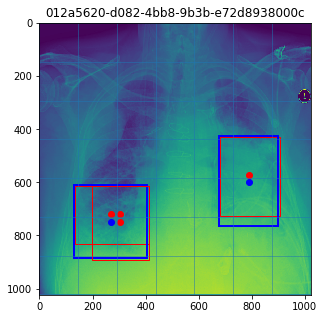

center: 0.9315068493150684 0.9315068493150684
center: 0.22945205479452055 0.9315068493150684
center: 0.910958904109589 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.9315068493150684 0.14383561643835616
center: 0.22945205479452055 0.14383561643835616
center: 0.910958904109589 0.4280821917808219
center: 0.0684931506849315 0.4280821917808219
center: 0.910958904109589 0.0684931506849315


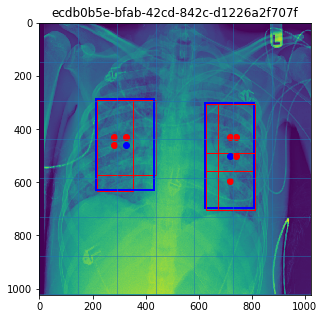

center: 0.9315068493150684 0.9315068493150684
center: 0.4657534246575342 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.7842465753424658 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.9315068493150684 0.8527397260273972
center: 0.4657534246575342 0.8527397260273972
center: 0.0684931506849315 0.8527397260273972
center: 0.7842465753424658 0.0410958904109589
center: 0.0684931506849315 0.0410958904109589
center: 0.9315068493150684 0.0684931506849315
center: 0.4657534246575342 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.7842465753424658 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


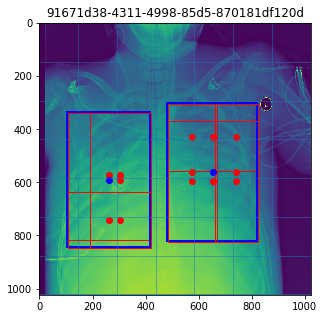

center: 0.9315068493150684 0.9315068493150684
center: 0.010273972602739725 0.9315068493150684
center: 0.985 0.4417808219178082
center: 0.010273972602739725 0.4417808219178082
center: 0.9315068493150684 0.0684931506849315
center: 0.010273972602739725 0.0684931506849315


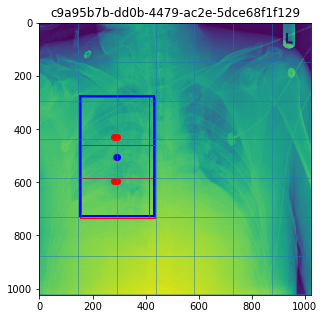

center: 0.1780821917808219 0.9315068493150684
center: 0.1780821917808219 0.21232876712328766
center: 0.1780821917808219 0.0684931506849315


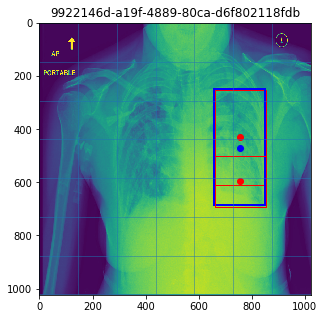

center: 0.9315068493150684 0.9315068493150684
center: 0.22602739726027396 0.9315068493150684
center: 0.9315068493150684 0.797945205479452
center: 0.22602739726027396 0.797945205479452
center: 0.9315068493150684 0.9315068493150684
center: 0.0821917808219178 0.9315068493150684
center: 0.9315068493150684 0.0684931506849315
center: 0.22602739726027396 0.0684931506849315
center: 0.9315068493150684 0.1952054794520548
center: 0.0821917808219178 0.1952054794520548
center: 0.9315068493150684 0.0684931506849315
center: 0.0821917808219178 0.0684931506849315


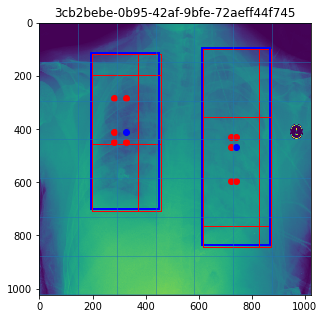

center: 0.7568493150684932 0.9315068493150684
center: 0.7568493150684932 0.9486301369863014
center: 0.0684931506849315 0.9486301369863014
center: 0.9315068493150684 0.9315068493150684
center: 0.11301369863013698 0.9315068493150684
center: 0.7568493150684932 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.9315068493150684 0.3698630136986301
center: 0.11301369863013698 0.3698630136986301
center: 0.9315068493150684 0.0684931506849315
center: 0.11301369863013698 0.0684931506849315


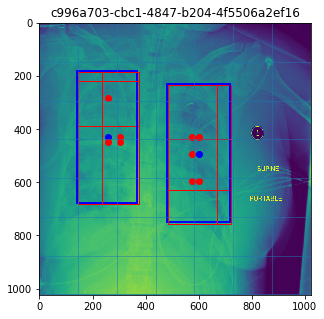

center: 0.3424657534246575 0.9315068493150684
center: 0.9315068493150684 0.7568493150684932
center: 0.3424657534246575 0.7568493150684932
center: 0.547945205479452 0.8732876712328768
center: 0.9315068493150684 0.0684931506849315
center: 0.3424657534246575 0.0684931506849315
center: 0.547945205479452 0.0684931506849315


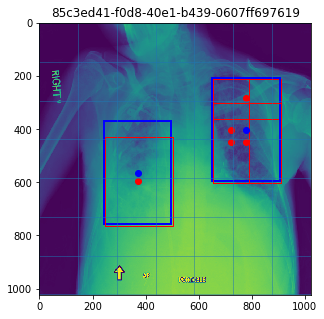

center: 0.9452054794520548 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.9315068493150684 0.9315068493150684
center: 0.3938356164383562 0.9315068493150684
center: 0.9452054794520548 0.3595890410958904
center: 0.0684931506849315 0.3595890410958904
center: 0.9315068493150684 0.6986301369863014
center: 0.3938356164383562 0.6986301369863014
center: 0.9452054794520548 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.9315068493150684 0.0684931506849315
center: 0.3938356164383562 0.0684931506849315


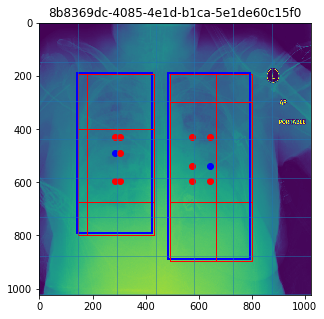

center: 0.8424657534246576 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.5342465753424658 0.9315068493150684
center: 0.8424657534246576 0.6917808219178082
center: 0.0684931506849315 0.6917808219178082
center: 0.5342465753424658 0.2602739726027397
center: 0.8424657534246576 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


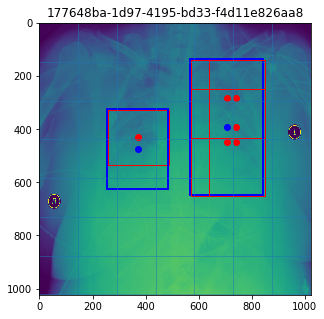

center: 0.6061643835616438 0.9315068493150684
center: 0.9315068493150684 0.9315068493150684
center: 0.4863013698630137 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.6061643835616438 0.4178082191780822
center: 0.9315068493150684 0.910958904109589
center: 0.4863013698630137 0.910958904109589
center: 0.0684931506849315 0.910958904109589
center: 0.6061643835616438 0.0684931506849315
center: 0.9315068493150684 0.0684931506849315
center: 0.4863013698630137 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


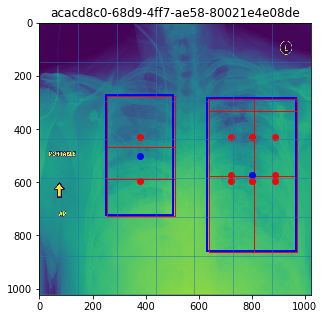

center: 0.6404109589041096 0.9315068493150684
center: 0.7431506849315068 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.6404109589041096 0.7876712328767124
center: 0.7431506849315068 0.684931506849315
center: 0.0684931506849315 0.684931506849315
center: 0.6404109589041096 0.0684931506849315
center: 0.7431506849315068 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


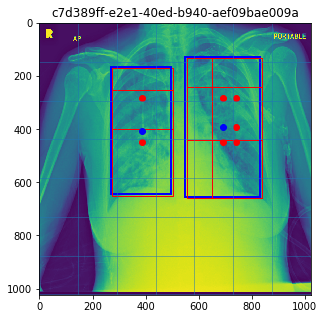

center: 0.5787671232876712 0.9315068493150684
center: 0.523972602739726 0.9315068493150684
center: 0.5787671232876712 0.8938356164383562
center: 0.0684931506849315 0.8938356164383562
center: 0.523972602739726 0.678082191780822
center: 0.5787671232876712 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.523972602739726 0.0684931506849315


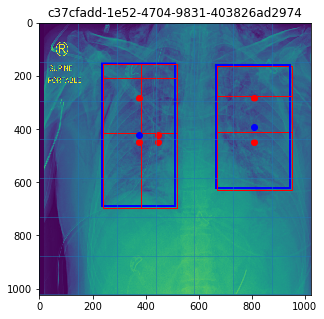

center: 0.6404109589041096 0.9315068493150684
center: 0.7431506849315068 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.6404109589041096 0.7876712328767124
center: 0.7431506849315068 0.684931506849315
center: 0.0684931506849315 0.684931506849315
center: 0.6404109589041096 0.0684931506849315
center: 0.7431506849315068 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


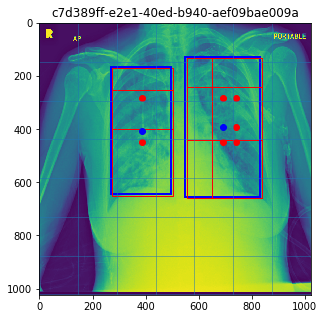

center: 0.9315068493150684 0.9417808219178082
center: 0.13013698630136986 0.9417808219178082
center: 0.9006849315068494 0.2671232876712329
center: 0.0684931506849315 0.2671232876712329
center: 0.9315068493150684 0.0684931506849315
center: 0.13013698630136986 0.0684931506849315


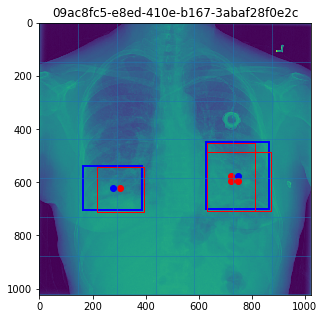

In [11]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(jittered_images, size=10, replace=False)
coords = np.arange(0, 1024, CELL_WIDTH)

# samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]
samples =  list(samples) + ["acacd8c0-68d9-4ff7-ae58-80021e4e08de","c7d389ff-e2e1-40ed-b940-aef09bae009a", "c37cfadd-1e52-4704-9831-403826ad2974", "c7d389ff-e2e1-40ed-b940-aef09bae009a", "09ac8fc5-e8ed-410e-b167-3abaf28f0e2c"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    
    # get the labels
    labels = pneumonia_locations[filename]
    
    # if the image is positive
    if np.max(labels[...,0]) > 0.5:
        fig,ax = plt.subplots(1, figsize=(5,5))
        plt.imshow(img)
        
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                if labels[i,j,0] > 0.5:
                    x, y, w, h = labels[i,j,1:]
                    w,h = w*1024, h*1024
                    center_x = unnorm(x, j, CELL_WIDTH)
                    center_y = unnorm(y, i, CELL_WIDTH)


                    print("center:", x, y)
                    x = center_x - (w / 2)
                    y = center_y - (h / 2)

                    if labels[i,j,0] == 1:
                        rect_1 = patches.Rectangle((x-2,y-2),w,h,linewidth=2,edgecolor='b',facecolor='none')
                        plt.plot(center_x, center_y, marker="o", color="b")
                    else:
                        rect_1 = patches.Rectangle((x+2,y+2),w+2,h+2,linewidth=1,edgecolor='r',facecolor='none')
                        plt.plot(center_x, center_y, marker="o", color="r")

                    ax.add_patch(rect_1)

        for item in coords:
            plt.axvline(item, linewidth=0.5)
            plt.axhline(item, linewidth=0.5)
    
        plt.title(filename)
        plt.show()

## Reference

center: 0.470703125 0.650390625
center: 0.150390625 0.52734375
center: 0.470703125 0.0390625


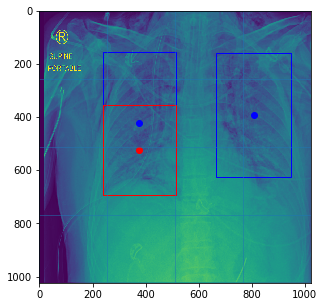

center: 0.505859375 0.58984375
center: 0.705078125 0.53125


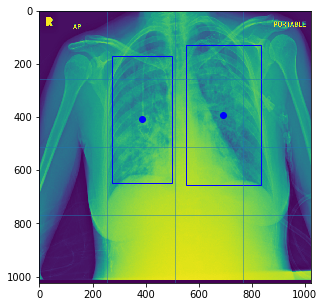

In [52]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(keys, size=5, replace=False)
coords = np.arange(0, 1024, CELL_WIDTH)

# samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]
samples = ["c37cfadd-1e52-4704-9831-403826ad2974", "c7d389ff-e2e1-40ed-b940-aef09bae009a"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    fig,ax = plt.subplots(1, figsize=(5,5))
    plt.imshow(img)
    
    # get the labels
    labels = pneumonia_locations[filename]
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if labels[i,j,0] > 0.5:
                x, y, w, h = labels[i,j,1:]
                w,h = w*1024, h*1024
                center_x = unnorm(x, j, CELL_WIDTH)
                center_y = unnorm(y, i, CELL_WIDTH)
                
                
                print("center:", x, y)
                x = center_x - (w / 2)
                y = center_y - (h / 2)
                
                if labels[i,j,0] == 1:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="b")
                else:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="r")
                    
                ax.add_patch(rect_1)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
      
    plt.show()

Confs: [[0.   0.   0.   0.  ]
 [0.   1.   0.   1.  ]
 [0.   0.99 0.   0.  ]
 [0.   0.   0.   0.  ]]
center: 0.849609375 0.52734375
center: 0.529296875 0.650390625
center: 0.529296875 0.0390625


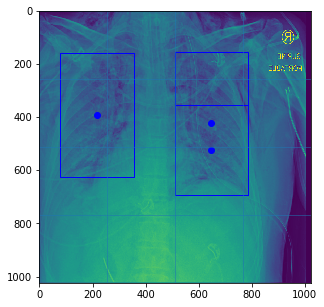

Confs: [[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
center: 0.294921875 0.53125
center: 0.494140625 0.58984375


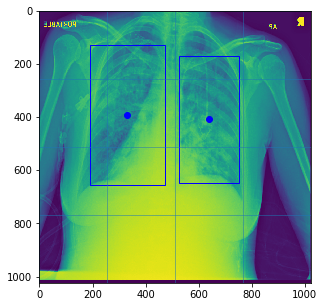

In [65]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(keys, size=5, replace=False)
coords = np.arange(0, 1024, CELL_WIDTH)

# samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]
samples = ["c37cfadd-1e52-4704-9831-403826ad2974", "c7d389ff-e2e1-40ed-b940-aef09bae009a"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    
    # flip the image
    img = np.fliplr(img)
    
    fig,ax = plt.subplots(1, figsize=(5,5))
    plt.imshow(img)
    
    # get the labels
    labels = pneumonia_locations[filename]
    print("Confs:", labels[...,0])
    confs = np.round(labels[:,:,0])
    boxes = labels[:,:,1:]
    
    # flip the labels
    mask = (confs != 0.0)
            
    # flip
    boxes[mask, 0] = (1 - boxes[mask,0])

    # flip our boxes lr on axis 0
    boxes = np.flip(boxes, axis=1)         

    # flip the confidences lr as well
    confs = np.flip(confs, axis=1)
    
    labels = np.concatenate([confs.reshape((GRID_SIZE,GRID_SIZE,1)), boxes], axis=2)
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if labels[i,j,0] > 0.5:
                x, y, w, h = labels[i,j,1:]
                w,h = w*1024, h*1024
                center_x = unnorm(x, j, CELL_WIDTH)
                center_y = unnorm(y, i, CELL_WIDTH)
                
                
                print("center:", x, y)
                x = center_x - (w / 2)
                y = center_y - (h / 2)
                
                if labels[i,j,0] == 1:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="b")
                else:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="r")
                    
                ax.add_patch(rect_1)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
      
    plt.show()